# Colorectal polyp segmentation #
The code below uses the CVC-ClinicDB public data set which consists of 612 images with corresponding segmentation masks. The dataset can be found here: https://www.kaggle.com/balraj98/cvcclinicdb?select=metadata.csv.

To run the code, put the original .tif files in the `/data/images` folder and the segmentation masks (ground truth) in the `/data/masks` folder.

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from pathlib import Path
from time import time
from functools import reduce
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold, GroupKFold
from Losses import ComboLoss, dice_metric
from Split import StratifiedGroupKFold 
import utils

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler
from torchvision import transforms

import albumentations as albu
from albumentations.pytorch.transforms import ToTensor

print('torch.cuda.is_available():', torch.cuda.is_available())

torch.cuda.is_available(): True


In [2]:
try:
    get_ipython().__class_._name__
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm

In [3]:
DATA_DIR         = Path(f'data/')
TRAIN_IMG_DIR    = DATA_DIR/'images'
TRAIN_MASK_DIR   = DATA_DIR/'masks'
RLE_DF_PATH      = 'rle.csv'
KFOLD_PATH       = 'rle_kfold.csv'
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 16
USE_SAMPLER      = False
ENCODER          = 'se_resnext50_32x4d'
ENCODER_WEIGHTS  = 'imagenet'
CLASSES          = ['mask']
ACTIVATION       = None 
DEVICE           = 'cuda'
PRETRAINED_PATH  = 'models/bst_model512_fold0_0.7811.bin'
PRETRAINED       = True
LEARNING_RATE    = 1e-4 #1e-3 or 1e-4 for aggressive training, 1e-5 for normal
EPOCHS           = 12
LOSS_FN          = 'mixed'
CRITERION        = ComboLoss(**{'weights':{'bce':3, 'dice':1, 'focal':4}})
USE_CRIT         = True
TRAIN_MODEL      = False
EVALUATE         = False
FOLD_COUNT       = 5
FOLD_ID          = 0
IMG_SIZE         = 512

In [4]:
# The public datasets have more than 2 colors (due to gradients around the edges). Convert those colors to either black or white
def map_binary(mask):
    (threshold, black_and_white) = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    return black_and_white

In [5]:
# Run-length encode the segmentation masks
def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

In [6]:
def matplotlib_imshow(img, one_channel=False):
    fig,ax = plt.subplots(figsize=(10,6))
    ax.imshow(img.permute(1,2,0).numpy())

def visualize(**images):
    """PLot images in one row."""
    images = {k:v.numpy() for k,v in images.items() if isinstance(v, torch.Tensor)} #convert tensor to numpy 
    n = len(images)
    plt.figure(figsize=(16, 8))
    image, mask = images['image'], images['mask']
    plt.imshow(image.transpose(1,2,0), vmin=0, vmax=1)
    if mask.max()>0:
        plt.imshow(mask.squeeze(0), alpha=0.25)
    plt.show()

Convert segmentation masks to RLE (https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0), put them in a dataframe and write to a CSV. This will create a dataframe that looks like this:

| ImageId | EncodedPixels               |
|---------|-----------------------------|
| 154     | 40748, 6, 281, 9, 277, 16   |
| 155     | 43614, 13, 268, 23, 263, 26 |

Doesn't have to be ran every single time.

In [7]:
data = {}
image_ids = []
encoded_pixels = []
file_paths = []
mask_paths = []

for file in tqdm(list(TRAIN_MASK_DIR.glob('**/*.tif'))):
    source = str(file.parent).split(os.sep)[-1]
    image_id = f'{source}/{file.stem}'
    image_path = file.parent.parent.parent.joinpath('images', source, file.name)
    
    img = cv2.imread(str(file), 0)
    black_and_white = map_binary(img)
    rle_encoded = run_length_encode(black_and_white)
    image_ids.append(image_id)
    encoded_pixels.append(rle_encoded)
    file_paths.append(file)
    mask_paths.append(image_path)

data['ImageId'] = image_ids
data['EncodedPixels'] = encoded_pixels
rle_df = pd.DataFrame(data, columns=['ImageId', 'EncodedPixels'])
rle_df.to_csv(RLE_DF_PATH, index=False)

100%|███████████████████████████████████████████████████████████████████████████████| 808/808 [00:06<00:00, 119.27it/s]


In [8]:
rle_tmp_df       = pd.read_csv(RLE_DF_PATH, names=['ImageId', 'EncodedPixels'], skiprows=1)
cvc_metadata_df  = pd.read_csv('cvc-metadata.csv')
etis_metadata_df = pd.read_csv('etis-metadata.csv')
dfs              = [rle_tmp_df, cvc_metadata_df, etis_metadata_df]
RLE_DF           = reduce(lambda left, right: pd.merge(left, right, how='outer', on='ImageId'), dfs)
RLE_DF['sequence_id'] = RLE_DF['sequence_id_x'].combine_first(RLE_DF['sequence_id_y'])
RLE_DF = RLE_DF.drop(columns=['sequence_id_x', 'sequence_id_y'])

RLE_DF['has_mask'] = 0
RLE_DF.loc[RLE_DF.EncodedPixels != '-1', 'has_mask'] = 1
RLE_DF['kfold'] = -1

gkf = GroupKFold(n_splits=FOLD_COUNT)
gkf.get_n_splits(RLE_DF.ImageId, RLE_DF.has_mask, RLE_DF.sequence_id)

for fold, (train_index, test_index) in enumerate(gkf.split(RLE_DF.ImageId, RLE_DF.has_mask, RLE_DF.sequence_id)):
    RLE_DF.loc[test_index, 'kfold'] = fold
    
RLE_DF.to_csv(KFOLD_PATH, index=False)

RLE_DF.head()

ImageId                                      EncodedPixels sequence_id  \
0    cvc/1  11677 54 1 8 1 14 210 53 2 8 2 1 1 1 1 10 208 ...       cvc/1   
1   cvc/10  11575 9 10 10 258 35 252 75 212 142 22 17 106 ...       cvc/1   
2  cvc/100  19728 9 274 19 263 28 256 35 251 38 247 43 243...       cvc/5   
3  cvc/101  47679 11 274 18 268 26 260 31 255 38 249 41 24...       cvc/5   
4  cvc/102  47951 24 262 27 259 32 255 35 252 37 250 39 24...       cvc/5   

   has_mask  kfold  
0         1      1  
1         1      1  
2         1      2  
3         1      2  
4         1      2

In [9]:
DF = pd.read_csv(KFOLD_PATH)
TRAIN_DF = DF.query(f'kfold!={FOLD_ID}').reset_index(drop=True)
VAL_DF = DF.query(f'kfold=={FOLD_ID}').reset_index(drop=True)

In [10]:
class Dataset():
    def __init__(self, rle_df, image_base_dir, masks_base_dir, augmentation=None):
        self.df             = rle_df
        self.image_base_dir = image_base_dir
        self.masks_base_dir = masks_base_dir
        self.image_ids      = rle_df.ImageId.values
        self.augmentation   = augmentation
    
    def __getitem__(self, i):
        image_id  = self.image_ids[i]
        img_path  = os.path.join(str(self.image_base_dir), str(image_id)+'.tif') 
        mask_path = os.path.join(str(self.masks_base_dir), str(image_id)+'.tif')
        image     = cv2.imread(img_path, 1)
        mask      = map_binary(cv2.imread(mask_path, 0))     
        
        # apply augmentations
        if self.augmentation:
            sample = {"image": image, "mask": mask}
            sample = self.augmentation(**sample)
            image, mask = sample['image'], sample['mask']

        return {
            'image': image, 
            'mask' : mask
        }
        
    def __len__(self):
        return len(self.image_ids)

In [11]:
train_transformations = albu.Compose([
    albu.SmallestMaxSize(max_size=288),
    albu.CenterCrop(288, 288),
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.Rotate(),
    albu.Normalize(),
    ToTensor()
])

test_transformations = albu.Compose([
    albu.SmallestMaxSize(max_size=288),
    albu.CenterCrop(288, 288),
    albu.Normalize(),
    ToTensor()
])

In [12]:
train_dataset = Dataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_MASK_DIR, train_transformations)
test_dataset = Dataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_MASK_DIR, test_transformations)

In [13]:
image, mask = train_dataset[0]['image'], train_dataset[0]['mask']
image.shape, mask.shape

(torch.Size([3, 288, 288]), torch.Size([1, 288, 288]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


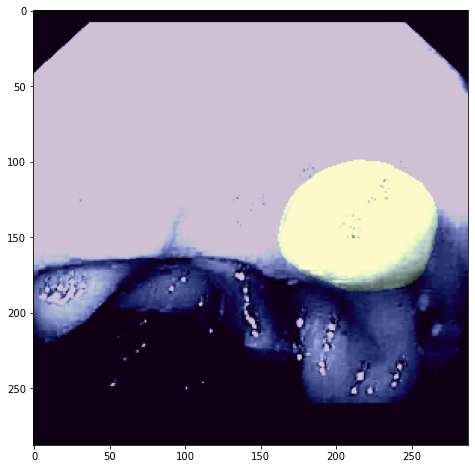

In [14]:
visualize(**train_dataset[2])

In [15]:
class PolypSampler(Sampler):
    def __init__(self, train_df, positive_perc=0.8):
        assert positive_perc > 0, 'percentage of positive polyp images must be greater than zero'
        self.train_df = train_df
        self.positive_perc = positive_perc
        self.positive_idxs = self.train_df.query('has_mask==1').index.values
        self.negative_idxs = self.train_df.query('has_mask!=1').index.values
        self.n_positive = len(self.positive_idxs)
        self.n_negative = int(self.n_positive * (1 - self.positive_perc) / self.positive_perc)
        
    def __iter__(self):
        negative_sample = np.random.choice(self.negative_idxs, size=self.n_negative)
        shuffled = np.random.permutation(np.hstack((negative_sample, self.positive_idxs)))
        return iter(shuffled.tolist())

    def __len__(self):
        return self.n_positive + self.n_negative
    
SAMPLER = PolypSampler(TRAIN_DF, positive_perc=1)

In [16]:
train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE, 
                              shuffle=True if not USE_SAMPLER else False, 
                              num_workers=0, 
                              sampler=SAMPLER if USE_SAMPLER else None)
val_dataloader   = DataLoader(test_dataset, VALID_BATCH_SIZE, shuffle=False, num_workers=0)

In [17]:
images, masks = next(iter(train_dataloader))['image'], next(iter(train_dataloader))['mask']
images.shape, masks.shape

(torch.Size([8, 3, 288, 288]), torch.Size([8, 1, 288, 288]))

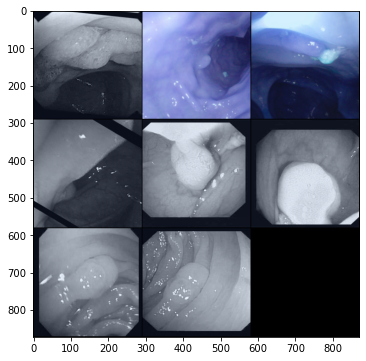

In [18]:
img_grid = torchvision.utils.make_grid(images[:9], nrow=3, normalize=True)
matplotlib_imshow(img_grid)

In [19]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

In [21]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [22]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [23]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.0001):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        model_path = Path(model_path)
        parent = model_path.parent
        os.makedirs(parent, exist_ok=True)
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Model saved at at {}!".format(
                    self.val_score, epoch_score, model_path
                )
            )
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

In [24]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
def train_one_epoch(train_loader, model, optimizer, loss_fn, accumulation_steps=1, device='cuda'):
    losses = AverageMeter()
    model = model.to(device)
    model.train()
    if accumulation_steps > 1: 
        optimizer.zero_grad()
    tk0 = tqdm(train_loader, total=len(train_loader))
    for b_idx, data in enumerate(tk0):
        for key, value in data.items():
            data[key] = value.to(device)
        if accumulation_steps == 1 and b_idx == 0:
            optimizer.zero_grad()
        out  = model(data['image'])
        loss = loss_fn(out, data['mask'])
        with torch.set_grad_enabled(True):
            loss.backward()
            if (b_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
        losses.update(loss.item(), train_loader.batch_size)
        tk0.set_postfix(loss=losses.avg, learning_rate=optimizer.param_groups[0]['lr'])
    return losses.avg

In [26]:
def acc_metric(input, target):
    inp = torch.where(input>0.5, torch.tensor(1, device='cuda'), torch.tensor(0, device='cuda'))
    acc = (inp.squeeze(1) == target).float().mean()
    return acc

In [27]:
def metric(probability, truth, threshold=0.5, reduction='none'):
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice

In [28]:
def evaluate(valid_loader, model, device='cuda', metric=dice_metric):
    losses = AverageMeter()
    model = model.to(device)
    model.eval()
    tk0 = tqdm(valid_loader, total=len(valid_loader))
    with torch.no_grad():
        for b_idx, data in enumerate(tk0):
            for key, value in data.items():
                data[key] = value.to(device)
            out   = model(data['image'])
            out   = torch.sigmoid(out)
            dice  = metric(out, data['mask']).cpu()
            losses.update(dice.mean().item(), valid_loader.batch_size)
            tk0.set_postfix(dice_score=losses.avg)
    return losses.avg

In [29]:
if PRETRAINED: 
    model.load_state_dict(torch.load(PRETRAINED_PATH))
    model.cuda()

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[3,5,6,7,8,9,10,11,13,15], gamma=0.75)

In [31]:
criterion = MixedLoss(10.0, 2.0) if not USE_CRIT else CRITERION 
es = EarlyStopping(patience=10, mode='max')

In [32]:
criterion

ComboLoss(
  (bce): StableBCELoss()
  (dice): DiceLoss()
  (jaccard): JaccardLoss()
  (lovasz): LovaszLoss()
  (lovasz_sigmoid): LovaszLossSigmoid()
  (focal): FocalLoss2d()
)

In [33]:
if TRAIN_MODEL:
    for epoch in range(EPOCHS):
        loss = train_one_epoch(train_dataloader, model, optimizer, criterion)
        dice = evaluate(val_dataloader, model, metric=metric)
        scheduler.step()
        print(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, VAL DICE: {dice}")
        es(dice, model, model_path=f"/models/bst_model{IMG_SIZE}_fold{FOLD_ID}_{np.round(dice,4)}.bin")
        best_model = f"../data/bst_model{IMG_SIZE}__fold{FOLD_ID}_{np.round(es.best_score,4)}.bin"
        if es.early_stop:
            print('\n\n -------------- EARLY STOPPING -------------- \n\n')
            break
if EVALUATE:
    valid_score = evaluate(val_dataloader, model, metric=metric)
    print(f"Valid dice score: {valid_score}")

## Try the model on a video

In [34]:
def center_crop(img, dim):
    width, height = img.shape[1], img.shape[0]

    # process crop width and height for max available dimension
    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2) 
    crop_img = img[miC:\Users\LeonCullens\Repos\ADAPT\docker-compose.ymld_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
    return crop_img

In [54]:
capture = cv2.VideoCapture('data/videos/17.mp4')
_, frame = capture.read()
H, W = frame.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('data/videos/processed/17.mp4', fourcc, 30, (W,H))

COLOR1 = [255, 0, 0]
COLOR2 = [0, 0, 255]
# success, frame = capture.read()

model.to('cuda')
model.eval()

while capture.isOpened():
    start_time = time()
    _, frame = capture.read()
    image = frame[...,::-1]
    h, w = image.shape[:2]
    read_cam_time = time()

    X, pad_up, pad_left, h_new, w_new = utils.preprocessing(image, 1088, pad_value=0)
    preproc_time = time()
    with torch.no_grad():
        mask = model(X.cuda())
        mask = mask[..., pad_up: pad_up+h_new, pad_left: pad_left+w_new]
        mask = F.interpolate(mask, size=(h,w), mode='bilinear', align_corners=True)
        mask = F.softmax(mask, dim=1)
        mask = mask[0,0,...].cpu().numpy()
    predict_time = time()
        
    image_alpha = utils.draw_transperency(image, mask, COLOR1, COLOR2)
    draw_time = time()
    
    read = read_cam_time-start_time
    preproc = preproc_time-read_cam_time
    pred = predict_time-preproc_time
    draw = draw_time-predict_time
    total = read + preproc + pred + draw
    fps = 1 / total
    print("read: %.3f [s]; preproc: %.3f [s]; pred: %.3f [s]; draw: %.3f [s]; total: %.3f [s]; fps: %.2f [Hz]" % 
        (read, preproc, pred, draw, total, fps))
    
    out.write(image_alpha[..., ::-1])
    cv2.imshow('webcam', image_alpha[..., ::-1])

capture.release()
cv2.destroyAllWindows()

read: 0.005 [s]; preproc: 0.050 [s]; pred: 0.105 [s]; draw: 0.110 [s]; total: 0.270 [s]; fps: 3.70 [Hz]
read: 0.004 [s]; preproc: 0.048 [s]; pred: 0.110 [s]; draw: 0.119 [s]; total: 0.281 [s]; fps: 3.56 [Hz]
read: 0.006 [s]; preproc: 0.054 [s]; pred: 0.088 [s]; draw: 0.121 [s]; total: 0.269 [s]; fps: 3.71 [Hz]
read: 0.005 [s]; preproc: 0.058 [s]; pred: 0.089 [s]; draw: 0.108 [s]; total: 0.259 [s]; fps: 3.85 [Hz]
read: 0.004 [s]; preproc: 0.057 [s]; pred: 0.088 [s]; draw: 0.109 [s]; total: 0.258 [s]; fps: 3.87 [Hz]
read: 0.005 [s]; preproc: 0.055 [s]; pred: 0.090 [s]; draw: 0.130 [s]; total: 0.280 [s]; fps: 3.57 [Hz]
read: 0.005 [s]; preproc: 0.049 [s]; pred: 0.089 [s]; draw: 0.107 [s]; total: 0.250 [s]; fps: 3.99 [Hz]
read: 0.004 [s]; preproc: 0.052 [s]; pred: 0.083 [s]; draw: 0.113 [s]; total: 0.252 [s]; fps: 3.96 [Hz]
read: 0.004 [s]; preproc: 0.048 [s]; pred: 0.087 [s]; draw: 0.112 [s]; total: 0.251 [s]; fps: 3.98 [Hz]
read: 0.005 [s]; preproc: 0.058 [s]; pred: 0.089 [s]; draw: 0.11

read: 0.009 [s]; preproc: 0.065 [s]; pred: 0.095 [s]; draw: 0.121 [s]; total: 0.289 [s]; fps: 3.45 [Hz]
read: 0.011 [s]; preproc: 0.062 [s]; pred: 0.089 [s]; draw: 0.113 [s]; total: 0.276 [s]; fps: 3.63 [Hz]
read: 0.005 [s]; preproc: 0.056 [s]; pred: 0.089 [s]; draw: 0.123 [s]; total: 0.273 [s]; fps: 3.66 [Hz]
read: 0.013 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.112 [s]; total: 0.289 [s]; fps: 3.47 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.114 [s]; total: 0.289 [s]; fps: 3.46 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.121 [s]; total: 0.282 [s]; fps: 3.55 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.124 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.009 [s]; preproc: 0.056 [s]; pred: 0.086 [s]; draw: 0.116 [s]; total: 0.267 [s]; fps: 3.75 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.121 [s]; total: 0.291 [s]; fps: 3.44 [Hz]
read: 0.005 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.11

read: 0.012 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.126 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.011 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.116 [s]; total: 0.275 [s]; fps: 3.64 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.090 [s]; draw: 0.127 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.088 [s]; draw: 0.115 [s]; total: 0.268 [s]; fps: 3.73 [Hz]
read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.091 [s]; draw: 0.138 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.005 [s]; preproc: 0.052 [s]; pred: 0.089 [s]; draw: 0.111 [s]; total: 0.257 [s]; fps: 3.89 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.092 [s]; draw: 0.134 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.085 [s]; draw: 0.119 [s]; total: 0.269 [s]; fps: 3.71 [Hz]
read: 0.006 [s]; preproc: 0.082 [s]; pred: 0.090 [s]; draw: 0.112 [s]; total: 0.290 [s]; fps: 3.44 [Hz]
read: 0.005 [s]; preproc: 0.080 [s]; pred: 0.098 [s]; draw: 0.12

read: 0.006 [s]; preproc: 0.050 [s]; pred: 0.090 [s]; draw: 0.123 [s]; total: 0.269 [s]; fps: 3.71 [Hz]
read: 0.005 [s]; preproc: 0.055 [s]; pred: 0.090 [s]; draw: 0.119 [s]; total: 0.268 [s]; fps: 3.74 [Hz]
read: 0.011 [s]; preproc: 0.075 [s]; pred: 0.085 [s]; draw: 0.120 [s]; total: 0.290 [s]; fps: 3.44 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.121 [s]; total: 0.297 [s]; fps: 3.36 [Hz]
read: 0.009 [s]; preproc: 0.061 [s]; pred: 0.090 [s]; draw: 0.128 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.121 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.010 [s]; preproc: 0.092 [s]; pred: 0.090 [s]; draw: 0.127 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.056 [s]; pred: 0.089 [s]; draw: 0.121 [s]; total: 0.272 [s]; fps: 3.68 [Hz]
read: 0.006 [s]; preproc: 0.093 [s]; pred: 0.091 [s]; draw: 0.129 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.090 [s]; draw: 0.12

read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.124 [s]; total: 0.297 [s]; fps: 3.36 [Hz]
read: 0.007 [s]; preproc: 0.057 [s]; pred: 0.090 [s]; draw: 0.115 [s]; total: 0.269 [s]; fps: 3.72 [Hz]
read: 0.005 [s]; preproc: 0.064 [s]; pred: 0.090 [s]; draw: 0.136 [s]; total: 0.296 [s]; fps: 3.38 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.088 [s]; draw: 0.141 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.120 [s]; total: 0.274 [s]; fps: 3.65 [Hz]
read: 0.006 [s]; preproc: 0.055 [s]; pred: 0.088 [s]; draw: 0.138 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.011 [s]; preproc: 0.063 [s]; pred: 0.089 [s]; draw: 0.116 [s]; total: 0.279 [s]; fps: 3.59 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.091 [s]; draw: 0.116 [s]; total: 0.291 [s]; fps: 3.43 [Hz]
read: 0.005 [s]; preproc: 0.055 [s]; pred: 0.089 [s]; draw: 0.127 [s]; total: 0.275 [s]; fps: 3.63 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.12

read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.117 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.140 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.007 [s]; preproc: 0.095 [s]; pred: 0.089 [s]; draw: 0.123 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.009 [s]; preproc: 0.063 [s]; pred: 0.089 [s]; draw: 0.139 [s]; total: 0.300 [s]; fps: 3.34 [Hz]
read: 0.012 [s]; preproc: 0.070 [s]; pred: 0.084 [s]; draw: 0.130 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.137 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.007 [s]; preproc: 0.058 [s]; pred: 0.090 [s]; draw: 0.137 [s]; total: 0.292 [s]; fps: 3.42 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.131 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.092 [s]; draw: 0.126 [s]; total: 0.298 [s]; fps: 3.35 [Hz]
read: 0.009 [s]; preproc: 0.065 [s]; pred: 0.099 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.136 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.090 [s]; draw: 0.164 [s]; total: 0.326 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.091 [s]; draw: 0.159 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.091 [s]; draw: 0.153 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.096 [s]; pred: 0.100 [s]; draw: 0.188 [s]; total: 0.392 [s]; fps: 2.55 [Hz]
read: 0.009 [s]; preproc: 0.086 [s]; pred: 0.090 [s]; draw: 0.175 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.010 [s]; preproc: 0.071 [s]; pred: 0.095 [s]; draw: 0.152 [s]; total: 0.327 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.093 [s]; draw: 0.192 [s]; total: 0.368 [s]; fps: 2.71 [Hz]
read: 0.007 [s]; preproc: 0.090 [s]; pred: 0.094 [s]; draw: 0.168 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.100 [s]; draw: 0.15

read: 0.010 [s]; preproc: 0.096 [s]; pred: 0.090 [s]; draw: 0.178 [s]; total: 0.374 [s]; fps: 2.67 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.179 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.008 [s]; preproc: 0.086 [s]; pred: 0.095 [s]; draw: 0.180 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.008 [s]; preproc: 0.087 [s]; pred: 0.092 [s]; draw: 0.184 [s]; total: 0.371 [s]; fps: 2.70 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.091 [s]; draw: 0.163 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.006 [s]; preproc: 0.095 [s]; pred: 0.095 [s]; draw: 0.176 [s]; total: 0.373 [s]; fps: 2.68 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.093 [s]; draw: 0.168 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.092 [s]; pred: 0.096 [s]; draw: 0.160 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.095 [s]; draw: 0.182 [s]; total: 0.359 [s]; fps: 2.78 [Hz]
read: 0.013 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.17

read: 0.009 [s]; preproc: 0.078 [s]; pred: 0.123 [s]; draw: 0.193 [s]; total: 0.402 [s]; fps: 2.49 [Hz]
read: 0.005 [s]; preproc: 0.087 [s]; pred: 0.102 [s]; draw: 0.181 [s]; total: 0.374 [s]; fps: 2.67 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.170 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.011 [s]; preproc: 0.083 [s]; pred: 0.091 [s]; draw: 0.167 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.009 [s]; preproc: 0.071 [s]; pred: 0.097 [s]; draw: 0.185 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.007 [s]; preproc: 0.091 [s]; pred: 0.102 [s]; draw: 0.213 [s]; total: 0.413 [s]; fps: 2.42 [Hz]
read: 0.011 [s]; preproc: 0.100 [s]; pred: 0.094 [s]; draw: 0.206 [s]; total: 0.411 [s]; fps: 2.43 [Hz]
read: 0.006 [s]; preproc: 0.119 [s]; pred: 0.094 [s]; draw: 0.253 [s]; total: 0.472 [s]; fps: 2.12 [Hz]
read: 0.008 [s]; preproc: 0.088 [s]; pred: 0.092 [s]; draw: 0.173 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.20

read: 0.007 [s]; preproc: 0.113 [s]; pred: 0.091 [s]; draw: 0.156 [s]; total: 0.367 [s]; fps: 2.73 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.097 [s]; draw: 0.201 [s]; total: 0.376 [s]; fps: 2.66 [Hz]
read: 0.011 [s]; preproc: 0.102 [s]; pred: 0.089 [s]; draw: 0.162 [s]; total: 0.363 [s]; fps: 2.75 [Hz]
read: 0.009 [s]; preproc: 0.088 [s]; pred: 0.089 [s]; draw: 0.145 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.189 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.095 [s]; draw: 0.155 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.010 [s]; preproc: 0.090 [s]; pred: 0.092 [s]; draw: 0.166 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.008 [s]; preproc: 0.087 [s]; pred: 0.090 [s]; draw: 0.167 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.009 [s]; preproc: 0.101 [s]; pred: 0.090 [s]; draw: 0.192 [s]; total: 0.391 [s]; fps: 2.56 [Hz]
read: 0.010 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.19

read: 0.008 [s]; preproc: 0.085 [s]; pred: 0.089 [s]; draw: 0.157 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.091 [s]; draw: 0.167 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.205 [s]; total: 0.386 [s]; fps: 2.59 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.083 [s]; draw: 0.159 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.006 [s]; preproc: 0.095 [s]; pred: 0.090 [s]; draw: 0.152 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.170 [s]; total: 0.337 [s]; fps: 2.96 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.092 [s]; draw: 0.148 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.010 [s]; preproc: 0.072 [s]; pred: 0.092 [s]; draw: 0.146 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.085 [s]; draw: 0.168 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.091 [s]; draw: 0.18

read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.084 [s]; draw: 0.149 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.092 [s]; draw: 0.193 [s]; total: 0.368 [s]; fps: 2.72 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.091 [s]; draw: 0.166 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.093 [s]; draw: 0.186 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.011 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.188 [s]; total: 0.374 [s]; fps: 2.67 [Hz]
read: 0.009 [s]; preproc: 0.076 [s]; pred: 0.091 [s]; draw: 0.148 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.092 [s]; draw: 0.168 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.005 [s]; preproc: 0.081 [s]; pred: 0.093 [s]; draw: 0.180 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.104 [s]; draw: 0.206 [s]; total: 0.387 [s]; fps: 2.58 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.093 [s]; draw: 0.15

read: 0.012 [s]; preproc: 0.078 [s]; pred: 0.095 [s]; draw: 0.169 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.004 [s]; preproc: 0.083 [s]; pred: 0.084 [s]; draw: 0.183 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.016 [s]; preproc: 0.104 [s]; pred: 0.090 [s]; draw: 0.161 [s]; total: 0.371 [s]; fps: 2.70 [Hz]
read: 0.006 [s]; preproc: 0.084 [s]; pred: 0.089 [s]; draw: 0.195 [s]; total: 0.373 [s]; fps: 2.68 [Hz]
read: 0.005 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.171 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.095 [s]; draw: 0.160 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.084 [s]; draw: 0.170 [s]; total: 0.333 [s]; fps: 3.01 [Hz]
read: 0.009 [s]; preproc: 0.090 [s]; pred: 0.089 [s]; draw: 0.174 [s]; total: 0.363 [s]; fps: 2.76 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.164 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.17

read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.090 [s]; draw: 0.192 [s]; total: 0.372 [s]; fps: 2.69 [Hz]
read: 0.009 [s]; preproc: 0.116 [s]; pred: 0.103 [s]; draw: 0.202 [s]; total: 0.431 [s]; fps: 2.32 [Hz]
read: 0.009 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.171 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.008 [s]; preproc: 0.087 [s]; pred: 0.091 [s]; draw: 0.185 [s]; total: 0.371 [s]; fps: 2.69 [Hz]
read: 0.008 [s]; preproc: 0.087 [s]; pred: 0.116 [s]; draw: 0.203 [s]; total: 0.414 [s]; fps: 2.41 [Hz]
read: 0.009 [s]; preproc: 0.082 [s]; pred: 0.095 [s]; draw: 0.169 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.170 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.091 [s]; draw: 0.196 [s]; total: 0.375 [s]; fps: 2.67 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.089 [s]; draw: 0.180 [s]; total: 0.358 [s]; fps: 2.80 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.091 [s]; draw: 0.160 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.011 [s]; preproc: 0.082 [s]; pred: 0.092 [s]; draw: 0.181 [s]; total: 0.366 [s]; fps: 2.74 [Hz]
read: 0.010 [s]; preproc: 0.091 [s]; pred: 0.092 [s]; draw: 0.162 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.007 [s]; preproc: 0.089 [s]; pred: 0.093 [s]; draw: 0.181 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.202 [s]; total: 0.372 [s]; fps: 2.69 [Hz]
read: 0.010 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.159 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.086 [s]; draw: 0.180 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.008 [s]; preproc: 0.084 [s]; pred: 0.089 [s]; draw: 0.168 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.098 [s]; draw: 0.192 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.16

read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.086 [s]; draw: 0.174 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.088 [s]; pred: 0.089 [s]; draw: 0.189 [s]; total: 0.374 [s]; fps: 2.68 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.170 [s]; total: 0.344 [s]; fps: 2.90 [Hz]
read: 0.008 [s]; preproc: 0.088 [s]; pred: 0.091 [s]; draw: 0.198 [s]; total: 0.385 [s]; fps: 2.60 [Hz]
read: 0.008 [s]; preproc: 0.084 [s]; pred: 0.090 [s]; draw: 0.173 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.083 [s]; draw: 0.151 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.092 [s]; draw: 0.179 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.190 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.179 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.18

read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.010 [s]; preproc: 0.099 [s]; pred: 0.091 [s]; draw: 0.165 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.011 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.159 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.197 [s]; total: 0.370 [s]; fps: 2.70 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.091 [s]; draw: 0.167 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.087 [s]; draw: 0.152 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.093 [s]; draw: 0.169 [s]; total: 0.350 [s]; fps: 2.85 [Hz]
read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.092 [s]; draw: 0.172 [s]; total: 0.350 [s]; fps: 2.85 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.167 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.091 [s]; draw: 0.15

read: 0.009 [s]; preproc: 0.084 [s]; pred: 0.088 [s]; draw: 0.173 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.178 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.091 [s]; draw: 0.181 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.167 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.011 [s]; preproc: 0.075 [s]; pred: 0.084 [s]; draw: 0.146 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.005 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.183 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.092 [s]; draw: 0.161 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.101 [s]; draw: 0.147 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.105 [s]; draw: 0.165 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.094 [s]; draw: 0.16

read: 0.009 [s]; preproc: 0.082 [s]; pred: 0.093 [s]; draw: 0.170 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.084 [s]; draw: 0.170 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.009 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.139 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.159 [s]; total: 0.333 [s]; fps: 3.01 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.182 [s]; total: 0.350 [s]; fps: 2.85 [Hz]
read: 0.008 [s]; preproc: 0.084 [s]; pred: 0.095 [s]; draw: 0.177 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.085 [s]; draw: 0.175 [s]; total: 0.350 [s]; fps: 2.85 [Hz]
read: 0.011 [s]; preproc: 0.078 [s]; pred: 0.100 [s]; draw: 0.166 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.110 [s]; draw: 0.175 [s]; total: 0.366 [s]; fps: 2.73 [Hz]
read: 0.009 [s]; preproc: 0.120 [s]; pred: 0.109 [s]; draw: 0.17

read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.092 [s]; draw: 0.175 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.090 [s]; draw: 0.178 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.005 [s]; preproc: 0.081 [s]; pred: 0.084 [s]; draw: 0.167 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.169 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.008 [s]; preproc: 0.085 [s]; pred: 0.096 [s]; draw: 0.158 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.096 [s]; draw: 0.174 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.010 [s]; preproc: 0.079 [s]; pred: 0.099 [s]; draw: 0.157 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.097 [s]; draw: 0.175 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.007 [s]; preproc: 0.106 [s]; pred: 0.109 [s]; draw: 0.167 [s]; total: 0.389 [s]; fps: 2.57 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.17

read: 0.010 [s]; preproc: 0.085 [s]; pred: 0.092 [s]; draw: 0.194 [s]; total: 0.381 [s]; fps: 2.62 [Hz]
read: 0.009 [s]; preproc: 0.092 [s]; pred: 0.097 [s]; draw: 0.187 [s]; total: 0.384 [s]; fps: 2.60 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.096 [s]; draw: 0.188 [s]; total: 0.376 [s]; fps: 2.66 [Hz]
read: 0.007 [s]; preproc: 0.103 [s]; pred: 0.099 [s]; draw: 0.184 [s]; total: 0.393 [s]; fps: 2.54 [Hz]
read: 0.005 [s]; preproc: 0.089 [s]; pred: 0.102 [s]; draw: 0.169 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.011 [s]; preproc: 0.099 [s]; pred: 0.094 [s]; draw: 0.179 [s]; total: 0.384 [s]; fps: 2.61 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.099 [s]; draw: 0.189 [s]; total: 0.374 [s]; fps: 2.67 [Hz]
read: 0.009 [s]; preproc: 0.090 [s]; pred: 0.099 [s]; draw: 0.175 [s]; total: 0.374 [s]; fps: 2.67 [Hz]
read: 0.012 [s]; preproc: 0.096 [s]; pred: 0.095 [s]; draw: 0.181 [s]; total: 0.384 [s]; fps: 2.60 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.094 [s]; draw: 0.18

read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.091 [s]; draw: 0.159 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.010 [s]; preproc: 0.075 [s]; pred: 0.109 [s]; draw: 0.213 [s]; total: 0.407 [s]; fps: 2.46 [Hz]
read: 0.007 [s]; preproc: 0.092 [s]; pred: 0.106 [s]; draw: 0.197 [s]; total: 0.402 [s]; fps: 2.49 [Hz]
read: 0.011 [s]; preproc: 0.101 [s]; pred: 0.091 [s]; draw: 0.246 [s]; total: 0.448 [s]; fps: 2.23 [Hz]
read: 0.008 [s]; preproc: 0.091 [s]; pred: 0.095 [s]; draw: 0.218 [s]; total: 0.412 [s]; fps: 2.43 [Hz]
read: 0.007 [s]; preproc: 0.106 [s]; pred: 0.094 [s]; draw: 0.259 [s]; total: 0.467 [s]; fps: 2.14 [Hz]
read: 0.006 [s]; preproc: 0.096 [s]; pred: 0.094 [s]; draw: 0.224 [s]; total: 0.419 [s]; fps: 2.38 [Hz]
read: 0.007 [s]; preproc: 0.099 [s]; pred: 0.088 [s]; draw: 0.204 [s]; total: 0.399 [s]; fps: 2.51 [Hz]
read: 0.007 [s]; preproc: 0.092 [s]; pred: 0.091 [s]; draw: 0.225 [s]; total: 0.415 [s]; fps: 2.41 [Hz]
read: 0.011 [s]; preproc: 0.110 [s]; pred: 0.090 [s]; draw: 0.20

read: 0.011 [s]; preproc: 0.089 [s]; pred: 0.089 [s]; draw: 0.161 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.005 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.184 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.164 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.171 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.101 [s]; pred: 0.091 [s]; draw: 0.183 [s]; total: 0.382 [s]; fps: 2.62 [Hz]
read: 0.009 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.161 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.091 [s]; draw: 0.160 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.095 [s]; draw: 0.163 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.178 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.17

read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.166 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.160 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.090 [s]; draw: 0.172 [s]; total: 0.338 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.088 [s]; pred: 0.084 [s]; draw: 0.175 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.164 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.180 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.004 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.166 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.084 [s]; draw: 0.189 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.005 [s]; preproc: 0.062 [s]; pred: 0.091 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.160 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.091 [s]; draw: 0.189 [s]; total: 0.364 [s]; fps: 2.74 [Hz]
read: 0.005 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.199 [s]; total: 0.367 [s]; fps: 2.72 [Hz]
read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.185 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.009 [s]; preproc: 0.070 [s]; pred: 0.083 [s]; draw: 0.155 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.184 [s]; total: 0.359 [s]; fps: 2.78 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.091 [s]; draw: 0.178 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.182 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.007 [s]; preproc: 0.102 [s]; pred: 0.089 [s]; draw: 0.181 [s]; total: 0.379 [s]; fps: 2.64 [Hz]
read: 0.011 [s]; preproc: 0.083 [s]; pred: 0.084 [s]; draw: 0.17

read: 0.010 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.185 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.166 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.196 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.181 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.095 [s]; draw: 0.160 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.180 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.093 [s]; draw: 0.191 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.009 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.170 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.084 [s]; draw: 0.15

read: 0.010 [s]; preproc: 0.101 [s]; pred: 0.094 [s]; draw: 0.179 [s]; total: 0.384 [s]; fps: 2.61 [Hz]
read: 0.005 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.202 [s]; total: 0.372 [s]; fps: 2.69 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.097 [s]; draw: 0.159 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.008 [s]; preproc: 0.084 [s]; pred: 0.096 [s]; draw: 0.192 [s]; total: 0.379 [s]; fps: 2.64 [Hz]
read: 0.012 [s]; preproc: 0.092 [s]; pred: 0.105 [s]; draw: 0.150 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.099 [s]; draw: 0.154 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.092 [s]; draw: 0.181 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.098 [s]; draw: 0.165 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.011 [s]; preproc: 0.077 [s]; pred: 0.099 [s]; draw: 0.183 [s]; total: 0.370 [s]; fps: 2.71 [Hz]
read: 0.006 [s]; preproc: 0.084 [s]; pred: 0.109 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.092 [s]; draw: 0.168 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.011 [s]; preproc: 0.079 [s]; pred: 0.098 [s]; draw: 0.172 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.096 [s]; draw: 0.172 [s]; total: 0.350 [s]; fps: 2.85 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.108 [s]; draw: 0.156 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.108 [s]; draw: 0.167 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.108 [s]; draw: 0.166 [s]; total: 0.366 [s]; fps: 2.73 [Hz]
read: 0.009 [s]; preproc: 0.083 [s]; pred: 0.109 [s]; draw: 0.157 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.099 [s]; draw: 0.170 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.005 [s]; preproc: 0.080 [s]; pred: 0.104 [s]; draw: 0.154 [s]; total: 0.344 [s]; fps: 2.90 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.107 [s]; draw: 0.18

read: 0.009 [s]; preproc: 0.089 [s]; pred: 0.090 [s]; draw: 0.163 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.013 [s]; preproc: 0.096 [s]; pred: 0.089 [s]; draw: 0.171 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.160 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.087 [s]; pred: 0.085 [s]; draw: 0.173 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.150 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.094 [s]; pred: 0.092 [s]; draw: 0.178 [s]; total: 0.371 [s]; fps: 2.69 [Hz]
read: 0.009 [s]; preproc: 0.082 [s]; pred: 0.110 [s]; draw: 0.214 [s]; total: 0.415 [s]; fps: 2.41 [Hz]
read: 0.010 [s]; preproc: 0.086 [s]; pred: 0.092 [s]; draw: 0.183 [s]; total: 0.371 [s]; fps: 2.69 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.092 [s]; draw: 0.190 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.091 [s]; draw: 0.19

read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.174 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.086 [s]; pred: 0.091 [s]; draw: 0.152 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.169 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.009 [s]; preproc: 0.074 [s]; pred: 0.084 [s]; draw: 0.188 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.011 [s]; preproc: 0.091 [s]; pred: 0.096 [s]; draw: 0.185 [s]; total: 0.383 [s]; fps: 2.61 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.170 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.152 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.009 [s]; preproc: 0.088 [s]; pred: 0.090 [s]; draw: 0.182 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.084 [s]; draw: 0.163 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.097 [s]; draw: 0.149 [s]; total: 0.333 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.106 [s]; draw: 0.178 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.105 [s]; draw: 0.155 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.010 [s]; preproc: 0.089 [s]; pred: 0.103 [s]; draw: 0.202 [s]; total: 0.405 [s]; fps: 2.47 [Hz]
read: 0.010 [s]; preproc: 0.073 [s]; pred: 0.111 [s]; draw: 0.188 [s]; total: 0.382 [s]; fps: 2.62 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.100 [s]; draw: 0.154 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.109 [s]; draw: 0.149 [s]; total: 0.340 [s]; fps: 2.95 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.108 [s]; draw: 0.160 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.007 [s]; preproc: 0.097 [s]; pred: 0.107 [s]; draw: 0.185 [s]; total: 0.395 [s]; fps: 2.53 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.106 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.098 [s]; pred: 0.110 [s]; draw: 0.158 [s]; total: 0.371 [s]; fps: 2.70 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.165 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.011 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.147 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.167 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.010 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.198 [s]; total: 0.374 [s]; fps: 2.68 [Hz]
read: 0.008 [s]; preproc: 0.092 [s]; pred: 0.091 [s]; draw: 0.188 [s]; total: 0.379 [s]; fps: 2.64 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.090 [s]; draw: 0.168 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.010 [s]; preproc: 0.083 [s]; pred: 0.087 [s]; draw: 0.163 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.200 [s]; total: 0.363 [s]; fps: 2.76 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.19

read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.091 [s]; draw: 0.193 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.009 [s]; preproc: 0.089 [s]; pred: 0.092 [s]; draw: 0.182 [s]; total: 0.372 [s]; fps: 2.69 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.083 [s]; draw: 0.197 [s]; total: 0.371 [s]; fps: 2.69 [Hz]
read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.178 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.091 [s]; draw: 0.174 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.096 [s]; pred: 0.090 [s]; draw: 0.179 [s]; total: 0.372 [s]; fps: 2.69 [Hz]
read: 0.007 [s]; preproc: 0.111 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.360 [s]; fps: 2.77 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.085 [s]; draw: 0.169 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.009 [s]; preproc: 0.084 [s]; pred: 0.088 [s]; draw: 0.181 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.094 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.093 [s]; draw: 0.158 [s]; total: 0.337 [s]; fps: 2.96 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.195 [s]; total: 0.370 [s]; fps: 2.70 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.092 [s]; draw: 0.157 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.098 [s]; draw: 0.166 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.093 [s]; draw: 0.164 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.009 [s]; preproc: 0.085 [s]; pred: 0.100 [s]; draw: 0.181 [s]; total: 0.375 [s]; fps: 2.67 [Hz]
read: 0.007 [s]; preproc: 0.087 [s]; pred: 0.090 [s]; draw: 0.182 [s]; total: 0.367 [s]; fps: 2.73 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.166 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.087 [s]; draw: 0.181 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.104 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.177 [s]; total: 0.344 [s]; fps: 2.90 [Hz]
read: 0.008 [s]; preproc: 0.091 [s]; pred: 0.091 [s]; draw: 0.164 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.097 [s]; draw: 0.166 [s]; total: 0.350 [s]; fps: 2.85 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.162 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.192 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.010 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.165 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.009 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.185 [s]; total: 0.355 [s]; fps: 2.81 [Hz]
read: 0.008 [s]; preproc: 0.094 [s]; pred: 0.089 [s]; draw: 0.172 [s]; total: 0.363 [s]; fps: 2.76 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.161 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.092 [s]; draw: 0.170 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.176 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.012 [s]; preproc: 0.088 [s]; pred: 0.089 [s]; draw: 0.146 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.089 [s]; draw: 0.175 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.008 [s]; preproc: 0.087 [s]; pred: 0.090 [s]; draw: 0.179 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.008 [s]; preproc: 0.094 [s]; pred: 0.103 [s]; draw: 0.158 [s]; total: 0.363 [s]; fps: 2.76 [Hz]
read: 0.008 [s]; preproc: 0.085 [s]; pred: 0.103 [s]; draw: 0.198 [s]; total: 0.393 [s]; fps: 2.54 [Hz]
read: 0.009 [s]; preproc: 0.087 [s]; pred: 0.102 [s]; draw: 0.182 [s]; total: 0.380 [s]; fps: 2.63 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.161 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.011 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.17

read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.161 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.169 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.007 [s]; preproc: 0.088 [s]; pred: 0.089 [s]; draw: 0.163 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.195 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.094 [s]; draw: 0.169 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.008 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.166 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.157 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.009 [s]; preproc: 0.093 [s]; pred: 0.091 [s]; draw: 0.173 [s]; total: 0.366 [s]; fps: 2.73 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.176 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.009 [s]; preproc: 0.074 [s]; pred: 0.084 [s]; draw: 0.20

read: 0.007 [s]; preproc: 0.087 [s]; pred: 0.085 [s]; draw: 0.177 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.009 [s]; preproc: 0.090 [s]; pred: 0.089 [s]; draw: 0.167 [s]; total: 0.355 [s]; fps: 2.81 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.096 [s]; draw: 0.160 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.008 [s]; preproc: 0.084 [s]; pred: 0.099 [s]; draw: 0.167 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.101 [s]; draw: 0.170 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.008 [s]; preproc: 0.092 [s]; pred: 0.098 [s]; draw: 0.153 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.109 [s]; draw: 0.161 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.115 [s]; draw: 0.182 [s]; total: 0.370 [s]; fps: 2.70 [Hz]
read: 0.009 [s]; preproc: 0.085 [s]; pred: 0.107 [s]; draw: 0.174 [s]; total: 0.375 [s]; fps: 2.67 [Hz]
read: 0.011 [s]; preproc: 0.088 [s]; pred: 0.106 [s]; draw: 0.17

read: 0.008 [s]; preproc: 0.090 [s]; pred: 0.089 [s]; draw: 0.152 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.007 [s]; preproc: 0.097 [s]; pred: 0.091 [s]; draw: 0.179 [s]; total: 0.374 [s]; fps: 2.67 [Hz]
read: 0.004 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.183 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.009 [s]; preproc: 0.074 [s]; pred: 0.091 [s]; draw: 0.148 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.091 [s]; draw: 0.167 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.147 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.009 [s]; preproc: 0.099 [s]; pred: 0.088 [s]; draw: 0.172 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.011 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.182 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.145 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.084 [s]; pred: 0.090 [s]; draw: 0.16

read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.157 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.186 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.008 [s]; preproc: 0.092 [s]; pred: 0.093 [s]; draw: 0.171 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.092 [s]; draw: 0.174 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.085 [s]; draw: 0.173 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.157 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.156 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.082 [s]; pred: 0.089 [s]; draw: 0.164 [s]; total: 0.342 [s]; fps: 2.93 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.158 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.095 [s]; draw: 0.18

read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.176 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.011 [s]; preproc: 0.083 [s]; pred: 0.090 [s]; draw: 0.181 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.161 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.005 [s]; preproc: 0.081 [s]; pred: 0.096 [s]; draw: 0.166 [s]; total: 0.348 [s]; fps: 2.88 [Hz]
read: 0.009 [s]; preproc: 0.095 [s]; pred: 0.098 [s]; draw: 0.200 [s]; total: 0.402 [s]; fps: 2.49 [Hz]
read: 0.012 [s]; preproc: 0.098 [s]; pred: 0.101 [s]; draw: 0.170 [s]; total: 0.381 [s]; fps: 2.63 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.094 [s]; draw: 0.143 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.005 [s]; preproc: 0.073 [s]; pred: 0.092 [s]; draw: 0.189 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.010 [s]; preproc: 0.083 [s]; pred: 0.090 [s]; draw: 0.148 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.005 [s]; preproc: 0.099 [s]; pred: 0.090 [s]; draw: 0.16

read: 0.010 [s]; preproc: 0.076 [s]; pred: 0.095 [s]; draw: 0.171 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.010 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.172 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.083 [s]; draw: 0.179 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.159 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.091 [s]; draw: 0.183 [s]; total: 0.363 [s]; fps: 2.75 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.091 [s]; draw: 0.158 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.173 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.008 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.187 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.010 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.091 [s]; draw: 0.17

read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.085 [s]; draw: 0.163 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.092 [s]; draw: 0.167 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.004 [s]; preproc: 0.078 [s]; pred: 0.102 [s]; draw: 0.175 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.011 [s]; preproc: 0.076 [s]; pred: 0.108 [s]; draw: 0.171 [s]; total: 0.366 [s]; fps: 2.73 [Hz]
read: 0.008 [s]; preproc: 0.069 [s]; pred: 0.105 [s]; draw: 0.170 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.097 [s]; draw: 0.162 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.104 [s]; draw: 0.159 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.009 [s]; preproc: 0.079 [s]; pred: 0.098 [s]; draw: 0.162 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.009 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.173 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.089 [s]; draw: 0.17

read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.168 [s]; total: 0.341 [s]; fps: 2.94 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.170 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.011 [s]; preproc: 0.087 [s]; pred: 0.096 [s]; draw: 0.188 [s]; total: 0.382 [s]; fps: 2.62 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.176 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.168 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.156 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.160 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.004 [s]; preproc: 0.077 [s]; pred: 0.084 [s]; draw: 0.191 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.094 [s]; draw: 0.163 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.091 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.108 [s]; draw: 0.149 [s]; total: 0.344 [s]; fps: 2.90 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.105 [s]; draw: 0.166 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.009 [s]; preproc: 0.086 [s]; pred: 0.105 [s]; draw: 0.159 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.009 [s]; preproc: 0.076 [s]; pred: 0.105 [s]; draw: 0.187 [s]; total: 0.377 [s]; fps: 2.65 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.103 [s]; draw: 0.162 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.119 [s]; draw: 0.170 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.106 [s]; draw: 0.175 [s]; total: 0.371 [s]; fps: 2.70 [Hz]
read: 0.011 [s]; preproc: 0.074 [s]; pred: 0.110 [s]; draw: 0.172 [s]; total: 0.367 [s]; fps: 2.72 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.092 [s]; draw: 0.155 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.013 [s]; preproc: 0.082 [s]; pred: 0.089 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.153 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.091 [s]; draw: 0.176 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.149 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.110 [s]; draw: 0.217 [s]; total: 0.416 [s]; fps: 2.40 [Hz]
read: 0.005 [s]; preproc: 0.070 [s]; pred: 0.106 [s]; draw: 0.197 [s]; total: 0.378 [s]; fps: 2.64 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.093 [s]; draw: 0.181 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.008 [s]; preproc: 0.091 [s]; pred: 0.099 [s]; draw: 0.171 [s]; total: 0.368 [s]; fps: 2.72 [Hz]
read: 0.008 [s]; preproc: 0.085 [s]; pred: 0.092 [s]; draw: 0.160 [s]; total: 0.345 [s]; fps: 2.89 [Hz]
read: 0.009 [s]; preproc: 0.089 [s]; pred: 0.092 [s]; draw: 0.168 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.099 [s]; draw: 0.19

read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.092 [s]; draw: 0.176 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.093 [s]; draw: 0.166 [s]; total: 0.342 [s]; fps: 2.93 [Hz]
read: 0.007 [s]; preproc: 0.087 [s]; pred: 0.090 [s]; draw: 0.166 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.009 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.171 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.009 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.151 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.090 [s]; draw: 0.174 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.093 [s]; draw: 0.163 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.009 [s]; preproc: 0.098 [s]; pred: 0.094 [s]; draw: 0.175 [s]; total: 0.375 [s]; fps: 2.66 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.108 [s]; draw: 0.169 [s]; total: 0.359 [s]; fps: 2.78 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.106 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.178 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.091 [s]; draw: 0.183 [s]; total: 0.363 [s]; fps: 2.76 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.103 [s]; draw: 0.150 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.101 [s]; draw: 0.169 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.108 [s]; draw: 0.159 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.108 [s]; draw: 0.183 [s]; total: 0.371 [s]; fps: 2.70 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.109 [s]; draw: 0.173 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.005 [s]; preproc: 0.073 [s]; pred: 0.109 [s]; draw: 0.179 [s]; total: 0.366 [s]; fps: 2.73 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.101 [s]; draw: 0.167 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.108 [s]; draw: 0.17

read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.185 [s]; total: 0.355 [s]; fps: 2.81 [Hz]
read: 0.009 [s]; preproc: 0.076 [s]; pred: 0.085 [s]; draw: 0.179 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.005 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.162 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.172 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.008 [s]; preproc: 0.067 [s]; pred: 0.091 [s]; draw: 0.174 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.085 [s]; draw: 0.179 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.009 [s]; preproc: 0.086 [s]; pred: 0.091 [s]; draw: 0.146 [s]; total: 0.333 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.189 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.092 [s]; draw: 0.17

read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.178 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.096 [s]; draw: 0.187 [s]; total: 0.370 [s]; fps: 2.71 [Hz]
read: 0.009 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.164 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.085 [s]; draw: 0.180 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.091 [s]; draw: 0.175 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.171 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.176 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.162 [s]; total: 0.331 [s]; fps: 3.03 [Hz]
read: 0.011 [s]; preproc: 0.074 [s]; pred: 0.085 [s]; draw: 0.161 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.16

read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.086 [s]; draw: 0.167 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.090 [s]; draw: 0.187 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.092 [s]; draw: 0.180 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.009 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.176 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.098 [s]; draw: 0.165 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.084 [s]; draw: 0.156 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.165 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.099 [s]; draw: 0.166 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.168 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.099 [s]; draw: 0.18

read: 0.005 [s]; preproc: 0.081 [s]; pred: 0.094 [s]; draw: 0.165 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.008 [s]; preproc: 0.069 [s]; pred: 0.093 [s]; draw: 0.174 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.093 [s]; draw: 0.163 [s]; total: 0.342 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.165 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.008 [s]; preproc: 0.085 [s]; pred: 0.097 [s]; draw: 0.142 [s]; total: 0.333 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.106 [s]; draw: 0.181 [s]; total: 0.372 [s]; fps: 2.69 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.092 [s]; draw: 0.167 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.175 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.084 [s]; draw: 0.181 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.17

read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.084 [s]; draw: 0.158 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.009 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.146 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.008 [s]; preproc: 0.084 [s]; pred: 0.095 [s]; draw: 0.201 [s]; total: 0.388 [s]; fps: 2.58 [Hz]
read: 0.007 [s]; preproc: 0.089 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.164 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.085 [s]; draw: 0.177 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.154 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.095 [s]; draw: 0.155 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.182 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.092 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.179 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.163 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.188 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.084 [s]; draw: 0.158 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.091 [s]; draw: 0.156 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.005 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.176 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.159 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.159 [s]; total: 0.328 [s]; fps: 3.04 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.084 [s]; draw: 0.170 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.091 [s]; draw: 0.14

read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.100 [s]; draw: 0.177 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.006 [s]; preproc: 0.092 [s]; pred: 0.106 [s]; draw: 0.168 [s]; total: 0.371 [s]; fps: 2.69 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.093 [s]; draw: 0.160 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.092 [s]; draw: 0.148 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.091 [s]; draw: 0.169 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.092 [s]; draw: 0.175 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.005 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.156 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.160 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.161 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.004 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.105 [s]; draw: 0.154 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.009 [s]; preproc: 0.090 [s]; pred: 0.106 [s]; draw: 0.192 [s]; total: 0.398 [s]; fps: 2.51 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.099 [s]; draw: 0.187 [s]; total: 0.370 [s]; fps: 2.70 [Hz]
read: 0.008 [s]; preproc: 0.092 [s]; pred: 0.091 [s]; draw: 0.207 [s]; total: 0.397 [s]; fps: 2.52 [Hz]
read: 0.008 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.162 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.010 [s]; preproc: 0.100 [s]; pred: 0.086 [s]; draw: 0.190 [s]; total: 0.386 [s]; fps: 2.59 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.153 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.005 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.170 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.011 [s]; preproc: 0.080 [s]; pred: 0.091 [s]; draw: 0.164 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.17

read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.102 [s]; draw: 0.180 [s]; total: 0.374 [s]; fps: 2.68 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.170 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.005 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.157 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.178 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.008 [s]; preproc: 0.087 [s]; pred: 0.090 [s]; draw: 0.162 [s]; total: 0.348 [s]; fps: 2.88 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.097 [s]; draw: 0.167 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.010 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.168 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.198 [s]; total: 0.355 [s]; fps: 2.81 [Hz]
read: 0.005 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.163 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.091 [s]; draw: 0.18

read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.160 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.008 [s]; preproc: 0.084 [s]; pred: 0.090 [s]; draw: 0.182 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.147 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.011 [s]; preproc: 0.080 [s]; pred: 0.089 [s]; draw: 0.169 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.008 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.168 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.165 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.010 [s]; preproc: 0.083 [s]; pred: 0.090 [s]; draw: 0.163 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.093 [s]; draw: 0.161 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.009 [s]; preproc: 0.092 [s]; pred: 0.091 [s]; draw: 0.16

read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.085 [s]; draw: 0.189 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.181 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.095 [s]; draw: 0.177 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.009 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.158 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.091 [s]; draw: 0.177 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.009 [s]; preproc: 0.076 [s]; pred: 0.084 [s]; draw: 0.209 [s]; total: 0.378 [s]; fps: 2.65 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.161 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.011 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.188 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.091 [s]; draw: 0.159 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.005 [s]; preproc: 0.082 [s]; pred: 0.091 [s]; draw: 0.14

read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.108 [s]; draw: 0.160 [s]; total: 0.358 [s]; fps: 2.80 [Hz]
read: 0.006 [s]; preproc: 0.087 [s]; pred: 0.107 [s]; draw: 0.161 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.099 [s]; draw: 0.135 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.008 [s]; preproc: 0.091 [s]; pred: 0.108 [s]; draw: 0.173 [s]; total: 0.380 [s]; fps: 2.63 [Hz]
read: 0.009 [s]; preproc: 0.098 [s]; pred: 0.094 [s]; draw: 0.168 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.091 [s]; draw: 0.160 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.010 [s]; preproc: 0.079 [s]; pred: 0.095 [s]; draw: 0.158 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.083 [s]; draw: 0.148 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.005 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.170 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.17

read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.083 [s]; draw: 0.186 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.005 [s]; preproc: 0.085 [s]; pred: 0.089 [s]; draw: 0.168 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.156 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.162 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.091 [s]; draw: 0.177 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.007 [s]; preproc: 0.091 [s]; pred: 0.084 [s]; draw: 0.178 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.089 [s]; draw: 0.157 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.092 [s]; draw: 0.174 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.009 [s]; preproc: 0.081 [s]; pred: 0.095 [s]; draw: 0.184 [s]; total: 0.368 [s]; fps: 2.72 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.091 [s]; draw: 0.18

read: 0.012 [s]; preproc: 0.087 [s]; pred: 0.089 [s]; draw: 0.174 [s]; total: 0.363 [s]; fps: 2.76 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.087 [s]; draw: 0.168 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.005 [s]; preproc: 0.083 [s]; pred: 0.097 [s]; draw: 0.189 [s]; total: 0.375 [s]; fps: 2.67 [Hz]
read: 0.006 [s]; preproc: 0.082 [s]; pred: 0.092 [s]; draw: 0.173 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.165 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.181 [s]; total: 0.358 [s]; fps: 2.80 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.087 [s]; draw: 0.167 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.011 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.172 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.097 [s]; draw: 0.164 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.086 [s]; pred: 0.103 [s]; draw: 0.17

read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.179 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.009 [s]; preproc: 0.082 [s]; pred: 0.091 [s]; draw: 0.178 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.010 [s]; preproc: 0.085 [s]; pred: 0.091 [s]; draw: 0.158 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.169 [s]; total: 0.341 [s]; fps: 2.94 [Hz]
read: 0.010 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.181 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.009 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.153 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.091 [s]; draw: 0.169 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.009 [s]; preproc: 0.097 [s]; pred: 0.087 [s]; draw: 0.173 [s]; total: 0.366 [s]; fps: 2.73 [Hz]
read: 0.012 [s]; preproc: 0.082 [s]; pred: 0.101 [s]; draw: 0.170 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.104 [s]; draw: 0.16

read: 0.012 [s]; preproc: 0.076 [s]; pred: 0.102 [s]; draw: 0.186 [s]; total: 0.375 [s]; fps: 2.66 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.172 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.087 [s]; pred: 0.091 [s]; draw: 0.164 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.007 [s]; preproc: 0.089 [s]; pred: 0.091 [s]; draw: 0.181 [s]; total: 0.368 [s]; fps: 2.72 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.198 [s]; total: 0.374 [s]; fps: 2.67 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.178 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.005 [s]; preproc: 0.082 [s]; pred: 0.090 [s]; draw: 0.162 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.009 [s]; preproc: 0.079 [s]; pred: 0.084 [s]; draw: 0.162 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.011 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.184 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.17

read: 0.008 [s]; preproc: 0.090 [s]; pred: 0.088 [s]; draw: 0.180 [s]; total: 0.367 [s]; fps: 2.73 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.094 [s]; draw: 0.179 [s]; total: 0.353 [s]; fps: 2.84 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.091 [s]; draw: 0.192 [s]; total: 0.360 [s]; fps: 2.77 [Hz]
read: 0.008 [s]; preproc: 0.095 [s]; pred: 0.089 [s]; draw: 0.168 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.090 [s]; draw: 0.140 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.009 [s]; preproc: 0.079 [s]; pred: 0.091 [s]; draw: 0.166 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.008 [s]; preproc: 0.105 [s]; pred: 0.089 [s]; draw: 0.180 [s]; total: 0.383 [s]; fps: 2.61 [Hz]
read: 0.010 [s]; preproc: 0.079 [s]; pred: 0.091 [s]; draw: 0.179 [s]; total: 0.359 [s]; fps: 2.78 [Hz]
read: 0.007 [s]; preproc: 0.090 [s]; pred: 0.089 [s]; draw: 0.175 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.011 [s]; preproc: 0.088 [s]; pred: 0.089 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.084 [s]; pred: 0.108 [s]; draw: 0.148 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.010 [s]; preproc: 0.100 [s]; pred: 0.108 [s]; draw: 0.185 [s]; total: 0.403 [s]; fps: 2.48 [Hz]
read: 0.009 [s]; preproc: 0.092 [s]; pred: 0.110 [s]; draw: 0.173 [s]; total: 0.384 [s]; fps: 2.61 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.090 [s]; draw: 0.179 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.179 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.091 [s]; draw: 0.161 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.008 [s]; preproc: 0.086 [s]; pred: 0.089 [s]; draw: 0.177 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.006 [s]; preproc: 0.083 [s]; pred: 0.091 [s]; draw: 0.161 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.089 [s]; draw: 0.165 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.005 [s]; preproc: 0.083 [s]; pred: 0.090 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.084 [s]; pred: 0.091 [s]; draw: 0.163 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.008 [s]; preproc: 0.087 [s]; pred: 0.085 [s]; draw: 0.174 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.157 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.200 [s]; total: 0.375 [s]; fps: 2.67 [Hz]
read: 0.005 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.174 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.092 [s]; draw: 0.170 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.008 [s]; preproc: 0.091 [s]; pred: 0.085 [s]; draw: 0.166 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.183 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.091 [s]; draw: 0.167 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.091 [s]; draw: 0.15

read: 0.012 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.168 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.168 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.190 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.009 [s]; preproc: 0.082 [s]; pred: 0.089 [s]; draw: 0.154 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.183 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.009 [s]; preproc: 0.088 [s]; pred: 0.090 [s]; draw: 0.172 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.176 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.160 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.151 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.005 [s]; preproc: 0.085 [s]; pred: 0.089 [s]; draw: 0.15

read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.152 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.184 [s]; total: 0.363 [s]; fps: 2.76 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.194 [s]; total: 0.366 [s]; fps: 2.73 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.160 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.087 [s]; draw: 0.173 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.098 [s]; draw: 0.150 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.008 [s]; preproc: 0.088 [s]; pred: 0.104 [s]; draw: 0.206 [s]; total: 0.406 [s]; fps: 2.46 [Hz]
read: 0.010 [s]; preproc: 0.079 [s]; pred: 0.110 [s]; draw: 0.166 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.098 [s]; draw: 0.152 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.087 [s]; draw: 0.17

read: 0.009 [s]; preproc: 0.081 [s]; pred: 0.096 [s]; draw: 0.157 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.008 [s]; preproc: 0.096 [s]; pred: 0.091 [s]; draw: 0.187 [s]; total: 0.382 [s]; fps: 2.62 [Hz]
read: 0.009 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.184 [s]; total: 0.363 [s]; fps: 2.76 [Hz]
read: 0.007 [s]; preproc: 0.090 [s]; pred: 0.089 [s]; draw: 0.154 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.084 [s]; draw: 0.188 [s]; total: 0.360 [s]; fps: 2.77 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.096 [s]; draw: 0.157 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.006 [s]; preproc: 0.086 [s]; pred: 0.092 [s]; draw: 0.168 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.091 [s]; draw: 0.177 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.196 [s]; total: 0.363 [s]; fps: 2.76 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.083 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.091 [s]; draw: 0.164 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.009 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.157 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.093 [s]; draw: 0.207 [s]; total: 0.389 [s]; fps: 2.57 [Hz]
read: 0.008 [s]; preproc: 0.084 [s]; pred: 0.092 [s]; draw: 0.186 [s]; total: 0.370 [s]; fps: 2.71 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.102 [s]; draw: 0.166 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.108 [s]; draw: 0.136 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.011 [s]; preproc: 0.098 [s]; pred: 0.109 [s]; draw: 0.164 [s]; total: 0.382 [s]; fps: 2.62 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.108 [s]; draw: 0.183 [s]; total: 0.374 [s]; fps: 2.67 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.107 [s]; draw: 0.167 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.109 [s]; draw: 0.18

read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.106 [s]; draw: 0.154 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.010 [s]; preproc: 0.072 [s]; pred: 0.103 [s]; draw: 0.163 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.008 [s]; preproc: 0.084 [s]; pred: 0.109 [s]; draw: 0.167 [s]; total: 0.368 [s]; fps: 2.72 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.108 [s]; draw: 0.157 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.108 [s]; draw: 0.163 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.008 [s]; preproc: 0.096 [s]; pred: 0.108 [s]; draw: 0.180 [s]; total: 0.393 [s]; fps: 2.55 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.101 [s]; draw: 0.173 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.107 [s]; draw: 0.155 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.004 [s]; preproc: 0.071 [s]; pred: 0.108 [s]; draw: 0.158 [s]; total: 0.341 [s]; fps: 2.94 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.109 [s]; draw: 0.19

read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.183 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.091 [s]; draw: 0.175 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.187 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.091 [s]; draw: 0.158 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.013 [s]; preproc: 0.082 [s]; pred: 0.088 [s]; draw: 0.165 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.190 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.088 [s]; draw: 0.166 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.008 [s]; preproc: 0.090 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.009 [s]; preproc: 0.086 [s]; pred: 0.090 [s]; draw: 0.179 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.008 [s]; preproc: 0.100 [s]; pred: 0.091 [s]; draw: 0.18

read: 0.008 [s]; preproc: 0.090 [s]; pred: 0.090 [s]; draw: 0.192 [s]; total: 0.380 [s]; fps: 2.63 [Hz]
read: 0.009 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.170 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.011 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.177 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.010 [s]; preproc: 0.095 [s]; pred: 0.089 [s]; draw: 0.164 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.102 [s]; draw: 0.167 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.107 [s]; draw: 0.163 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.010 [s]; preproc: 0.086 [s]; pred: 0.110 [s]; draw: 0.168 [s]; total: 0.374 [s]; fps: 2.67 [Hz]
read: 0.009 [s]; preproc: 0.094 [s]; pred: 0.109 [s]; draw: 0.182 [s]; total: 0.394 [s]; fps: 2.54 [Hz]
read: 0.009 [s]; preproc: 0.079 [s]; pred: 0.095 [s]; draw: 0.170 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.005 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.16

read: 0.009 [s]; preproc: 0.085 [s]; pred: 0.100 [s]; draw: 0.171 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.009 [s]; preproc: 0.087 [s]; pred: 0.096 [s]; draw: 0.166 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.095 [s]; draw: 0.156 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.099 [s]; draw: 0.186 [s]; total: 0.368 [s]; fps: 2.71 [Hz]
read: 0.009 [s]; preproc: 0.089 [s]; pred: 0.091 [s]; draw: 0.158 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.008 [s]; preproc: 0.084 [s]; pred: 0.090 [s]; draw: 0.155 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.084 [s]; draw: 0.170 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.181 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.096 [s]; draw: 0.193 [s]; total: 0.379 [s]; fps: 2.64 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.107 [s]; draw: 0.16

read: 0.013 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.167 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.009 [s]; preproc: 0.086 [s]; pred: 0.089 [s]; draw: 0.187 [s]; total: 0.372 [s]; fps: 2.69 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.084 [s]; draw: 0.162 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.091 [s]; draw: 0.191 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.158 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.009 [s]; preproc: 0.082 [s]; pred: 0.090 [s]; draw: 0.152 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.091 [s]; draw: 0.181 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.084 [s]; draw: 0.154 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.172 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.013 [s]; preproc: 0.093 [s]; pred: 0.089 [s]; draw: 0.16

read: 0.010 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.184 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.092 [s]; draw: 0.174 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.011 [s]; preproc: 0.087 [s]; pred: 0.094 [s]; draw: 0.180 [s]; total: 0.372 [s]; fps: 2.69 [Hz]
read: 0.010 [s]; preproc: 0.093 [s]; pred: 0.091 [s]; draw: 0.183 [s]; total: 0.378 [s]; fps: 2.65 [Hz]
read: 0.009 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.174 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.008 [s]; preproc: 0.087 [s]; pred: 0.084 [s]; draw: 0.174 [s]; total: 0.353 [s]; fps: 2.84 [Hz]
read: 0.009 [s]; preproc: 0.081 [s]; pred: 0.113 [s]; draw: 0.173 [s]; total: 0.376 [s]; fps: 2.66 [Hz]
read: 0.009 [s]; preproc: 0.082 [s]; pred: 0.112 [s]; draw: 0.177 [s]; total: 0.379 [s]; fps: 2.64 [Hz]
read: 0.009 [s]; preproc: 0.089 [s]; pred: 0.107 [s]; draw: 0.158 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.007 [s]; preproc: 0.089 [s]; pred: 0.091 [s]; draw: 0.18

read: 0.008 [s]; preproc: 0.105 [s]; pred: 0.091 [s]; draw: 0.203 [s]; total: 0.407 [s]; fps: 2.46 [Hz]
read: 0.006 [s]; preproc: 0.122 [s]; pred: 0.095 [s]; draw: 0.222 [s]; total: 0.445 [s]; fps: 2.25 [Hz]
read: 0.006 [s]; preproc: 0.104 [s]; pred: 0.091 [s]; draw: 0.191 [s]; total: 0.392 [s]; fps: 2.55 [Hz]
read: 0.010 [s]; preproc: 0.089 [s]; pred: 0.093 [s]; draw: 0.190 [s]; total: 0.383 [s]; fps: 2.61 [Hz]
read: 0.008 [s]; preproc: 0.099 [s]; pred: 0.099 [s]; draw: 0.196 [s]; total: 0.401 [s]; fps: 2.49 [Hz]
read: 0.009 [s]; preproc: 0.107 [s]; pred: 0.094 [s]; draw: 0.200 [s]; total: 0.410 [s]; fps: 2.44 [Hz]
read: 0.007 [s]; preproc: 0.105 [s]; pred: 0.090 [s]; draw: 0.215 [s]; total: 0.417 [s]; fps: 2.40 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.192 [s]; total: 0.368 [s]; fps: 2.71 [Hz]
read: 0.009 [s]; preproc: 0.080 [s]; pred: 0.085 [s]; draw: 0.162 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.009 [s]; preproc: 0.089 [s]; pred: 0.091 [s]; draw: 0.17

read: 0.007 [s]; preproc: 0.115 [s]; pred: 0.088 [s]; draw: 0.174 [s]; total: 0.384 [s]; fps: 2.61 [Hz]
read: 0.009 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.159 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.099 [s]; draw: 0.159 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.009 [s]; preproc: 0.079 [s]; pred: 0.102 [s]; draw: 0.154 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.092 [s]; pred: 0.108 [s]; draw: 0.208 [s]; total: 0.415 [s]; fps: 2.41 [Hz]
read: 0.008 [s]; preproc: 0.096 [s]; pred: 0.108 [s]; draw: 0.172 [s]; total: 0.384 [s]; fps: 2.60 [Hz]
read: 0.010 [s]; preproc: 0.081 [s]; pred: 0.084 [s]; draw: 0.170 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.157 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.009 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.159 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.009 [s]; preproc: 0.104 [s]; pred: 0.090 [s]; draw: 0.18

read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.103 [s]; draw: 0.170 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.005 [s]; preproc: 0.076 [s]; pred: 0.104 [s]; draw: 0.167 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.110 [s]; draw: 0.174 [s]; total: 0.366 [s]; fps: 2.73 [Hz]
read: 0.005 [s]; preproc: 0.084 [s]; pred: 0.106 [s]; draw: 0.160 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.108 [s]; draw: 0.168 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.005 [s]; preproc: 0.077 [s]; pred: 0.106 [s]; draw: 0.189 [s]; total: 0.377 [s]; fps: 2.65 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.109 [s]; draw: 0.177 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.008 [s]; preproc: 0.087 [s]; pred: 0.113 [s]; draw: 0.176 [s]; total: 0.383 [s]; fps: 2.61 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.199 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.18

read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.106 [s]; draw: 0.173 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.007 [s]; preproc: 0.087 [s]; pred: 0.109 [s]; draw: 0.185 [s]; total: 0.388 [s]; fps: 2.58 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.175 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.084 [s]; draw: 0.175 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.091 [s]; draw: 0.149 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.178 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.179 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.006 [s]; preproc: 0.093 [s]; pred: 0.089 [s]; draw: 0.177 [s]; total: 0.366 [s]; fps: 2.74 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.085 [s]; draw: 0.178 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.102 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.086 [s]; pred: 0.089 [s]; draw: 0.171 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.176 [s]; total: 0.342 [s]; fps: 2.93 [Hz]
read: 0.010 [s]; preproc: 0.066 [s]; pred: 0.090 [s]; draw: 0.196 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.006 [s]; preproc: 0.098 [s]; pred: 0.090 [s]; draw: 0.151 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.084 [s]; draw: 0.157 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.004 [s]; preproc: 0.081 [s]; pred: 0.088 [s]; draw: 0.167 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.175 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.005 [s]; preproc: 0.102 [s]; pred: 0.090 [s]; draw: 0.197 [s]; total: 0.393 [s]; fps: 2.54 [Hz]
read: 0.008 [s]; preproc: 0.110 [s]; pred: 0.091 [s]; draw: 0.159 [s]; total: 0.367 [s]; fps: 2.72 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.101 [s]; draw: 0.165 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.107 [s]; draw: 0.163 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.107 [s]; draw: 0.155 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.005 [s]; preproc: 0.073 [s]; pred: 0.106 [s]; draw: 0.184 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.009 [s]; preproc: 0.068 [s]; pred: 0.108 [s]; draw: 0.179 [s]; total: 0.363 [s]; fps: 2.75 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.100 [s]; draw: 0.162 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.004 [s]; preproc: 0.069 [s]; pred: 0.109 [s]; draw: 0.173 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.105 [s]; draw: 0.179 [s]; total: 0.370 [s]; fps: 2.70 [Hz]
read: 0.005 [s]; preproc: 0.086 [s]; pred: 0.104 [s]; draw: 0.190 [s]; total: 0.384 [s]; fps: 2.60 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.18

read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.107 [s]; draw: 0.168 [s]; total: 0.363 [s]; fps: 2.76 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.101 [s]; draw: 0.178 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.006 [s]; preproc: 0.083 [s]; pred: 0.092 [s]; draw: 0.169 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.008 [s]; preproc: 0.064 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.090 [s]; draw: 0.185 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.005 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.172 [s]; total: 0.353 [s]; fps: 2.84 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.163 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.149 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.010 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.111 [s]; pred: 0.095 [s]; draw: 0.160 [s]; total: 0.373 [s]; fps: 2.68 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.162 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.174 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.174 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.085 [s]; draw: 0.166 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.008 [s]; preproc: 0.086 [s]; pred: 0.089 [s]; draw: 0.171 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.098 [s]; draw: 0.156 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.105 [s]; draw: 0.163 [s]; total: 0.348 [s]; fps: 2.88 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.103 [s]; draw: 0.179 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.094 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.090 [s]; draw: 0.151 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.009 [s]; preproc: 0.101 [s]; pred: 0.106 [s]; draw: 0.167 [s]; total: 0.383 [s]; fps: 2.61 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.108 [s]; draw: 0.170 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.106 [s]; draw: 0.162 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.010 [s]; preproc: 0.077 [s]; pred: 0.109 [s]; draw: 0.175 [s]; total: 0.371 [s]; fps: 2.69 [Hz]
read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.100 [s]; draw: 0.135 [s]; total: 0.305 [s]; fps: 3.27 [Hz]
read: 0.005 [s]; preproc: 0.108 [s]; pred: 0.108 [s]; draw: 0.174 [s]; total: 0.394 [s]; fps: 2.54 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.105 [s]; draw: 0.149 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.102 [s]; draw: 0.156 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.16

read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.108 [s]; draw: 0.198 [s]; total: 0.386 [s]; fps: 2.59 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.107 [s]; draw: 0.149 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.109 [s]; draw: 0.149 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.097 [s]; draw: 0.169 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.104 [s]; draw: 0.122 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.006 [s]; preproc: 0.088 [s]; pred: 0.106 [s]; draw: 0.179 [s]; total: 0.379 [s]; fps: 2.64 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.165 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.006 [s]; preproc: 0.093 [s]; pred: 0.090 [s]; draw: 0.154 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.179 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.17

read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.112 [s]; draw: 0.193 [s]; total: 0.385 [s]; fps: 2.60 [Hz]
read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.112 [s]; draw: 0.187 [s]; total: 0.382 [s]; fps: 2.62 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.105 [s]; draw: 0.155 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.102 [s]; draw: 0.163 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.103 [s]; draw: 0.171 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.105 [s]; draw: 0.161 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.006 [s]; preproc: 0.083 [s]; pred: 0.131 [s]; draw: 0.183 [s]; total: 0.403 [s]; fps: 2.48 [Hz]
read: 0.009 [s]; preproc: 0.091 [s]; pred: 0.090 [s]; draw: 0.155 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.166 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.119 [s]; draw: 0.17

read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.171 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.010 [s]; preproc: 0.082 [s]; pred: 0.090 [s]; draw: 0.160 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.170 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.011 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.132 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.007 [s]; preproc: 0.095 [s]; pred: 0.092 [s]; draw: 0.155 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.005 [s]; preproc: 0.081 [s]; pred: 0.087 [s]; draw: 0.172 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.086 [s]; draw: 0.150 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.085 [s]; draw: 0.158 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.009 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.161 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.011 [s]; preproc: 0.082 [s]; pred: 0.086 [s]; draw: 0.128 [s]; total: 0.308 [s]; fps: 3.24 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.087 [s]; draw: 0.162 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.011 [s]; preproc: 0.071 [s]; pred: 0.085 [s]; draw: 0.137 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.135 [s]; total: 0.296 [s]; fps: 3.38 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.124 [s]; total: 0.291 [s]; fps: 3.44 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.146 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.009 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.144 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.170 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.085 [s]; draw: 0.13

read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.139 [s]; total: 0.300 [s]; fps: 3.33 [Hz]
read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.086 [s]; draw: 0.165 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.145 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.143 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.140 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.012 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.144 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.139 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.166 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.087 [s]; draw: 0.169 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.087 [s]; draw: 0.152 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.087 [s]; draw: 0.151 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.008 [s]; preproc: 0.100 [s]; pred: 0.086 [s]; draw: 0.147 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.131 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.138 [s]; total: 0.299 [s]; fps: 3.34 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.144 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.160 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.130 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.009 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.122 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.190 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.085 [s]; draw: 0.156 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.135 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.010 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.162 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.169 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.009 [s]; preproc: 0.074 [s]; pred: 0.096 [s]; draw: 0.158 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.172 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.092 [s]; draw: 0.182 [s]; total: 0.359 [s]; fps: 2.78 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.086 [s]; draw: 0.151 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.150 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.162 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.129 [s]; total: 0.299 [s]; fps: 3.34 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.087 [s]; draw: 0.169 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.087 [s]; draw: 0.163 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.056 [s]; pred: 0.086 [s]; draw: 0.178 [s]; total: 0.326 [s]; fps: 3.06 [Hz]
read: 0.011 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.087 [s]; draw: 0.139 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.085 [s]; draw: 0.151 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.085 [s]; draw: 0.166 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.125 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.086 [s]; draw: 0.156 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.009 [s]; preproc: 0.091 [s]; pred: 0.093 [s]; draw: 0.161 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.155 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.084 [s]; draw: 0.160 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.085 [s]; draw: 0.197 [s]; total: 0.359 [s]; fps: 2.78 [Hz]
read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.087 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.149 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.011 [s]; preproc: 0.080 [s]; pred: 0.086 [s]; draw: 0.137 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.172 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.086 [s]; draw: 0.171 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.136 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.085 [s]; draw: 0.149 [s]; total: 0.307 [s]; fps: 3.25 [Hz]
read: 0.007 [s]; preproc: 0.059 [s]; pred: 0.087 [s]; draw: 0.132 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.086 [s]; draw: 0.144 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.133 [s]; total: 0.299 [s]; fps: 3.35 [Hz]
read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.16

read: 0.008 [s]; preproc: 0.086 [s]; pred: 0.087 [s]; draw: 0.147 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.185 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.145 [s]; total: 0.308 [s]; fps: 3.24 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.157 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.131 [s]; total: 0.299 [s]; fps: 3.35 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.092 [s]; draw: 0.151 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.178 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.167 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.009 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.091 [s]; draw: 0.165 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.166 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.094 [s]; draw: 0.151 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.005 [s]; preproc: 0.084 [s]; pred: 0.096 [s]; draw: 0.178 [s]; total: 0.363 [s]; fps: 2.76 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.093 [s]; draw: 0.190 [s]; total: 0.367 [s]; fps: 2.72 [Hz]
read: 0.005 [s]; preproc: 0.091 [s]; pred: 0.094 [s]; draw: 0.179 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.010 [s]; preproc: 0.082 [s]; pred: 0.096 [s]; draw: 0.167 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.006 [s]; preproc: 0.086 [s]; pred: 0.087 [s]; draw: 0.172 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.009 [s]; preproc: 0.093 [s]; pred: 0.114 [s]; draw: 0.204 [s]; total: 0.420 [s]; fps: 2.38 [Hz]
read: 0.005 [s]; preproc: 0.076 [s]; pred: 0.107 [s]; draw: 0.19

read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.086 [s]; draw: 0.168 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.098 [s]; draw: 0.168 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.005 [s]; preproc: 0.080 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.080 [s]; draw: 0.135 [s]; total: 0.288 [s]; fps: 3.47 [Hz]
read: 0.006 [s]; preproc: 0.093 [s]; pred: 0.087 [s]; draw: 0.175 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.164 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.142 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.086 [s]; draw: 0.153 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.147 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.087 [s]; draw: 0.179 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.158 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.085 [s]; draw: 0.186 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.148 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.010 [s]; preproc: 0.075 [s]; pred: 0.092 [s]; draw: 0.164 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.170 [s]; total: 0.348 [s]; fps: 2.88 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.140 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.012 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.005 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.178 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.012 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.140 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.149 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.155 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.017 [s]; preproc: 0.062 [s]; pred: 0.086 [s]; draw: 0.149 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.087 [s]; draw: 0.129 [s]; total: 0.283 [s]; fps: 3.53 [Hz]
read: 0.007 [s]; preproc: 0.096 [s]; pred: 0.085 [s]; draw: 0.152 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.085 [s]; draw: 0.168 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.097 [s]; draw: 0.153 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.005 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.183 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.007 [s]; preproc: 0.087 [s]; pred: 0.087 [s]; draw: 0.181 [s]; total: 0.363 [s]; fps: 2.76 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.096 [s]; draw: 0.166 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.005 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.168 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.149 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.010 [s]; preproc: 0.100 [s]; pred: 0.085 [s]; draw: 0.168 [s]; total: 0.363 [s]; fps: 2.76 [Hz]
read: 0.011 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.136 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.010 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.010 [s]; preproc: 0.080 [s]; pred: 0.086 [s]; draw: 0.172 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.101 [s]; draw: 0.176 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.164 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.011 [s]; preproc: 0.077 [s]; pred: 0.092 [s]; draw: 0.163 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.008 [s]; preproc: 0.095 [s]; pred: 0.087 [s]; draw: 0.164 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.174 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.087 [s]; draw: 0.174 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.149 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.171 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.095 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.102 [s]; draw: 0.150 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.104 [s]; draw: 0.174 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.103 [s]; draw: 0.171 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.100 [s]; draw: 0.143 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.100 [s]; draw: 0.168 [s]; total: 0.347 [s]; fps: 2.89 [Hz]
read: 0.012 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.157 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.182 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.094 [s]; draw: 0.144 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.154 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.110 [s]; pred: 0.101 [s]; draw: 0.215 [s]; total: 0.431 [s]; fps: 2.32 [Hz]
read: 0.008 [s]; preproc: 0.101 [s]; pred: 0.095 [s]; draw: 0.202 [s]; total: 0.405 [s]; fps: 2.47 [Hz]
read: 0.008 [s]; preproc: 0.088 [s]; pred: 0.093 [s]; draw: 0.189 [s]; total: 0.377 [s]; fps: 2.65 [Hz]
read: 0.009 [s]; preproc: 0.096 [s]; pred: 0.089 [s]; draw: 0.224 [s]; total: 0.418 [s]; fps: 2.39 [Hz]
read: 0.008 [s]; preproc: 0.115 [s]; pred: 0.094 [s]; draw: 0.249 [s]; total: 0.466 [s]; fps: 2.15 [Hz]
read: 0.009 [s]; preproc: 0.101 [s]; pred: 0.094 [s]; draw: 0.226 [s]; total: 0.431 [s]; fps: 2.32 [Hz]
read: 0.008 [s]; preproc: 0.135 [s]; pred: 0.088 [s]; draw: 0.231 [s]; total: 0.462 [s]; fps: 2.16 [Hz]
read: 0.009 [s]; preproc: 0.080 [s]; pred: 0.086 [s]; draw: 0.206 [s]; total: 0.380 [s]; fps: 2.63 [Hz]
read: 0.008 [s]; preproc: 0.107 [s]; pred: 0.090 [s]; draw: 0.172 [s]; total: 0.377 [s]; fps: 2.65 [Hz]
read: 0.010 [s]; preproc: 0.077 [s]; pred: 0.096 [s]; draw: 0.17

read: 0.007 [s]; preproc: 0.100 [s]; pred: 0.091 [s]; draw: 0.185 [s]; total: 0.382 [s]; fps: 2.61 [Hz]
read: 0.011 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.178 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.006 [s]; preproc: 0.088 [s]; pred: 0.098 [s]; draw: 0.187 [s]; total: 0.378 [s]; fps: 2.65 [Hz]
read: 0.006 [s]; preproc: 0.088 [s]; pred: 0.088 [s]; draw: 0.200 [s]; total: 0.383 [s]; fps: 2.61 [Hz]
read: 0.009 [s]; preproc: 0.088 [s]; pred: 0.092 [s]; draw: 0.204 [s]; total: 0.394 [s]; fps: 2.54 [Hz]
read: 0.007 [s]; preproc: 0.088 [s]; pred: 0.097 [s]; draw: 0.196 [s]; total: 0.388 [s]; fps: 2.58 [Hz]
read: 0.009 [s]; preproc: 0.109 [s]; pred: 0.099 [s]; draw: 0.217 [s]; total: 0.434 [s]; fps: 2.31 [Hz]
read: 0.006 [s]; preproc: 0.097 [s]; pred: 0.088 [s]; draw: 0.212 [s]; total: 0.403 [s]; fps: 2.48 [Hz]
read: 0.009 [s]; preproc: 0.090 [s]; pred: 0.090 [s]; draw: 0.193 [s]; total: 0.382 [s]; fps: 2.62 [Hz]
read: 0.007 [s]; preproc: 0.087 [s]; pred: 0.099 [s]; draw: 0.20

read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.091 [s]; draw: 0.175 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.011 [s]; preproc: 0.085 [s]; pred: 0.093 [s]; draw: 0.168 [s]; total: 0.358 [s]; fps: 2.80 [Hz]
read: 0.010 [s]; preproc: 0.083 [s]; pred: 0.095 [s]; draw: 0.188 [s]; total: 0.376 [s]; fps: 2.66 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.094 [s]; draw: 0.156 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.095 [s]; pred: 0.097 [s]; draw: 0.194 [s]; total: 0.393 [s]; fps: 2.54 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.171 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.011 [s]; preproc: 0.084 [s]; pred: 0.092 [s]; draw: 0.175 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.092 [s]; draw: 0.166 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.008 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.154 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.011 [s]; preproc: 0.096 [s]; pred: 0.094 [s]; draw: 0.18

read: 0.009 [s]; preproc: 0.079 [s]; pred: 0.093 [s]; draw: 0.175 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.085 [s]; draw: 0.172 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.093 [s]; draw: 0.160 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.089 [s]; draw: 0.176 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.008 [s]; preproc: 0.089 [s]; pred: 0.089 [s]; draw: 0.163 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.009 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.152 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.093 [s]; draw: 0.148 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.093 [s]; draw: 0.171 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.093 [s]; draw: 0.157 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.090 [s]; draw: 0.194 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.005 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.175 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.011 [s]; preproc: 0.082 [s]; pred: 0.097 [s]; draw: 0.178 [s]; total: 0.368 [s]; fps: 2.71 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.104 [s]; draw: 0.162 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.004 [s]; preproc: 0.083 [s]; pred: 0.107 [s]; draw: 0.163 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.102 [s]; draw: 0.153 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.108 [s]; draw: 0.172 [s]; total: 0.366 [s]; fps: 2.73 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.103 [s]; draw: 0.193 [s]; total: 0.377 [s]; fps: 2.66 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.101 [s]; draw: 0.16

read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.099 [s]; draw: 0.193 [s]; total: 0.377 [s]; fps: 2.65 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.103 [s]; draw: 0.164 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.096 [s]; draw: 0.153 [s]; total: 0.326 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.097 [s]; draw: 0.176 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.099 [s]; draw: 0.186 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.105 [s]; draw: 0.175 [s]; total: 0.371 [s]; fps: 2.69 [Hz]
read: 0.012 [s]; preproc: 0.068 [s]; pred: 0.110 [s]; draw: 0.177 [s]; total: 0.368 [s]; fps: 2.72 [Hz]
read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.097 [s]; draw: 0.170 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.190 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.144 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.006 [s]; preproc: 0.091 [s]; pred: 0.087 [s]; draw: 0.155 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.011 [s]; preproc: 0.079 [s]; pred: 0.085 [s]; draw: 0.175 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.086 [s]; draw: 0.139 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.087 [s]; draw: 0.148 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.084 [s]; pred: 0.087 [s]; draw: 0.140 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.162 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.000 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.149 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.009 [s]; preproc: 0.072 [s]; pred: 0.084 [s]; draw: 0.158 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.005 [s]; preproc: 0.080 [s]; pred: 0.087 [s]; draw: 0.13

read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.182 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.157 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.167 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.092 [s]; draw: 0.171 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.004 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.184 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.011 [s]; preproc: 0.096 [s]; pred: 0.090 [s]; draw: 0.166 [s]; total: 0.363 [s]; fps: 2.75 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.096 [s]; draw: 0.145 [s]; total: 0.333 [s]; fps: 3.01 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.103 [s]; draw: 0.145 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.088 [s]; draw: 0.180 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.18

read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.142 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.177 [s]; total: 0.342 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.087 [s]; draw: 0.135 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.089 [s]; draw: 0.139 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.004 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.130 [s]; total: 0.287 [s]; fps: 3.49 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.168 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.085 [s]; draw: 0.136 [s]; total: 0.296 [s]; fps: 3.37 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.152 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.087 [s]; draw: 0.155 [s]; total: 0.326 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.100 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.158 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.011 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.172 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.008 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.167 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.086 [s]; draw: 0.161 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.139 [s]; total: 0.298 [s]; fps: 3.35 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.167 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.011 [s]; preproc: 0.066 [s]; pred: 0.086 [s]; draw: 0.152 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.150 [s]; total: 0.306 [s]; fps: 3.26 [Hz]
read: 0.008 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.163 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.060 [s]; pred: 0.086 [s]; draw: 0.14

read: 0.008 [s]; preproc: 0.092 [s]; pred: 0.087 [s]; draw: 0.163 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.164 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.002 [s]; preproc: 0.080 [s]; pred: 0.081 [s]; draw: 0.171 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.009 [s]; preproc: 0.093 [s]; pred: 0.091 [s]; draw: 0.179 [s]; total: 0.372 [s]; fps: 2.69 [Hz]
read: 0.009 [s]; preproc: 0.081 [s]; pred: 0.087 [s]; draw: 0.161 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.180 [s]; total: 0.342 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.087 [s]; draw: 0.145 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.010 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.141 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.011 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.176 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.147 [s]; total: 0.308 [s]; fps: 3.24 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.138 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.059 [s]; pred: 0.087 [s]; draw: 0.143 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.013 [s]; preproc: 0.077 [s]; pred: 0.086 [s]; draw: 0.151 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.008 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.164 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.154 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.086 [s]; draw: 0.155 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.144 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.011 [s]; preproc: 0.078 [s]; pred: 0.085 [s]; draw: 0.139 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.004 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.145 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.149 [s]; total: 0.308 [s]; fps: 3.24 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.086 [s]; draw: 0.154 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.164 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.009 [s]; preproc: 0.072 [s]; pred: 0.085 [s]; draw: 0.149 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.012 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.144 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.123 [s]; total: 0.286 [s]; fps: 3.50 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.169 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.14

read: 0.000 [s]; preproc: 0.090 [s]; pred: 0.094 [s]; draw: 0.154 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.086 [s]; draw: 0.192 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.151 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.004 [s]; preproc: 0.073 [s]; pred: 0.086 [s]; draw: 0.183 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.178 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.085 [s]; draw: 0.165 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.203 [s]; total: 0.371 [s]; fps: 2.70 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.086 [s]; draw: 0.177 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.010 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.18

read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.151 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.101 [s]; pred: 0.085 [s]; draw: 0.171 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.006 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.165 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.181 [s]; total: 0.347 [s]; fps: 2.89 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.164 [s]; total: 0.333 [s]; fps: 3.01 [Hz]
read: 0.012 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.178 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.008 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.158 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.009 [s]; preproc: 0.078 [s]; pred: 0.086 [s]; draw: 0.148 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.009 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.18

read: 0.007 [s]; preproc: 0.091 [s]; pred: 0.087 [s]; draw: 0.201 [s]; total: 0.386 [s]; fps: 2.59 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.178 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.165 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.168 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.086 [s]; draw: 0.153 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.160 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.004 [s]; preproc: 0.077 [s]; pred: 0.086 [s]; draw: 0.132 [s]; total: 0.300 [s]; fps: 3.33 [Hz]
read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.141 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.010 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.011 [s]; preproc: 0.073 [s]; pred: 0.085 [s]; draw: 0.149 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.180 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.003 [s]; preproc: 0.062 [s]; pred: 0.088 [s]; draw: 0.137 [s]; total: 0.291 [s]; fps: 3.44 [Hz]
read: 0.002 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.128 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.010 [s]; preproc: 0.085 [s]; pred: 0.087 [s]; draw: 0.142 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.085 [s]; draw: 0.135 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.005 [s]; preproc: 0.080 [s]; pred: 0.086 [s]; draw: 0.159 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.167 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.004 [s]; preproc: 0.059 [s]; pred: 0.090 [s]; draw: 0.175 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.011 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.153 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.087 [s]; draw: 0.178 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.135 [s]; total: 0.291 [s]; fps: 3.43 [Hz]
read: 0.010 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.133 [s]; total: 0.299 [s]; fps: 3.35 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.162 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.087 [s]; draw: 0.132 [s]; total: 0.283 [s]; fps: 3.53 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.162 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.004 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.154 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.144 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.004 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.011 [s]; preproc: 0.061 [s]; pred: 0.087 [s]; draw: 0.137 [s]; total: 0.295 [s]; fps: 3.38 [Hz]
read: 0.004 [s]; preproc: 0.062 [s]; pred: 0.087 [s]; draw: 0.202 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.146 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.188 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.010 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.162 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.011 [s]; preproc: 0.079 [s]; pred: 0.086 [s]; draw: 0.142 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.009 [s]; preproc: 0.064 [s]; pred: 0.093 [s]; draw: 0.174 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.141 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.127 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.011 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.143 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.086 [s]; pred: 0.086 [s]; draw: 0.139 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.087 [s]; draw: 0.142 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.085 [s]; draw: 0.159 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.084 [s]; draw: 0.145 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.004 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.150 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.145 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.005 [s]; preproc: 0.064 [s]; pred: 0.091 [s]; draw: 0.144 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.085 [s]; draw: 0.13

read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.181 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.010 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.152 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.160 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.147 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.086 [s]; draw: 0.146 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.005 [s]; preproc: 0.064 [s]; pred: 0.086 [s]; draw: 0.160 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.158 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.133 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.011 [s]; preproc: 0.063 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.008 [s]; preproc: 0.085 [s]; pred: 0.087 [s]; draw: 0.157 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.144 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.011 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.178 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.007 [s]; preproc: 0.086 [s]; pred: 0.085 [s]; draw: 0.142 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.172 [s]; total: 0.344 [s]; fps: 2.90 [Hz]
read: 0.009 [s]; preproc: 0.061 [s]; pred: 0.086 [s]; draw: 0.141 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.161 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.011 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.138 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.010 [s]; preproc: 0.063 [s]; pred: 0.087 [s]; draw: 0.160 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.14

read: 0.008 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.145 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.133 [s]; total: 0.299 [s]; fps: 3.35 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.161 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.170 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.148 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.011 [s]; preproc: 0.063 [s]; pred: 0.087 [s]; draw: 0.170 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.007 [s]; preproc: 0.086 [s]; pred: 0.088 [s]; draw: 0.171 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.138 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.17

read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.086 [s]; draw: 0.162 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.085 [s]; draw: 0.133 [s]; total: 0.293 [s]; fps: 3.42 [Hz]
read: 0.010 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.142 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.134 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.131 [s]; total: 0.296 [s]; fps: 3.38 [Hz]
read: 0.008 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.173 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.011 [s]; preproc: 0.091 [s]; pred: 0.088 [s]; draw: 0.161 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.085 [s]; draw: 0.157 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.085 [s]; draw: 0.166 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.086 [s]; draw: 0.132 [s]; total: 0.292 [s]; fps: 3.43 [Hz]
read: 0.005 [s]; preproc: 0.059 [s]; pred: 0.086 [s]; draw: 0.156 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.009 [s]; preproc: 0.078 [s]; pred: 0.087 [s]; draw: 0.146 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.005 [s]; preproc: 0.060 [s]; pred: 0.087 [s]; draw: 0.138 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.005 [s]; preproc: 0.056 [s]; pred: 0.086 [s]; draw: 0.138 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.012 [s]; preproc: 0.083 [s]; pred: 0.086 [s]; draw: 0.152 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.152 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.085 [s]; draw: 0.160 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.131 [s]; total: 0.299 [s]; fps: 3.34 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.169 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.013 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.160 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.087 [s]; draw: 0.125 [s]; total: 0.282 [s]; fps: 3.54 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.086 [s]; draw: 0.156 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.085 [s]; draw: 0.151 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.135 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.009 [s]; preproc: 0.081 [s]; pred: 0.085 [s]; draw: 0.146 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.004 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.147 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.16

read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.087 [s]; draw: 0.157 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.150 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.008 [s]; preproc: 0.059 [s]; pred: 0.087 [s]; draw: 0.138 [s]; total: 0.292 [s]; fps: 3.42 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.134 [s]; total: 0.292 [s]; fps: 3.43 [Hz]
read: 0.012 [s]; preproc: 0.086 [s]; pred: 0.087 [s]; draw: 0.139 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.146 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.059 [s]; pred: 0.087 [s]; draw: 0.146 [s]; total: 0.299 [s]; fps: 3.34 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.146 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.086 [s]; draw: 0.131 [s]; total: 0.287 [s]; fps: 3.49 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.157 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.010 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.141 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.009 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.166 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.007 [s]; preproc: 0.096 [s]; pred: 0.089 [s]; draw: 0.168 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.141 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.086 [s]; draw: 0.130 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.009 [s]; preproc: 0.080 [s]; pred: 0.087 [s]; draw: 0.159 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.005 [s]; preproc: 0.060 [s]; pred: 0.088 [s]; draw: 0.161 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.17

read: 0.012 [s]; preproc: 0.089 [s]; pred: 0.088 [s]; draw: 0.139 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.005 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.136 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.155 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.162 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.008 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.132 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.086 [s]; draw: 0.149 [s]; total: 0.306 [s]; fps: 3.26 [Hz]
read: 0.011 [s]; preproc: 0.066 [s]; pred: 0.086 [s]; draw: 0.145 [s]; total: 0.308 [s]; fps: 3.24 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.175 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.012 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.149 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.004 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.164 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.012 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.152 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.009 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.130 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.145 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.149 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.151 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.009 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.143 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.085 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.179 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.005 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.160 [s]; total: 0.326 [s]; fps: 3.06 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.085 [s]; draw: 0.165 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.009 [s]; preproc: 0.083 [s]; pred: 0.086 [s]; draw: 0.150 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.010 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.138 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.085 [s]; draw: 0.141 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.133 [s]; total: 0.307 [s]; fps: 3.25 [Hz]
read: 0.011 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.137 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.146 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.093 [s]; draw: 0.156 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.012 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.189 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.087 [s]; draw: 0.155 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.010 [s]; preproc: 0.073 [s]; pred: 0.085 [s]; draw: 0.140 [s]; total: 0.307 [s]; fps: 3.25 [Hz]
read: 0.004 [s]; preproc: 0.081 [s]; pred: 0.087 [s]; draw: 0.142 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.175 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.086 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.151 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.010 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.159 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.133 [s]; total: 0.296 [s]; fps: 3.38 [Hz]
read: 0.005 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.085 [s]; draw: 0.154 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.097 [s]; draw: 0.167 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.144 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.011 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.134 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.005 [s]; preproc: 0.062 [s]; pred: 0.086 [s]; draw: 0.17

read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.086 [s]; draw: 0.144 [s]; total: 0.308 [s]; fps: 3.24 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.087 [s]; draw: 0.170 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.127 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.147 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.004 [s]; preproc: 0.065 [s]; pred: 0.087 [s]; draw: 0.160 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.087 [s]; draw: 0.167 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.011 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.165 [s]; total: 0.337 [s]; fps: 2.96 [Hz]
read: 0.010 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.141 [s]; total: 0.307 [s]; fps: 3.25 [Hz]
read: 0.011 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.144 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.010 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.092 [s]; draw: 0.157 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.011 [s]; preproc: 0.078 [s]; pred: 0.084 [s]; draw: 0.153 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.177 [s]; total: 0.342 [s]; fps: 2.93 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.085 [s]; draw: 0.182 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.095 [s]; draw: 0.168 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.085 [s]; draw: 0.158 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.004 [s]; preproc: 0.064 [s]; pred: 0.086 [s]; draw: 0.167 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.011 [s]; preproc: 0.071 [s]; pred: 0.091 [s]; draw: 0.141 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.010 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.144 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.085 [s]; draw: 0.153 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.005 [s]; preproc: 0.077 [s]; pred: 0.086 [s]; draw: 0.121 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.182 [s]; total: 0.345 [s]; fps: 2.89 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.087 [s]; draw: 0.163 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.086 [s]; draw: 0.167 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.086 [s]; draw: 0.162 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.013 [s]; preproc: 0.082 [s]; pred: 0.085 [s]; draw: 0.142 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.087 [s]; draw: 0.177 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.14

read: 0.012 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.148 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.008 [s]; preproc: 0.061 [s]; pred: 0.085 [s]; draw: 0.173 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.089 [s]; draw: 0.128 [s]; total: 0.283 [s]; fps: 3.53 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.132 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.090 [s]; draw: 0.133 [s]; total: 0.293 [s]; fps: 3.42 [Hz]
read: 0.008 [s]; preproc: 0.102 [s]; pred: 0.089 [s]; draw: 0.176 [s]; total: 0.375 [s]; fps: 2.66 [Hz]
read: 0.007 [s]; preproc: 0.090 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.009 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.195 [s]; total: 0.371 [s]; fps: 2.70 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.172 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.008 [s]; preproc: 0.069 [s]; pred: 0.095 [s]; draw: 0.15

read: 0.003 [s]; preproc: 0.059 [s]; pred: 0.100 [s]; draw: 0.157 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.148 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.160 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.150 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.094 [s]; draw: 0.150 [s]; total: 0.326 [s]; fps: 3.06 [Hz]
read: 0.018 [s]; preproc: 0.063 [s]; pred: 0.088 [s]; draw: 0.160 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.010 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.145 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.011 [s]; preproc: 0.069 [s]; pred: 0.107 [s]; draw: 0.148 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.082 [s]; draw: 0.136 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.008 [s]; preproc: 0.065 [s]; pred: 0.101 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.085 [s]; draw: 0.149 [s]; total: 0.305 [s]; fps: 3.27 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.160 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.152 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.146 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.094 [s]; draw: 0.159 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.005 [s]; preproc: 0.077 [s]; pred: 0.086 [s]; draw: 0.160 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.084 [s]; draw: 0.158 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.16

read: 0.012 [s]; preproc: 0.081 [s]; pred: 0.092 [s]; draw: 0.163 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.174 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.152 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.009 [s]; preproc: 0.067 [s]; pred: 0.091 [s]; draw: 0.145 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.138 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.009 [s]; preproc: 0.070 [s]; pred: 0.092 [s]; draw: 0.157 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.084 [s]; draw: 0.152 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.085 [s]; draw: 0.172 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.165 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.091 [s]; draw: 0.16

read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.004 [s]; preproc: 0.068 [s]; pred: 0.094 [s]; draw: 0.169 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.143 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.140 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.084 [s]; draw: 0.153 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.011 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.141 [s]; total: 0.303 [s]; fps: 3.31 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.090 [s]; draw: 0.168 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.095 [s]; draw: 0.139 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.134 [s]; total: 0.300 [s]; fps: 3.34 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.061 [s]; pred: 0.086 [s]; draw: 0.138 [s]; total: 0.291 [s]; fps: 3.43 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.092 [s]; draw: 0.148 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.085 [s]; draw: 0.168 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.096 [s]; draw: 0.139 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.086 [s]; draw: 0.159 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.011 [s]; preproc: 0.069 [s]; pred: 0.092 [s]; draw: 0.151 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.166 [s]; total: 0.326 [s]; fps: 3.06 [Hz]
read: 0.011 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.144 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.010 [s]; preproc: 0.082 [s]; pred: 0.087 [s]; draw: 0.166 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.161 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.091 [s]; draw: 0.152 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.004 [s]; preproc: 0.070 [s]; pred: 0.093 [s]; draw: 0.148 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.007 [s]; preproc: 0.061 [s]; pred: 0.087 [s]; draw: 0.155 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.084 [s]; draw: 0.157 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.189 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.008 [s]; preproc: 0.064 [s]; pred: 0.091 [s]; draw: 0.163 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.157 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.091 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.136 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.092 [s]; draw: 0.149 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.148 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.005 [s]; preproc: 0.055 [s]; pred: 0.091 [s]; draw: 0.155 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.016 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.157 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.010 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.165 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.001 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.133 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.091 [s]; draw: 0.156 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.092 [s]; draw: 0.140 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.018 [s]; preproc: 0.055 [s]; pred: 0.092 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.165 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.009 [s]; preproc: 0.065 [s]; pred: 0.088 [s]; draw: 0.177 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.007 [s]; preproc: 0.061 [s]; pred: 0.090 [s]; draw: 0.155 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.086 [s]; draw: 0.145 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.007 [s]; preproc: 0.062 [s]; pred: 0.086 [s]; draw: 0.169 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.157 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.144 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.010 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.160 [s]; total: 0.328 [s]; fps: 3.04 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.160 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.011 [s]; preproc: 0.086 [s]; pred: 0.086 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.085 [s]; draw: 0.153 [s]; total: 0.308 [s]; fps: 3.24 [Hz]
read: 0.006 [s]; preproc: 0.082 [s]; pred: 0.090 [s]; draw: 0.146 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.011 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.158 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.009 [s]; preproc: 0.066 [s]; pred: 0.090 [s]; draw: 0.177 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.134 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.008 [s]; preproc: 0.063 [s]; pred: 0.088 [s]; draw: 0.129 [s]; total: 0.288 [s]; fps: 3.47 [Hz]
read: 0.006 [s]; preproc: 0.057 [s]; pred: 0.088 [s]; draw: 0.170 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.173 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.091 [s]; draw: 0.167 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.12

read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.092 [s]; draw: 0.155 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.143 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.085 [s]; draw: 0.158 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.088 [s]; pred: 0.089 [s]; draw: 0.150 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.009 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.149 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.183 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.327 [s]; fps: 3.05 [Hz]
read: 0.004 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.127 [s]; total: 0.276 [s]; fps: 3.63 [Hz]
read: 0.005 [s]; preproc: 0.057 [s]; pred: 0.086 [s]; draw: 0.125 [s]; total: 0.273 [s]; fps: 3.66 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.091 [s]; draw: 0.15

read: 0.010 [s]; preproc: 0.079 [s]; pred: 0.085 [s]; draw: 0.149 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.087 [s]; draw: 0.160 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.086 [s]; draw: 0.167 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.011 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.168 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.097 [s]; draw: 0.144 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.171 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.150 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.012 [s]; preproc: 0.082 [s]; pred: 0.088 [s]; draw: 0.147 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.095 [s]; draw: 0.159 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.085 [s]; draw: 0.146 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.086 [s]; draw: 0.149 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.005 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.091 [s]; draw: 0.164 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.092 [s]; draw: 0.138 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.152 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.154 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.009 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.14

read: 0.010 [s]; preproc: 0.091 [s]; pred: 0.090 [s]; draw: 0.177 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.011 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.168 [s]; total: 0.342 [s]; fps: 2.93 [Hz]
read: 0.008 [s]; preproc: 0.093 [s]; pred: 0.090 [s]; draw: 0.170 [s]; total: 0.360 [s]; fps: 2.77 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.098 [s]; draw: 0.163 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.013 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.186 [s]; total: 0.375 [s]; fps: 2.67 [Hz]
read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.088 [s]; draw: 0.168 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.009 [s]; preproc: 0.087 [s]; pred: 0.090 [s]; draw: 0.178 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.175 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.161 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.190 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.009 [s]; preproc: 0.083 [s]; pred: 0.088 [s]; draw: 0.210 [s]; total: 0.390 [s]; fps: 2.56 [Hz]
read: 0.009 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.158 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.089 [s]; draw: 0.199 [s]; total: 0.359 [s]; fps: 2.78 [Hz]
read: 0.004 [s]; preproc: 0.073 [s]; pred: 0.101 [s]; draw: 0.168 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.114 [s]; draw: 0.179 [s]; total: 0.375 [s]; fps: 2.67 [Hz]
read: 0.008 [s]; preproc: 0.091 [s]; pred: 0.102 [s]; draw: 0.154 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.098 [s]; draw: 0.186 [s]; total: 0.367 [s]; fps: 2.73 [Hz]
read: 0.006 [s]; preproc: 0.058 [s]; pred: 0.111 [s]; draw: 0.140 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.105 [s]; draw: 0.16

read: 0.009 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.148 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.004 [s]; preproc: 0.073 [s]; pred: 0.085 [s]; draw: 0.154 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.166 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.011 [s]; preproc: 0.067 [s]; pred: 0.091 [s]; draw: 0.154 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.148 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.005 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.085 [s]; draw: 0.171 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.004 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.145 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.005 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.167 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.008 [s]; preproc: 0.065 [s]; pred: 0.087 [s]; draw: 0.17

read: 0.005 [s]; preproc: 0.085 [s]; pred: 0.087 [s]; draw: 0.167 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.011 [s]; preproc: 0.075 [s]; pred: 0.086 [s]; draw: 0.163 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.086 [s]; draw: 0.121 [s]; total: 0.277 [s]; fps: 3.61 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.091 [s]; draw: 0.164 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.148 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.144 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.011 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.160 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.010 [s]; preproc: 0.082 [s]; pred: 0.088 [s]; draw: 0.181 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.156 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.179 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.189 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.171 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.161 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.085 [s]; draw: 0.166 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.010 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.163 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.089 [s]; pred: 0.091 [s]; draw: 0.182 [s]; total: 0.368 [s]; fps: 2.72 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.090 [s]; draw: 0.176 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.096 [s]; draw: 0.17

read: 0.007 [s]; preproc: 0.105 [s]; pred: 0.089 [s]; draw: 0.187 [s]; total: 0.388 [s]; fps: 2.58 [Hz]
read: 0.009 [s]; preproc: 0.090 [s]; pred: 0.086 [s]; draw: 0.182 [s]; total: 0.367 [s]; fps: 2.73 [Hz]
read: 0.009 [s]; preproc: 0.081 [s]; pred: 0.088 [s]; draw: 0.177 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.009 [s]; preproc: 0.125 [s]; pred: 0.089 [s]; draw: 0.218 [s]; total: 0.441 [s]; fps: 2.27 [Hz]
read: 0.008 [s]; preproc: 0.125 [s]; pred: 0.088 [s]; draw: 0.209 [s]; total: 0.430 [s]; fps: 2.33 [Hz]
read: 0.007 [s]; preproc: 0.100 [s]; pred: 0.087 [s]; draw: 0.161 [s]; total: 0.355 [s]; fps: 2.81 [Hz]
read: 0.011 [s]; preproc: 0.090 [s]; pred: 0.085 [s]; draw: 0.167 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.007 [s]; preproc: 0.086 [s]; pred: 0.084 [s]; draw: 0.167 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.18

read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.091 [s]; draw: 0.161 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.000 [s]; preproc: 0.121 [s]; pred: 0.089 [s]; draw: 0.188 [s]; total: 0.398 [s]; fps: 2.51 [Hz]
read: 0.007 [s]; preproc: 0.103 [s]; pred: 0.084 [s]; draw: 0.193 [s]; total: 0.388 [s]; fps: 2.58 [Hz]
read: 0.008 [s]; preproc: 0.095 [s]; pred: 0.095 [s]; draw: 0.170 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.093 [s]; draw: 0.180 [s]; total: 0.348 [s]; fps: 2.88 [Hz]
read: 0.009 [s]; preproc: 0.079 [s]; pred: 0.100 [s]; draw: 0.181 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.157 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.106 [s]; pred: 0.090 [s]; draw: 0.190 [s]; total: 0.392 [s]; fps: 2.55 [Hz]
read: 0.012 [s]; preproc: 0.098 [s]; pred: 0.088 [s]; draw: 0.205 [s]; total: 0.402 [s]; fps: 2.49 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.096 [s]; draw: 0.16

read: 0.000 [s]; preproc: 0.077 [s]; pred: 0.075 [s]; draw: 0.156 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.010 [s]; preproc: 0.058 [s]; pred: 0.101 [s]; draw: 0.136 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.010 [s]; preproc: 0.064 [s]; pred: 0.088 [s]; draw: 0.138 [s]; total: 0.300 [s]; fps: 3.34 [Hz]
read: 0.000 [s]; preproc: 0.066 [s]; pred: 0.092 [s]; draw: 0.127 [s]; total: 0.285 [s]; fps: 3.50 [Hz]
read: 0.000 [s]; preproc: 0.073 [s]; pred: 0.092 [s]; draw: 0.131 [s]; total: 0.296 [s]; fps: 3.38 [Hz]
read: 0.000 [s]; preproc: 0.078 [s]; pred: 0.081 [s]; draw: 0.124 [s]; total: 0.283 [s]; fps: 3.54 [Hz]
read: 0.000 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.164 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.000 [s]; preproc: 0.070 [s]; pred: 0.092 [s]; draw: 0.150 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.003 [s]; preproc: 0.117 [s]; pred: 0.079 [s]; draw: 0.142 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.016 [s]; preproc: 0.074 [s]; pred: 0.085 [s]; draw: 0.13

read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.187 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.012 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.159 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.085 [s]; draw: 0.143 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.149 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.178 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.006 [s]; preproc: 0.082 [s]; pred: 0.089 [s]; draw: 0.147 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.012 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.327 [s]; fps: 3.05 [Hz]
read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.087 [s]; draw: 0.166 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.012 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.188 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.103 [s]; draw: 0.15

read: 0.010 [s]; preproc: 0.083 [s]; pred: 0.087 [s]; draw: 0.190 [s]; total: 0.370 [s]; fps: 2.70 [Hz]
read: 0.007 [s]; preproc: 0.086 [s]; pred: 0.096 [s]; draw: 0.151 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.010 [s]; preproc: 0.077 [s]; pred: 0.085 [s]; draw: 0.159 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.087 [s]; draw: 0.166 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.011 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.182 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.142 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.142 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.018 [s]; preproc: 0.082 [s]; pred: 0.102 [s]; draw: 0.167 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.331 [s]; fps: 3.03 [Hz]
read: 0.008 [s]; preproc: 0.086 [s]; pred: 0.086 [s]; draw: 0.151 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.159 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.158 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.085 [s]; draw: 0.163 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.088 [s]; draw: 0.133 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.009 [s]; preproc: 0.065 [s]; pred: 0.088 [s]; draw: 0.164 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.005 [s]; preproc: 0.080 [s]; pred: 0.087 [s]; draw: 0.160 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.095 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.171 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.134 [s]; total: 0.301 [s]; fps: 3.33 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.161 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.170 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.008 [s]; preproc: 0.086 [s]; pred: 0.093 [s]; draw: 0.173 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.177 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.102 [s]; draw: 0.162 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.111 [s]; draw: 0.173 [s]; total: 0.367 [s]; fps: 2.73 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.107 [s]; draw: 0.169 [s]; total: 0.363 [s]; fps: 2.75 [Hz]
read: 0.008 [s]; preproc: 0.086 [s]; pred: 0.097 [s]; draw: 0.18

read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.168 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.088 [s]; draw: 0.162 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.165 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.138 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.168 [s]; total: 0.342 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.092 [s]; draw: 0.141 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.087 [s]; draw: 0.146 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.011 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.177 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.013 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.154 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.011 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.149 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.000 [s]; preproc: 0.087 [s]; pred: 0.089 [s]; draw: 0.163 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.164 [s]; total: 0.333 [s]; fps: 3.01 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.162 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.011 [s]; preproc: 0.084 [s]; pred: 0.090 [s]; draw: 0.159 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.010 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.162 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.094 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.091 [s]; draw: 0.186 [s]; total: 0.363 [s]; fps: 2.75 [Hz]
read: 0.007 [s]; preproc: 0.088 [s]; pred: 0.091 [s]; draw: 0.181 [s]; total: 0.367 [s]; fps: 2.72 [Hz]
read: 0.009 [s]; preproc: 0.085 [s]; pred: 0.092 [s]; draw: 0.210 [s]; total: 0.397 [s]; fps: 2.52 [Hz]
read: 0.008 [s]; preproc: 0.097 [s]; pred: 0.090 [s]; draw: 0.213 [s]; total: 0.407 [s]; fps: 2.46 [Hz]
read: 0.008 [s]; preproc: 0.103 [s]; pred: 0.094 [s]; draw: 0.209 [s]; total: 0.414 [s]; fps: 2.41 [Hz]
read: 0.010 [s]; preproc: 0.101 [s]; pred: 0.091 [s]; draw: 0.205 [s]; total: 0.408 [s]; fps: 2.45 [Hz]
read: 0.011 [s]; preproc: 0.111 [s]; pred: 0.101 [s]; draw: 0.225 [s]; total: 0.447 [s]; fps: 2.23 [Hz]
read: 0.009 [s]; preproc: 0.100 [s]; pred: 0.090 [s]; draw: 0.210 [s]; total: 0.410 [s]; fps: 2.44 [Hz]
read: 0.011 [s]; preproc: 0.103 [s]; pred: 0.094 [s]; draw: 0.216 [s]; total: 0.424 [s]; fps: 2.36 [Hz]
read: 0.007 [s]; preproc: 0.094 [s]; pred: 0.103 [s]; draw: 0.19

read: 0.009 [s]; preproc: 0.093 [s]; pred: 0.089 [s]; draw: 0.167 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.088 [s]; draw: 0.173 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.093 [s]; draw: 0.179 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.089 [s]; draw: 0.178 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.173 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.092 [s]; draw: 0.170 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.008 [s]; preproc: 0.088 [s]; pred: 0.090 [s]; draw: 0.179 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.005 [s]; preproc: 0.090 [s]; pred: 0.085 [s]; draw: 0.188 [s]; total: 0.368 [s]; fps: 2.72 [Hz]
read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.088 [s]; draw: 0.180 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.096 [s]; draw: 0.17

read: 0.005 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.149 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.014 [s]; preproc: 0.083 [s]; pred: 0.093 [s]; draw: 0.193 [s]; total: 0.383 [s]; fps: 2.61 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.095 [s]; draw: 0.164 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.162 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.005 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.175 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.187 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.009 [s]; preproc: 0.083 [s]; pred: 0.086 [s]; draw: 0.171 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.155 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.017 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.142 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.17

read: 0.012 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.130 [s]; total: 0.297 [s]; fps: 3.36 [Hz]
read: 0.012 [s]; preproc: 0.082 [s]; pred: 0.087 [s]; draw: 0.169 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.006 [s]; preproc: 0.084 [s]; pred: 0.092 [s]; draw: 0.142 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.141 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.011 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.011 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.141 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.157 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.084 [s]; draw: 0.168 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.012 [s]; preproc: 0.079 [s]; pred: 0.087 [s]; draw: 0.174 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.093 [s]; draw: 0.150 [s]; total: 0.327 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.095 [s]; pred: 0.086 [s]; draw: 0.178 [s]; total: 0.367 [s]; fps: 2.73 [Hz]
read: 0.009 [s]; preproc: 0.094 [s]; pred: 0.090 [s]; draw: 0.175 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.011 [s]; preproc: 0.081 [s]; pred: 0.093 [s]; draw: 0.172 [s]; total: 0.358 [s]; fps: 2.80 [Hz]
read: 0.012 [s]; preproc: 0.099 [s]; pred: 0.091 [s]; draw: 0.178 [s]; total: 0.381 [s]; fps: 2.62 [Hz]
read: 0.006 [s]; preproc: 0.090 [s]; pred: 0.088 [s]; draw: 0.211 [s]; total: 0.394 [s]; fps: 2.54 [Hz]
read: 0.008 [s]; preproc: 0.118 [s]; pred: 0.092 [s]; draw: 0.202 [s]; total: 0.421 [s]; fps: 2.37 [Hz]
read: 0.009 [s]; preproc: 0.095 [s]; pred: 0.087 [s]; draw: 0.190 [s]; total: 0.381 [s]; fps: 2.62 [Hz]
read: 0.011 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.201 [s]; total: 0.371 [s]; fps: 2.70 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.17

read: 0.006 [s]; preproc: 0.086 [s]; pred: 0.092 [s]; draw: 0.171 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.164 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.092 [s]; draw: 0.174 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.183 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.005 [s]; preproc: 0.082 [s]; pred: 0.091 [s]; draw: 0.176 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.092 [s]; draw: 0.185 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.008 [s]; preproc: 0.085 [s]; pred: 0.084 [s]; draw: 0.173 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.093 [s]; draw: 0.164 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.011 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.009 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.18

read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.173 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.092 [s]; draw: 0.164 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.163 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.171 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.087 [s]; pred: 0.091 [s]; draw: 0.164 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.009 [s]; preproc: 0.083 [s]; pred: 0.092 [s]; draw: 0.159 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.009 [s]; preproc: 0.090 [s]; pred: 0.093 [s]; draw: 0.197 [s]; total: 0.388 [s]; fps: 2.58 [Hz]
read: 0.005 [s]; preproc: 0.083 [s]; pred: 0.107 [s]; draw: 0.191 [s]; total: 0.387 [s]; fps: 2.59 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.102 [s]; draw: 0.17

read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.167 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.010 [s]; preproc: 0.095 [s]; pred: 0.098 [s]; draw: 0.179 [s]; total: 0.383 [s]; fps: 2.61 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.079 [s]; draw: 0.164 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.190 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.096 [s]; draw: 0.153 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.006 [s]; preproc: 0.090 [s]; pred: 0.091 [s]; draw: 0.171 [s]; total: 0.358 [s]; fps: 2.80 [Hz]
read: 0.010 [s]; preproc: 0.102 [s]; pred: 0.096 [s]; draw: 0.227 [s]; total: 0.435 [s]; fps: 2.30 [Hz]
read: 0.005 [s]; preproc: 0.084 [s]; pred: 0.096 [s]; draw: 0.216 [s]; total: 0.402 [s]; fps: 2.49 [Hz]
read: 0.009 [s]; preproc: 0.095 [s]; pred: 0.091 [s]; draw: 0.191 [s]; total: 0.386 [s]; fps: 2.59 [Hz]
read: 0.009 [s]; preproc: 0.082 [s]; pred: 0.099 [s]; draw: 0.17

read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.091 [s]; draw: 0.145 [s]; total: 0.308 [s]; fps: 3.24 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.090 [s]; draw: 0.157 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.012 [s]; preproc: 0.107 [s]; pred: 0.092 [s]; draw: 0.168 [s]; total: 0.379 [s]; fps: 2.64 [Hz]
read: 0.010 [s]; preproc: 0.086 [s]; pred: 0.088 [s]; draw: 0.184 [s]; total: 0.368 [s]; fps: 2.71 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.085 [s]; draw: 0.166 [s]; total: 0.341 [s]; fps: 2.94 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.175 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.006 [s]; preproc: 0.090 [s]; pred: 0.091 [s]; draw: 0.162 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.008 [s]; preproc: 0.086 [s]; pred: 0.090 [s]; draw: 0.169 [s]; total: 0.353 [s]; fps: 2.84 [Hz]
read: 0.007 [s]; preproc: 0.101 [s]; pred: 0.088 [s]; draw: 0.170 [s]; total: 0.366 [s]; fps: 2.73 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.089 [s]; draw: 0.176 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.134 [s]; total: 0.299 [s]; fps: 3.34 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.150 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.085 [s]; draw: 0.153 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.086 [s]; draw: 0.175 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.006 [s]; preproc: 0.083 [s]; pred: 0.092 [s]; draw: 0.173 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.177 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.167 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.006 [s]; preproc: 0.086 [s]; pred: 0.088 [s]; draw: 0.157 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.13

read: 0.009 [s]; preproc: 0.132 [s]; pred: 0.104 [s]; draw: 0.246 [s]; total: 0.491 [s]; fps: 2.04 [Hz]
read: 0.009 [s]; preproc: 0.140 [s]; pred: 0.094 [s]; draw: 0.239 [s]; total: 0.482 [s]; fps: 2.07 [Hz]
read: 0.012 [s]; preproc: 0.126 [s]; pred: 0.095 [s]; draw: 0.216 [s]; total: 0.450 [s]; fps: 2.22 [Hz]
read: 0.010 [s]; preproc: 0.108 [s]; pred: 0.091 [s]; draw: 0.210 [s]; total: 0.420 [s]; fps: 2.38 [Hz]
read: 0.010 [s]; preproc: 0.088 [s]; pred: 0.085 [s]; draw: 0.169 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.011 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.176 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.183 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.157 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.091 [s]; draw: 0.155 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.17

read: 0.008 [s]; preproc: 0.101 [s]; pred: 0.094 [s]; draw: 0.196 [s]; total: 0.399 [s]; fps: 2.51 [Hz]
read: 0.009 [s]; preproc: 0.087 [s]; pred: 0.085 [s]; draw: 0.189 [s]; total: 0.371 [s]; fps: 2.70 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.196 [s]; total: 0.370 [s]; fps: 2.70 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.173 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.148 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.087 [s]; pred: 0.100 [s]; draw: 0.184 [s]; total: 0.377 [s]; fps: 2.65 [Hz]
read: 0.010 [s]; preproc: 0.068 [s]; pred: 0.095 [s]; draw: 0.171 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.109 [s]; draw: 0.164 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.112 [s]; draw: 0.212 [s]; total: 0.393 [s]; fps: 2.55 [Hz]
read: 0.009 [s]; preproc: 0.082 [s]; pred: 0.109 [s]; draw: 0.16

read: 0.005 [s]; preproc: 0.059 [s]; pred: 0.089 [s]; draw: 0.135 [s]; total: 0.288 [s]; fps: 3.48 [Hz]
read: 0.005 [s]; preproc: 0.060 [s]; pred: 0.087 [s]; draw: 0.143 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.010 [s]; preproc: 0.076 [s]; pred: 0.092 [s]; draw: 0.188 [s]; total: 0.367 [s]; fps: 2.73 [Hz]
read: 0.004 [s]; preproc: 0.064 [s]; pred: 0.090 [s]; draw: 0.134 [s]; total: 0.292 [s]; fps: 3.43 [Hz]
read: 0.004 [s]; preproc: 0.056 [s]; pred: 0.087 [s]; draw: 0.159 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.154 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.089 [s]; draw: 0.165 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.010 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.157 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.005 [s]; preproc: 0.081 [s]; pred: 0.097 [s]; draw: 0.179 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.010 [s]; preproc: 0.102 [s]; pred: 0.086 [s]; draw: 0.194 [s]; total: 0.392 [s]; fps: 2.55 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.172 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.094 [s]; draw: 0.164 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.010 [s]; preproc: 0.067 [s]; pred: 0.097 [s]; draw: 0.150 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.102 [s]; draw: 0.167 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.149 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.159 [s]; total: 0.326 [s]; fps: 3.06 [Hz]
read: 0.005 [s]; preproc: 0.064 [s]; pred: 0.093 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.156 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.008 [s]; preproc: 0.085 [s]; pred: 0.086 [s]; draw: 0.141 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.004 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.157 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.150 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.095 [s]; draw: 0.146 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.091 [s]; draw: 0.145 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.156 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.005 [s]; preproc: 0.059 [s]; pred: 0.088 [s]; draw: 0.16

read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.170 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.006 [s]; preproc: 0.091 [s]; pred: 0.085 [s]; draw: 0.181 [s]; total: 0.363 [s]; fps: 2.75 [Hz]
read: 0.004 [s]; preproc: 0.078 [s]; pred: 0.091 [s]; draw: 0.188 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.172 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.090 [s]; draw: 0.164 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.173 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.169 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.092 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.159 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.094 [s]; draw: 0.151 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.085 [s]; draw: 0.169 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.004 [s]; preproc: 0.061 [s]; pred: 0.089 [s]; draw: 0.158 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.148 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.004 [s]; preproc: 0.062 [s]; pred: 0.089 [s]; draw: 0.166 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.161 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.004 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.160 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.005 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.005 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.129 [s]; total: 0.300 [s]; fps: 3.34 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.092 [s]; draw: 0.158 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.155 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.004 [s]; preproc: 0.062 [s]; pred: 0.086 [s]; draw: 0.140 [s]; total: 0.292 [s]; fps: 3.42 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.165 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.004 [s]; preproc: 0.064 [s]; pred: 0.090 [s]; draw: 0.149 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.086 [s]; draw: 0.136 [s]; total: 0.290 [s]; fps: 3.44 [Hz]
read: 0.004 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.149 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.012 [s]; preproc: 0.073 [s]; pred: 0.086 [s]; draw: 0.164 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.15

read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.087 [s]; draw: 0.174 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.009 [s]; preproc: 0.066 [s]; pred: 0.085 [s]; draw: 0.150 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.085 [s]; draw: 0.162 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.140 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.004 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.175 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.004 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.140 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.014 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.147 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.011 [s]; preproc: 0.063 [s]; pred: 0.089 [s]; draw: 0.168 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.087 [s]; draw: 0.154 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.093 [s]; draw: 0.161 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.163 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.004 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.148 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.028 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.165 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.004 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.158 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.169 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.155 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.178 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.090 [s]; pred: 0.093 [s]; draw: 0.19

read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.141 [s]; total: 0.300 [s]; fps: 3.34 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.095 [s]; draw: 0.159 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.061 [s]; pred: 0.089 [s]; draw: 0.161 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.004 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.097 [s]; draw: 0.170 [s]; total: 0.337 [s]; fps: 2.96 [Hz]
read: 0.011 [s]; preproc: 0.061 [s]; pred: 0.086 [s]; draw: 0.141 [s]; total: 0.299 [s]; fps: 3.35 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.137 [s]; total: 0.298 [s]; fps: 3.35 [Hz]
read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.088 [s]; draw: 0.171 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.090 [s]; pred: 0.104 [s]; draw: 0.188 [s]; total: 0.388 [s]; fps: 2.58 [Hz]
read: 0.006 [s]; preproc: 0.082 [s]; pred: 0.087 [s]; draw: 0.183 [s]; total: 0.359 [s]; fps: 2.78 [Hz]
read: 0.008 [s]; preproc: 0.084 [s]; pred: 0.089 [s]; draw: 0.194 [s]; total: 0.375 [s]; fps: 2.67 [Hz]
read: 0.009 [s]; preproc: 0.092 [s]; pred: 0.091 [s]; draw: 0.205 [s]; total: 0.397 [s]; fps: 2.52 [Hz]
read: 0.006 [s]; preproc: 0.086 [s]; pred: 0.091 [s]; draw: 0.153 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.142 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.085 [s]; draw: 0.183 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.005 [s]; preproc: 0.059 [s]; pred: 0.088 [s]; draw: 0.169 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.16

read: 0.009 [s]; preproc: 0.085 [s]; pred: 0.087 [s]; draw: 0.157 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.094 [s]; draw: 0.166 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.093 [s]; draw: 0.196 [s]; total: 0.366 [s]; fps: 2.73 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.102 [s]; draw: 0.153 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.003 [s]; preproc: 0.069 [s]; pred: 0.101 [s]; draw: 0.163 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.004 [s]; preproc: 0.075 [s]; pred: 0.106 [s]; draw: 0.164 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.102 [s]; draw: 0.156 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.092 [s]; draw: 0.167 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.004 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.163 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.004 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.17

read: 0.009 [s]; preproc: 0.082 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.155 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.173 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.004 [s]; preproc: 0.061 [s]; pred: 0.101 [s]; draw: 0.156 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.004 [s]; preproc: 0.056 [s]; pred: 0.093 [s]; draw: 0.142 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.008 [s]; preproc: 0.084 [s]; pred: 0.090 [s]; draw: 0.157 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.096 [s]; draw: 0.184 [s]; total: 0.362 [s]; fps: 2.77 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.183 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.157 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.083 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.095 [s]; draw: 0.146 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.167 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.165 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.086 [s]; draw: 0.146 [s]; total: 0.300 [s]; fps: 3.34 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.159 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.092 [s]; draw: 0.156 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.084 [s]; draw: 0.144 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.010 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.16

read: 0.010 [s]; preproc: 0.084 [s]; pred: 0.089 [s]; draw: 0.176 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.159 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.008 [s]; preproc: 0.065 [s]; pred: 0.090 [s]; draw: 0.188 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.196 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.158 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.179 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.188 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.197 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.005 [s]; preproc: 0.076 [s]; pred: 0.085 [s]; draw: 0.174 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.096 [s]; draw: 0.18

read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.169 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.179 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.180 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.092 [s]; draw: 0.168 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.158 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.088 [s]; draw: 0.175 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.005 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.178 [s]; total: 0.345 [s]; fps: 2.89 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.165 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.092 [s]; draw: 0.180 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.088 [s]; draw: 0.21

read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.087 [s]; draw: 0.172 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.008 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.177 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.091 [s]; draw: 0.151 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.170 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.012 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.186 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.170 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.085 [s]; draw: 0.150 [s]; total: 0.308 [s]; fps: 3.24 [Hz]
read: 0.008 [s]; preproc: 0.066 [s]; pred: 0.090 [s]; draw: 0.164 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.164 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.16

read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.167 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.084 [s]; draw: 0.156 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.192 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.008 [s]; preproc: 0.086 [s]; pred: 0.088 [s]; draw: 0.160 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.159 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.175 [s]; total: 0.342 [s]; fps: 2.93 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.096 [s]; draw: 0.176 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.18

read: 0.006 [s]; preproc: 0.087 [s]; pred: 0.107 [s]; draw: 0.184 [s]; total: 0.383 [s]; fps: 2.61 [Hz]
read: 0.008 [s]; preproc: 0.088 [s]; pred: 0.105 [s]; draw: 0.136 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.112 [s]; draw: 0.171 [s]; total: 0.359 [s]; fps: 2.78 [Hz]
read: 0.009 [s]; preproc: 0.070 [s]; pred: 0.104 [s]; draw: 0.154 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.102 [s]; draw: 0.149 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.010 [s]; preproc: 0.072 [s]; pred: 0.095 [s]; draw: 0.149 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.010 [s]; preproc: 0.083 [s]; pred: 0.092 [s]; draw: 0.162 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.098 [s]; draw: 0.178 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.092 [s]; draw: 0.165 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.010 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.18

read: 0.006 [s]; preproc: 0.087 [s]; pred: 0.092 [s]; draw: 0.164 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.096 [s]; draw: 0.177 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.181 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.009 [s]; preproc: 0.079 [s]; pred: 0.092 [s]; draw: 0.158 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.011 [s]; preproc: 0.078 [s]; pred: 0.094 [s]; draw: 0.183 [s]; total: 0.366 [s]; fps: 2.73 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.167 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.091 [s]; draw: 0.163 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.009 [s]; preproc: 0.078 [s]; pred: 0.103 [s]; draw: 0.167 [s]; total: 0.358 [s]; fps: 2.80 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.183 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.091 [s]; draw: 0.16

read: 0.009 [s]; preproc: 0.083 [s]; pred: 0.090 [s]; draw: 0.171 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.009 [s]; preproc: 0.088 [s]; pred: 0.092 [s]; draw: 0.184 [s]; total: 0.373 [s]; fps: 2.68 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.091 [s]; draw: 0.190 [s]; total: 0.366 [s]; fps: 2.73 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.093 [s]; draw: 0.167 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.094 [s]; draw: 0.174 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.009 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.176 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.202 [s]; total: 0.363 [s]; fps: 2.75 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.091 [s]; draw: 0.193 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.009 [s]; preproc: 0.078 [s]; pred: 0.087 [s]; draw: 0.173 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.092 [s]; draw: 0.18

read: 0.010 [s]; preproc: 0.075 [s]; pred: 0.093 [s]; draw: 0.163 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.008 [s]; preproc: 0.099 [s]; pred: 0.093 [s]; draw: 0.161 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.010 [s]; preproc: 0.094 [s]; pred: 0.095 [s]; draw: 0.164 [s]; total: 0.363 [s]; fps: 2.75 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.176 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.093 [s]; draw: 0.193 [s]; total: 0.371 [s]; fps: 2.69 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.171 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.096 [s]; draw: 0.172 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.009 [s]; preproc: 0.083 [s]; pred: 0.092 [s]; draw: 0.177 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.155 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.006 [s]; preproc: 0.082 [s]; pred: 0.093 [s]; draw: 0.17

read: 0.010 [s]; preproc: 0.084 [s]; pred: 0.089 [s]; draw: 0.185 [s]; total: 0.367 [s]; fps: 2.72 [Hz]
read: 0.008 [s]; preproc: 0.096 [s]; pred: 0.096 [s]; draw: 0.189 [s]; total: 0.390 [s]; fps: 2.57 [Hz]
read: 0.008 [s]; preproc: 0.098 [s]; pred: 0.096 [s]; draw: 0.198 [s]; total: 0.400 [s]; fps: 2.50 [Hz]
read: 0.012 [s]; preproc: 0.096 [s]; pred: 0.093 [s]; draw: 0.188 [s]; total: 0.388 [s]; fps: 2.58 [Hz]
read: 0.009 [s]; preproc: 0.088 [s]; pred: 0.089 [s]; draw: 0.156 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.094 [s]; pred: 0.097 [s]; draw: 0.160 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.008 [s]; preproc: 0.084 [s]; pred: 0.088 [s]; draw: 0.174 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.010 [s]; preproc: 0.089 [s]; pred: 0.105 [s]; draw: 0.173 [s]; total: 0.378 [s]; fps: 2.65 [Hz]
read: 0.009 [s]; preproc: 0.111 [s]; pred: 0.108 [s]; draw: 0.235 [s]; total: 0.464 [s]; fps: 2.16 [Hz]
read: 0.007 [s]; preproc: 0.093 [s]; pred: 0.098 [s]; draw: 0.22

read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.095 [s]; draw: 0.179 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.084 [s]; draw: 0.177 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.006 [s]; preproc: 0.097 [s]; pred: 0.086 [s]; draw: 0.200 [s]; total: 0.390 [s]; fps: 2.57 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.185 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.090 [s]; draw: 0.205 [s]; total: 0.385 [s]; fps: 2.60 [Hz]
read: 0.007 [s]; preproc: 0.107 [s]; pred: 0.091 [s]; draw: 0.186 [s]; total: 0.391 [s]; fps: 2.56 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.172 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.008 [s]; preproc: 0.091 [s]; pred: 0.095 [s]; draw: 0.210 [s]; total: 0.404 [s]; fps: 2.48 [Hz]
read: 0.009 [s]; preproc: 0.089 [s]; pred: 0.087 [s]; draw: 0.208 [s]; total: 0.394 [s]; fps: 2.54 [Hz]
read: 0.008 [s]; preproc: 0.089 [s]; pred: 0.104 [s]; draw: 0.20

read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.091 [s]; draw: 0.217 [s]; total: 0.385 [s]; fps: 2.60 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.167 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.089 [s]; draw: 0.181 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.008 [s]; preproc: 0.106 [s]; pred: 0.091 [s]; draw: 0.193 [s]; total: 0.398 [s]; fps: 2.51 [Hz]
read: 0.009 [s]; preproc: 0.097 [s]; pred: 0.090 [s]; draw: 0.208 [s]; total: 0.404 [s]; fps: 2.48 [Hz]
read: 0.009 [s]; preproc: 0.103 [s]; pred: 0.090 [s]; draw: 0.172 [s]; total: 0.373 [s]; fps: 2.68 [Hz]
read: 0.009 [s]; preproc: 0.095 [s]; pred: 0.095 [s]; draw: 0.186 [s]; total: 0.385 [s]; fps: 2.60 [Hz]
read: 0.009 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.196 [s]; total: 0.378 [s]; fps: 2.65 [Hz]
read: 0.008 [s]; preproc: 0.089 [s]; pred: 0.088 [s]; draw: 0.213 [s]; total: 0.398 [s]; fps: 2.51 [Hz]
read: 0.009 [s]; preproc: 0.107 [s]; pred: 0.099 [s]; draw: 0.21

read: 0.000 [s]; preproc: 0.086 [s]; pred: 0.105 [s]; draw: 0.169 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.009 [s]; preproc: 0.076 [s]; pred: 0.100 [s]; draw: 0.199 [s]; total: 0.385 [s]; fps: 2.60 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.103 [s]; draw: 0.165 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.007 [s]; preproc: 0.099 [s]; pred: 0.088 [s]; draw: 0.177 [s]; total: 0.371 [s]; fps: 2.70 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.092 [s]; draw: 0.190 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.084 [s]; pred: 0.088 [s]; draw: 0.171 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.093 [s]; draw: 0.202 [s]; total: 0.378 [s]; fps: 2.64 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.180 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.008 [s]; preproc: 0.093 [s]; pred: 0.095 [s]; draw: 0.17

read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.167 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.094 [s]; draw: 0.172 [s]; total: 0.344 [s]; fps: 2.90 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.093 [s]; draw: 0.171 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.164 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.091 [s]; draw: 0.155 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.165 [s]; total: 0.337 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.091 [s]; draw: 0.153 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.086 [s]; draw: 0.169 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.086 [s]; draw: 0.151 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.093 [s]; pred: 0.089 [s]; draw: 0.18

read: 0.013 [s]; preproc: 0.062 [s]; pred: 0.088 [s]; draw: 0.140 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.164 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.093 [s]; draw: 0.146 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.085 [s]; draw: 0.156 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.156 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.161 [s]; total: 0.326 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.091 [s]; draw: 0.176 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.150 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.092 [s]; draw: 0.165 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.010 [s]; preproc: 0.072 [s]; pred: 0.085 [s]; draw: 0.142 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.089 [s]; draw: 0.169 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.095 [s]; draw: 0.153 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.168 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.149 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.171 [s]; total: 0.332 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.139 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.008 [s]; preproc: 0.089 [s]; pred: 0.091 [s]; draw: 0.157 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.092 [s]; draw: 0.17

read: 0.010 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.191 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.088 [s]; draw: 0.161 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.008 [s]; preproc: 0.084 [s]; pred: 0.092 [s]; draw: 0.184 [s]; total: 0.367 [s]; fps: 2.72 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.091 [s]; draw: 0.186 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.011 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.160 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.100 [s]; draw: 0.150 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.090 [s]; draw: 0.175 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.091 [s]; draw: 0.171 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.004 [s]; preproc: 0.066 [s]; pred: 0.096 [s]; draw: 0.18

read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.172 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.155 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.160 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.157 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.169 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.091 [s]; draw: 0.159 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.007 [s]; preproc: 0.062 [s]; pred: 0.087 [s]; draw: 0.169 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.083 [s]; draw: 0.147 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.008 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.147 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.160 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.104 [s]; draw: 0.168 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.096 [s]; draw: 0.176 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.092 [s]; draw: 0.162 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.004 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.159 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.008 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.176 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.148 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.157 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.012 [s]; preproc: 0.064 [s]; pred: 0.089 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.086 [s]; draw: 0.153 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.166 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.011 [s]; preproc: 0.067 [s]; pred: 0.092 [s]; draw: 0.146 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.010 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.145 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.159 [s]; total: 0.327 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.142 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.096 [s]; draw: 0.162 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.090 [s]; draw: 0.158 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.155 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.16

read: 0.009 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.165 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.086 [s]; draw: 0.149 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.009 [s]; preproc: 0.057 [s]; pred: 0.082 [s]; draw: 0.179 [s]; total: 0.326 [s]; fps: 3.06 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.010 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.155 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.000 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.104 [s]; draw: 0.157 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.011 [s]; preproc: 0.075 [s]; pred: 0.096 [s]; draw: 0.147 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.061 [s]; pred: 0.071 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.180 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.006 [s]; preproc: 0.094 [s]; pred: 0.090 [s]; draw: 0.173 [s]; total: 0.363 [s]; fps: 2.75 [Hz]
read: 0.000 [s]; preproc: 0.083 [s]; pred: 0.100 [s]; draw: 0.154 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.013 [s]; preproc: 0.083 [s]; pred: 0.086 [s]; draw: 0.144 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.169 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.012 [s]; preproc: 0.079 [s]; pred: 0.072 [s]; draw: 0.160 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.008 [s]; preproc: 0.065 [s]; pred: 0.097 [s]; draw: 0.149 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.016 [s]; preproc: 0.071 [s]; pred: 0.080 [s]; draw: 0.193 [s]; total: 0.359 [s]; fps: 2.78 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.149 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.006 [s]; preproc: 0.050 [s]; pred: 0.102 [s]; draw: 0.13

read: 0.000 [s]; preproc: 0.079 [s]; pred: 0.092 [s]; draw: 0.163 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.009 [s]; preproc: 0.086 [s]; pred: 0.089 [s]; draw: 0.145 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.195 [s]; total: 0.359 [s]; fps: 2.78 [Hz]
read: 0.000 [s]; preproc: 0.080 [s]; pred: 0.087 [s]; draw: 0.155 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.008 [s]; preproc: 0.088 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.085 [s]; draw: 0.153 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.012 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.171 [s]; total: 0.348 [s]; fps: 2.88 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.087 [s]; draw: 0.142 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.011 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.161 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.009 [s]; preproc: 0.093 [s]; pred: 0.106 [s]; draw: 0.181 [s]; total: 0.389 [s]; fps: 2.57 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.104 [s]; draw: 0.176 [s]; total: 0.366 [s]; fps: 2.74 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.109 [s]; draw: 0.161 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.105 [s]; draw: 0.205 [s]; total: 0.390 [s]; fps: 2.56 [Hz]
read: 0.009 [s]; preproc: 0.081 [s]; pred: 0.109 [s]; draw: 0.162 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.095 [s]; draw: 0.188 [s]; total: 0.366 [s]; fps: 2.74 [Hz]
read: 0.007 [s]; preproc: 0.086 [s]; pred: 0.087 [s]; draw: 0.184 [s]; total: 0.364 [s]; fps: 2.74 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.152 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.093 [s]; draw: 0.180 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.147 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.174 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.169 [s]; total: 0.333 [s]; fps: 3.01 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.160 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.009 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.168 [s]; total: 0.337 [s]; fps: 2.96 [Hz]
read: 0.013 [s]; preproc: 0.079 [s]; pred: 0.085 [s]; draw: 0.156 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.085 [s]; draw: 0.161 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.170 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.162 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.15

read: 0.009 [s]; preproc: 0.100 [s]; pred: 0.086 [s]; draw: 0.194 [s]; total: 0.390 [s]; fps: 2.57 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.090 [s]; draw: 0.192 [s]; total: 0.373 [s]; fps: 2.68 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.091 [s]; draw: 0.164 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.172 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.010 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.158 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.091 [s]; pred: 0.091 [s]; draw: 0.172 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.089 [s]; draw: 0.165 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.009 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.17

read: 0.012 [s]; preproc: 0.076 [s]; pred: 0.093 [s]; draw: 0.149 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.154 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.167 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.009 [s]; preproc: 0.078 [s]; pred: 0.082 [s]; draw: 0.179 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.003 [s]; preproc: 0.062 [s]; pred: 0.081 [s]; draw: 0.153 [s]; total: 0.299 [s]; fps: 3.34 [Hz]
read: 0.012 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.148 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.090 [s]; draw: 0.156 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.127 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.012 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.175 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.000 [s]; preproc: 0.093 [s]; pred: 0.091 [s]; draw: 0.150 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.095 [s]; draw: 0.152 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.145 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.004 [s]; preproc: 0.070 [s]; pred: 0.079 [s]; draw: 0.160 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.006 [s]; preproc: 0.089 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.000 [s]; preproc: 0.069 [s]; pred: 0.096 [s]; draw: 0.153 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.004 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.139 [s]; total: 0.307 [s]; fps: 3.25 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.093 [s]; draw: 0.146 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.170 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.092 [s]; draw: 0.164 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.162 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.089 [s]; draw: 0.128 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.185 [s]; total: 0.355 [s]; fps: 2.81 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.159 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.150 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.085 [s]; draw: 0.139 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.094 [s]; draw: 0.138 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.168 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.160 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.161 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.181 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.009 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.151 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.012 [s]; preproc: 0.084 [s]; pred: 0.091 [s]; draw: 0.153 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.150 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.012 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.186 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.007 [s]; preproc: 0.062 [s]; pred: 0.086 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.088 [s]; pred: 0.089 [s]; draw: 0.160 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.084 [s]; draw: 0.160 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.012 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.011 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.175 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.091 [s]; draw: 0.156 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.011 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.154 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.086 [s]; draw: 0.163 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.011 [s]; preproc: 0.065 [s]; pred: 0.087 [s]; draw: 0.144 [s]; total: 0.307 [s]; fps: 3.25 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.152 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.18

read: 0.013 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.145 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.008 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.150 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.099 [s]; draw: 0.168 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.164 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.090 [s]; draw: 0.158 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.091 [s]; draw: 0.144 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.012 [s]; preproc: 0.066 [s]; pred: 0.086 [s]; draw: 0.146 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.088 [s]; draw: 0.183 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.095 [s]; draw: 0.165 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.012 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.183 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.012 [s]; preproc: 0.085 [s]; pred: 0.089 [s]; draw: 0.156 [s]; total: 0.342 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.083 [s]; pred: 0.090 [s]; draw: 0.150 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.172 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.086 [s]; draw: 0.183 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.006 [s]; preproc: 0.091 [s]; pred: 0.090 [s]; draw: 0.128 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.168 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.091 [s]; pred: 0.094 [s]; draw: 0.14

read: 0.009 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.142 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.091 [s]; draw: 0.153 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.085 [s]; draw: 0.182 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.164 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.093 [s]; draw: 0.147 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.011 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.146 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.166 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.167 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.091 [s]; draw: 0.184 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.006 [s]; preproc: 0.095 [s]; pred: 0.091 [s]; draw: 0.15

read: 0.011 [s]; preproc: 0.071 [s]; pred: 0.091 [s]; draw: 0.144 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.087 [s]; draw: 0.155 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.013 [s]; preproc: 0.077 [s]; pred: 0.086 [s]; draw: 0.138 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.092 [s]; draw: 0.155 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.167 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.091 [s]; draw: 0.146 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.163 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.104 [s]; pred: 0.085 [s]; draw: 0.235 [s]; total: 0.432 [s]; fps: 2.32 [Hz]
read: 0.007 [s]; preproc: 0.091 [s]; pred: 0.090 [s]; draw: 0.14

read: 0.014 [s]; preproc: 0.090 [s]; pred: 0.090 [s]; draw: 0.176 [s]; total: 0.370 [s]; fps: 2.71 [Hz]
read: 0.010 [s]; preproc: 0.093 [s]; pred: 0.091 [s]; draw: 0.199 [s]; total: 0.392 [s]; fps: 2.55 [Hz]
read: 0.009 [s]; preproc: 0.092 [s]; pred: 0.095 [s]; draw: 0.186 [s]; total: 0.383 [s]; fps: 2.61 [Hz]
read: 0.010 [s]; preproc: 0.090 [s]; pred: 0.095 [s]; draw: 0.179 [s]; total: 0.373 [s]; fps: 2.68 [Hz]
read: 0.009 [s]; preproc: 0.090 [s]; pred: 0.101 [s]; draw: 0.185 [s]; total: 0.385 [s]; fps: 2.60 [Hz]
read: 0.006 [s]; preproc: 0.089 [s]; pred: 0.102 [s]; draw: 0.193 [s]; total: 0.389 [s]; fps: 2.57 [Hz]
read: 0.007 [s]; preproc: 0.095 [s]; pred: 0.093 [s]; draw: 0.189 [s]; total: 0.384 [s]; fps: 2.61 [Hz]
read: 0.006 [s]; preproc: 0.087 [s]; pred: 0.092 [s]; draw: 0.200 [s]; total: 0.384 [s]; fps: 2.60 [Hz]
read: 0.007 [s]; preproc: 0.092 [s]; pred: 0.098 [s]; draw: 0.180 [s]; total: 0.378 [s]; fps: 2.65 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.091 [s]; draw: 0.19

read: 0.008 [s]; preproc: 0.122 [s]; pred: 0.093 [s]; draw: 0.244 [s]; total: 0.467 [s]; fps: 2.14 [Hz]
read: 0.010 [s]; preproc: 0.105 [s]; pred: 0.086 [s]; draw: 0.214 [s]; total: 0.415 [s]; fps: 2.41 [Hz]
read: 0.009 [s]; preproc: 0.086 [s]; pred: 0.089 [s]; draw: 0.191 [s]; total: 0.374 [s]; fps: 2.67 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.181 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.012 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.184 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.007 [s]; preproc: 0.086 [s]; pred: 0.095 [s]; draw: 0.165 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.091 [s]; draw: 0.174 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.005 [s]; preproc: 0.080 [s]; pred: 0.091 [s]; draw: 0.169 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.008 [s]; preproc: 0.095 [s]; pred: 0.092 [s]; draw: 0.208 [s]; total: 0.404 [s]; fps: 2.48 [Hz]
read: 0.008 [s]; preproc: 0.103 [s]; pred: 0.090 [s]; draw: 0.21

read: 0.005 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.159 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.016 [s]; preproc: 0.083 [s]; pred: 0.090 [s]; draw: 0.180 [s]; total: 0.368 [s]; fps: 2.72 [Hz]
read: 0.004 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.136 [s]; total: 0.300 [s]; fps: 3.33 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.155 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.004 [s]; preproc: 0.068 [s]; pred: 0.092 [s]; draw: 0.155 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.009 [s]; preproc: 0.079 [s]; pred: 0.093 [s]; draw: 0.158 [s]; total: 0.338 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.085 [s]; draw: 0.170 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.004 [s]; preproc: 0.061 [s]; pred: 0.088 [s]; draw: 0.147 [s]; total: 0.300 [s]; fps: 3.33 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.087 [s]; draw: 0.177 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.093 [s]; draw: 0.173 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.094 [s]; draw: 0.188 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.005 [s]; preproc: 0.090 [s]; pred: 0.093 [s]; draw: 0.208 [s]; total: 0.396 [s]; fps: 2.52 [Hz]
read: 0.007 [s]; preproc: 0.105 [s]; pred: 0.098 [s]; draw: 0.221 [s]; total: 0.430 [s]; fps: 2.33 [Hz]
read: 0.007 [s]; preproc: 0.092 [s]; pred: 0.091 [s]; draw: 0.201 [s]; total: 0.390 [s]; fps: 2.56 [Hz]
read: 0.009 [s]; preproc: 0.098 [s]; pred: 0.092 [s]; draw: 0.219 [s]; total: 0.418 [s]; fps: 2.39 [Hz]
read: 0.006 [s]; preproc: 0.096 [s]; pred: 0.089 [s]; draw: 0.219 [s]; total: 0.411 [s]; fps: 2.44 [Hz]
read: 0.008 [s]; preproc: 0.129 [s]; pred: 0.092 [s]; draw: 0.222 [s]; total: 0.450 [s]; fps: 2.22 [Hz]
read: 0.007 [s]; preproc: 0.110 [s]; pred: 0.091 [s]; draw: 0.219 [s]; total: 0.427 [s]; fps: 2.34 [Hz]
read: 0.009 [s]; preproc: 0.094 [s]; pred: 0.094 [s]; draw: 0.20

read: 0.004 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.167 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.004 [s]; preproc: 0.063 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.306 [s]; fps: 3.26 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.085 [s]; draw: 0.153 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.164 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.005 [s]; preproc: 0.135 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.391 [s]; fps: 2.56 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.166 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.154 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.085 [s]; draw: 0.181 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.173 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.005 [s]; preproc: 0.064 [s]; pred: 0.097 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.151 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.086 [s]; draw: 0.147 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.016 [s]; preproc: 0.064 [s]; pred: 0.091 [s]; draw: 0.168 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.163 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.089 [s]; pred: 0.088 [s]; draw: 0.171 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.155 [s]; total: 0.326 [s]; fps: 3.06 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.089 [s]; draw: 0.156 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.000 [s]; preproc: 0.084 [s]; pred: 0.097 [s]; draw: 0.170 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.005 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.149 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.090 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.088 [s]; pred: 0.092 [s]; draw: 0.188 [s]; total: 0.375 [s]; fps: 2.67 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.088 [s]; draw: 0.170 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.095 [s]; draw: 0.161 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.097 [s]; draw: 0.176 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.092 [s]; draw: 0.162 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.094 [s]; draw: 0.158 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.175 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.143 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.008 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.165 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.008 [s]; preproc: 0.097 [s]; pred: 0.090 [s]; draw: 0.18

read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.170 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.005 [s]; preproc: 0.064 [s]; pred: 0.090 [s]; draw: 0.156 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.011 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.147 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.005 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.171 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.086 [s]; draw: 0.151 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.008 [s]; preproc: 0.064 [s]; pred: 0.085 [s]; draw: 0.157 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.141 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.086 [s]; pred: 0.086 [s]; draw: 0.143 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.008 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.085 [s]; draw: 0.181 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.008 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.151 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.177 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.168 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.010 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.168 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.005 [s]; preproc: 0.088 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.093 [s]; draw: 0.158 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.171 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.194 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.006 [s]; preproc: 0.084 [s]; pred: 0.090 [s]; draw: 0.18

read: 0.006 [s]; preproc: 0.086 [s]; pred: 0.109 [s]; draw: 0.155 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.109 [s]; draw: 0.153 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.099 [s]; pred: 0.094 [s]; draw: 0.185 [s]; total: 0.386 [s]; fps: 2.59 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.102 [s]; draw: 0.176 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.002 [s]; preproc: 0.074 [s]; pred: 0.096 [s]; draw: 0.164 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.095 [s]; draw: 0.160 [s]; total: 0.333 [s]; fps: 3.01 [Hz]
read: 0.010 [s]; preproc: 0.069 [s]; pred: 0.092 [s]; draw: 0.147 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.092 [s]; pred: 0.079 [s]; draw: 0.163 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.000 [s]; preproc: 0.083 [s]; pred: 0.095 [s]; draw: 0.179 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.155 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.004 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.089 [s]; draw: 0.152 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.005 [s]; preproc: 0.062 [s]; pred: 0.086 [s]; draw: 0.139 [s]; total: 0.291 [s]; fps: 3.44 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.089 [s]; draw: 0.162 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.166 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.090 [s]; draw: 0.151 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.004 [s]; preproc: 0.064 [s]; pred: 0.091 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.009 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.154 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.133 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.164 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.167 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.166 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.170 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.095 [s]; draw: 0.156 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.000 [s]; preproc: 0.082 [s]; pred: 0.087 [s]; draw: 0.176 [s]; total: 0.345 [s]; fps: 2.89 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.076 [s]; draw: 0.18

read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.097 [s]; draw: 0.148 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.085 [s]; draw: 0.157 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.004 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.138 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.004 [s]; preproc: 0.080 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.160 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.141 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.084 [s]; draw: 0.174 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.092 [s]; draw: 0.164 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.092 [s]; draw: 0.172 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.086 [s]; draw: 0.182 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.002 [s]; preproc: 0.077 [s]; pred: 0.093 [s]; draw: 0.184 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.095 [s]; draw: 0.161 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.102 [s]; draw: 0.171 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.009 [s]; preproc: 0.090 [s]; pred: 0.100 [s]; draw: 0.220 [s]; total: 0.419 [s]; fps: 2.39 [Hz]
read: 0.008 [s]; preproc: 0.102 [s]; pred: 0.091 [s]; draw: 0.204 [s]; total: 0.405 [s]; fps: 2.47 [Hz]
read: 0.010 [s]; preproc: 0.105 [s]; pred: 0.092 [s]; draw: 0.239 [s]; total: 0.445 [s]; fps: 2.25 [Hz]
read: 0.009 [s]; preproc: 0.103 [s]; pred: 0.095 [s]; draw: 0.24

read: 0.011 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.088 [s]; draw: 0.167 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.011 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.144 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.005 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.177 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.147 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.121 [s]; total: 0.276 [s]; fps: 3.63 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.082 [s]; draw: 0.162 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.176 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.009 [s]; preproc: 0.065 [s]; pred: 0.087 [s]; draw: 0.139 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.090 [s]; pred: 0.098 [s]; draw: 0.200 [s]; total: 0.397 [s]; fps: 2.52 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.102 [s]; draw: 0.206 [s]; total: 0.387 [s]; fps: 2.58 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.098 [s]; draw: 0.167 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.008 [s]; preproc: 0.098 [s]; pred: 0.096 [s]; draw: 0.183 [s]; total: 0.385 [s]; fps: 2.59 [Hz]
read: 0.008 [s]; preproc: 0.094 [s]; pred: 0.090 [s]; draw: 0.187 [s]; total: 0.378 [s]; fps: 2.65 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.094 [s]; draw: 0.172 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.008 [s]; preproc: 0.092 [s]; pred: 0.091 [s]; draw: 0.170 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.092 [s]; draw: 0.164 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.012 [s]; preproc: 0.090 [s]; pred: 0.090 [s]; draw: 0.159 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.005 [s]; preproc: 0.081 [s]; pred: 0.088 [s]; draw: 0.18

read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.182 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.007 [s]; preproc: 0.099 [s]; pred: 0.094 [s]; draw: 0.162 [s]; total: 0.363 [s]; fps: 2.76 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.094 [s]; draw: 0.194 [s]; total: 0.379 [s]; fps: 2.64 [Hz]
read: 0.008 [s]; preproc: 0.093 [s]; pred: 0.091 [s]; draw: 0.195 [s]; total: 0.386 [s]; fps: 2.59 [Hz]
read: 0.009 [s]; preproc: 0.101 [s]; pred: 0.089 [s]; draw: 0.223 [s]; total: 0.422 [s]; fps: 2.37 [Hz]
read: 0.009 [s]; preproc: 0.097 [s]; pred: 0.089 [s]; draw: 0.182 [s]; total: 0.377 [s]; fps: 2.65 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.165 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.006 [s]; preproc: 0.086 [s]; pred: 0.092 [s]; draw: 0.171 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.089 [s]; pred: 0.089 [s]; draw: 0.149 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.092 [s]; draw: 0.17

read: 0.005 [s]; preproc: 0.098 [s]; pred: 0.089 [s]; draw: 0.168 [s]; total: 0.359 [s]; fps: 2.78 [Hz]
read: 0.006 [s]; preproc: 0.086 [s]; pred: 0.091 [s]; draw: 0.193 [s]; total: 0.376 [s]; fps: 2.66 [Hz]
read: 0.007 [s]; preproc: 0.095 [s]; pred: 0.105 [s]; draw: 0.218 [s]; total: 0.425 [s]; fps: 2.35 [Hz]
read: 0.009 [s]; preproc: 0.094 [s]; pred: 0.122 [s]; draw: 0.240 [s]; total: 0.465 [s]; fps: 2.15 [Hz]
read: 0.006 [s]; preproc: 0.119 [s]; pred: 0.094 [s]; draw: 0.245 [s]; total: 0.465 [s]; fps: 2.15 [Hz]
read: 0.010 [s]; preproc: 0.123 [s]; pred: 0.089 [s]; draw: 0.230 [s]; total: 0.452 [s]; fps: 2.21 [Hz]
read: 0.008 [s]; preproc: 0.128 [s]; pred: 0.087 [s]; draw: 0.186 [s]; total: 0.409 [s]; fps: 2.45 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.086 [s]; draw: 0.202 [s]; total: 0.378 [s]; fps: 2.65 [Hz]
read: 0.009 [s]; preproc: 0.086 [s]; pred: 0.090 [s]; draw: 0.173 [s]; total: 0.358 [s]; fps: 2.80 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.099 [s]; draw: 0.17

read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.181 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.010 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.165 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.093 [s]; draw: 0.162 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.092 [s]; draw: 0.138 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.086 [s]; draw: 0.153 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.088 [s]; draw: 0.167 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.009 [s]; preproc: 0.091 [s]; pred: 0.089 [s]; draw: 0.171 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.008 [s]; preproc: 0.066 [s]; pred: 0.092 [s]; draw: 0.193 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.009 [s]; preproc: 0.071 [s]; pred: 0.091 [s]; draw: 0.153 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.011 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.087 [s]; pred: 0.091 [s]; draw: 0.170 [s]; total: 0.355 [s]; fps: 2.81 [Hz]
read: 0.005 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.203 [s]; total: 0.378 [s]; fps: 2.64 [Hz]
read: 0.012 [s]; preproc: 0.092 [s]; pred: 0.089 [s]; draw: 0.155 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.010 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.182 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.012 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.161 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.172 [s]; total: 0.347 [s]; fps: 2.89 [Hz]
read: 0.016 [s]; preproc: 0.067 [s]; pred: 0.093 [s]; draw: 0.152 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.086 [s]; draw: 0.151 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.002 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.163 [s]; total: 0.326 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.087 [s]; draw: 0.18

read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.166 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.092 [s]; draw: 0.171 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.113 [s]; draw: 0.141 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.106 [s]; draw: 0.152 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.011 [s]; preproc: 0.078 [s]; pred: 0.087 [s]; draw: 0.176 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.094 [s]; draw: 0.189 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.012 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.156 [s]; total: 0.328 [s]; fps: 3.04 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.095 [s]; draw: 0.185 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.006 [s]; preproc: 0.082 [s]; pred: 0.087 [s]; draw: 0.175 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.093 [s]; draw: 0.14

read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.091 [s]; draw: 0.172 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.092 [s]; draw: 0.178 [s]; total: 0.348 [s]; fps: 2.88 [Hz]
read: 0.009 [s]; preproc: 0.088 [s]; pred: 0.090 [s]; draw: 0.175 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.103 [s]; draw: 0.165 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.105 [s]; draw: 0.169 [s]; total: 0.359 [s]; fps: 2.78 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.108 [s]; draw: 0.151 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.108 [s]; draw: 0.181 [s]; total: 0.375 [s]; fps: 2.66 [Hz]
read: 0.007 [s]; preproc: 0.092 [s]; pred: 0.107 [s]; draw: 0.159 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.096 [s]; draw: 0.166 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.097 [s]; draw: 0.18

read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.162 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.158 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.091 [s]; draw: 0.189 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.098 [s]; draw: 0.160 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.094 [s]; draw: 0.165 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.091 [s]; draw: 0.169 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.093 [s]; draw: 0.161 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.093 [s]; draw: 0.191 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.009 [s]; preproc: 0.096 [s]; pred: 0.088 [s]; draw: 0.173 [s]; total: 0.366 [s]; fps: 2.73 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.15

read: 0.009 [s]; preproc: 0.099 [s]; pred: 0.116 [s]; draw: 0.160 [s]; total: 0.383 [s]; fps: 2.61 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.111 [s]; draw: 0.159 [s]; total: 0.359 [s]; fps: 2.78 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.111 [s]; draw: 0.160 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.109 [s]; draw: 0.177 [s]; total: 0.363 [s]; fps: 2.76 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.112 [s]; draw: 0.189 [s]; total: 0.385 [s]; fps: 2.60 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.108 [s]; draw: 0.168 [s]; total: 0.358 [s]; fps: 2.80 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.096 [s]; draw: 0.153 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.094 [s]; draw: 0.170 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.180 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.093 [s]; draw: 0.18

read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.085 [s]; draw: 0.152 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.171 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.088 [s]; draw: 0.194 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.087 [s]; draw: 0.168 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.154 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.150 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.009 [s]; preproc: 0.081 [s]; pred: 0.087 [s]; draw: 0.200 [s]; total: 0.376 [s]; fps: 2.66 [Hz]
read: 0.009 [s]; preproc: 0.091 [s]; pred: 0.093 [s]; draw: 0.171 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.008 [s]; preproc: 0.092 [s]; pred: 0.089 [s]; draw: 0.136 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.102 [s]; draw: 0.161 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.109 [s]; draw: 0.155 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.110 [s]; draw: 0.163 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.007 [s]; preproc: 0.109 [s]; pred: 0.110 [s]; draw: 0.166 [s]; total: 0.392 [s]; fps: 2.55 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.111 [s]; draw: 0.172 [s]; total: 0.368 [s]; fps: 2.72 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.105 [s]; draw: 0.190 [s]; total: 0.371 [s]; fps: 2.70 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.100 [s]; draw: 0.149 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.092 [s]; draw: 0.159 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.092 [s]; draw: 0.181 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.103 [s]; draw: 0.163 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.104 [s]; draw: 0.168 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.005 [s]; preproc: 0.090 [s]; pred: 0.100 [s]; draw: 0.170 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.106 [s]; draw: 0.159 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.008 [s]; preproc: 0.069 [s]; pred: 0.105 [s]; draw: 0.149 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.113 [s]; draw: 0.180 [s]; total: 0.372 [s]; fps: 2.69 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.109 [s]; draw: 0.174 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.006 [s]; preproc: 0.092 [s]; pred: 0.113 [s]; draw: 0.159 [s]; total: 0.370 [s]; fps: 2.70 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.107 [s]; draw: 0.161 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.008 [s]; preproc: 0.064 [s]; pred: 0.105 [s]; draw: 0.15

read: 0.005 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.176 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.152 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.008 [s]; preproc: 0.112 [s]; pred: 0.088 [s]; draw: 0.162 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.159 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.092 [s]; draw: 0.151 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.193 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.092 [s]; draw: 0.157 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.089 [s]; pred: 0.089 [s]; draw: 0.188 [s]; total: 0.372 [s]; fps: 2.69 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.096 [s]; draw: 0.168 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.17

read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.095 [s]; draw: 0.177 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.173 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.091 [s]; pred: 0.095 [s]; draw: 0.187 [s]; total: 0.380 [s]; fps: 2.63 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.095 [s]; draw: 0.152 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.090 [s]; draw: 0.166 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.091 [s]; draw: 0.174 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.091 [s]; draw: 0.149 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.087 [s]; pred: 0.093 [s]; draw: 0.161 [s]; total: 0.348 [s]; fps: 2.88 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.184 [s]; total: 0.355 [s]; fps: 2.81 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.17

read: 0.009 [s]; preproc: 0.089 [s]; pred: 0.090 [s]; draw: 0.185 [s]; total: 0.373 [s]; fps: 2.68 [Hz]
read: 0.008 [s]; preproc: 0.090 [s]; pred: 0.091 [s]; draw: 0.164 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.091 [s]; draw: 0.163 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.006 [s]; preproc: 0.083 [s]; pred: 0.087 [s]; draw: 0.168 [s]; total: 0.344 [s]; fps: 2.90 [Hz]
read: 0.006 [s]; preproc: 0.082 [s]; pred: 0.090 [s]; draw: 0.167 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.008 [s]; preproc: 0.102 [s]; pred: 0.086 [s]; draw: 0.173 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.172 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.007 [s]; preproc: 0.094 [s]; pred: 0.099 [s]; draw: 0.176 [s]; total: 0.375 [s]; fps: 2.66 [Hz]
read: 0.007 [s]; preproc: 0.104 [s]; pred: 0.093 [s]; draw: 0.174 [s]; total: 0.379 [s]; fps: 2.64 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.091 [s]; draw: 0.18

read: 0.009 [s]; preproc: 0.070 [s]; pred: 0.091 [s]; draw: 0.172 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.091 [s]; draw: 0.163 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.093 [s]; draw: 0.171 [s]; total: 0.345 [s]; fps: 2.89 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.093 [s]; draw: 0.161 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.157 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.170 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.178 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.005 [s]; preproc: 0.085 [s]; pred: 0.092 [s]; draw: 0.171 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.175 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.011 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.16

read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.095 [s]; draw: 0.157 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.092 [s]; draw: 0.169 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.165 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.012 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.143 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.010 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.170 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.007 [s]; preproc: 0.092 [s]; pred: 0.089 [s]; draw: 0.179 [s]; total: 0.366 [s]; fps: 2.73 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.157 [s]; total: 0.328 [s]; fps: 3.04 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.084 [s]; draw: 0.161 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.183 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.16

read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.091 [s]; draw: 0.199 [s]; total: 0.375 [s]; fps: 2.67 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.087 [s]; draw: 0.158 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.010 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.169 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.010 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.012 [s]; preproc: 0.087 [s]; pred: 0.093 [s]; draw: 0.161 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.190 [s]; total: 0.367 [s]; fps: 2.72 [Hz]
read: 0.007 [s]; preproc: 0.097 [s]; pred: 0.088 [s]; draw: 0.146 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.010 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.154 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.177 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.090 [s]; draw: 0.15

read: 0.009 [s]; preproc: 0.093 [s]; pred: 0.100 [s]; draw: 0.211 [s]; total: 0.413 [s]; fps: 2.42 [Hz]
read: 0.010 [s]; preproc: 0.093 [s]; pred: 0.093 [s]; draw: 0.217 [s]; total: 0.413 [s]; fps: 2.42 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.185 [s]; total: 0.363 [s]; fps: 2.75 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.164 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.092 [s]; draw: 0.196 [s]; total: 0.368 [s]; fps: 2.72 [Hz]
read: 0.007 [s]; preproc: 0.105 [s]; pred: 0.091 [s]; draw: 0.203 [s]; total: 0.405 [s]; fps: 2.47 [Hz]
read: 0.008 [s]; preproc: 0.104 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.005 [s]; preproc: 0.089 [s]; pred: 0.090 [s]; draw: 0.176 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.013 [s]; preproc: 0.077 [s]; pred: 0.092 [s]; draw: 0.167 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.092 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.169 [s]; total: 0.337 [s]; fps: 2.96 [Hz]
read: 0.010 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.191 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.009 [s]; preproc: 0.079 [s]; pred: 0.092 [s]; draw: 0.172 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.091 [s]; draw: 0.167 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.158 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.171 [s]; total: 0.337 [s]; fps: 2.96 [Hz]
read: 0.005 [s]; preproc: 0.082 [s]; pred: 0.094 [s]; draw: 0.148 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.186 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.091 [s]; draw: 0.165 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.010 [s]; preproc: 0.075 [s]; pred: 0.094 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.099 [s]; draw: 0.144 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.092 [s]; draw: 0.156 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.009 [s]; preproc: 0.099 [s]; pred: 0.094 [s]; draw: 0.190 [s]; total: 0.392 [s]; fps: 2.55 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.094 [s]; draw: 0.176 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.095 [s]; draw: 0.190 [s]; total: 0.374 [s]; fps: 2.67 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.111 [s]; draw: 0.135 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.096 [s]; draw: 0.187 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.005 [s]; preproc: 0.075 [s]; pred: 0.095 [s]; draw: 0.181 [s]; total: 0.355 [s]; fps: 2.81 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.095 [s]; draw: 0.166 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.097 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.109 [s]; draw: 0.172 [s]; total: 0.367 [s]; fps: 2.72 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.112 [s]; draw: 0.171 [s]; total: 0.374 [s]; fps: 2.68 [Hz]
read: 0.007 [s]; preproc: 0.092 [s]; pred: 0.108 [s]; draw: 0.195 [s]; total: 0.403 [s]; fps: 2.48 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.176 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.179 [s]; total: 0.350 [s]; fps: 2.85 [Hz]
read: 0.005 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.173 [s]; total: 0.341 [s]; fps: 2.94 [Hz]
read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.087 [s]; draw: 0.163 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.173 [s]; total: 0.340 [s]; fps: 2.95 [Hz]
read: 0.008 [s]; preproc: 0.094 [s]; pred: 0.090 [s]; draw: 0.163 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.009 [s]; preproc: 0.085 [s]; pred: 0.089 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.171 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.094 [s]; draw: 0.179 [s]; total: 0.353 [s]; fps: 2.84 [Hz]
read: 0.010 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.180 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.183 [s]; total: 0.358 [s]; fps: 2.80 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.092 [s]; draw: 0.193 [s]; total: 0.363 [s]; fps: 2.75 [Hz]
read: 0.007 [s]; preproc: 0.090 [s]; pred: 0.091 [s]; draw: 0.197 [s]; total: 0.386 [s]; fps: 2.59 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.094 [s]; draw: 0.162 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.006 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.167 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.008 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.165 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.009 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.19

read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.177 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.157 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.088 [s]; pred: 0.094 [s]; draw: 0.175 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.094 [s]; draw: 0.171 [s]; total: 0.345 [s]; fps: 2.89 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.094 [s]; draw: 0.144 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.012 [s]; preproc: 0.093 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.008 [s]; preproc: 0.089 [s]; pred: 0.090 [s]; draw: 0.174 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.010 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.165 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.093 [s]; draw: 0.17

read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.162 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.093 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.011 [s]; preproc: 0.073 [s]; pred: 0.086 [s]; draw: 0.169 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.091 [s]; draw: 0.183 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.012 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.142 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.010 [s]; preproc: 0.081 [s]; pred: 0.087 [s]; draw: 0.165 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.159 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.180 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.009 [s]; preproc: 0.114 [s]; pred: 0.090 [s]; draw: 0.194 [s]; total: 0.406 [s]; fps: 2.46 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.090 [s]; draw: 0.209 [s]; total: 0.390 [s]; fps: 2.56 [Hz]
read: 0.009 [s]; preproc: 0.119 [s]; pred: 0.084 [s]; draw: 0.205 [s]; total: 0.417 [s]; fps: 2.40 [Hz]
read: 0.008 [s]; preproc: 0.124 [s]; pred: 0.089 [s]; draw: 0.189 [s]; total: 0.410 [s]; fps: 2.44 [Hz]
read: 0.006 [s]; preproc: 0.109 [s]; pred: 0.088 [s]; draw: 0.206 [s]; total: 0.409 [s]; fps: 2.44 [Hz]
read: 0.009 [s]; preproc: 0.090 [s]; pred: 0.090 [s]; draw: 0.193 [s]; total: 0.382 [s]; fps: 2.62 [Hz]
read: 0.009 [s]; preproc: 0.094 [s]; pred: 0.090 [s]; draw: 0.186 [s]; total: 0.379 [s]; fps: 2.64 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.171 [s]; total: 0.348 [s]; fps: 2.88 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.089 [s]; draw: 0.177 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.090 [s]; draw: 0.185 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.092 [s]; draw: 0.166 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.092 [s]; draw: 0.174 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.105 [s]; draw: 0.182 [s]; total: 0.373 [s]; fps: 2.68 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.106 [s]; draw: 0.166 [s]; total: 0.359 [s]; fps: 2.78 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.107 [s]; draw: 0.161 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.011 [s]; preproc: 0.074 [s]; pred: 0.109 [s]; draw: 0.177 [s]; total: 0.371 [s]; fps: 2.70 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.106 [s]; draw: 0.157 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.109 [s]; draw: 0.17

read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.167 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.099 [s]; draw: 0.158 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.107 [s]; draw: 0.161 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.106 [s]; draw: 0.182 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.099 [s]; draw: 0.160 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.010 [s]; preproc: 0.076 [s]; pred: 0.093 [s]; draw: 0.172 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.008 [s]; preproc: 0.064 [s]; pred: 0.093 [s]; draw: 0.163 [s]; total: 0.328 [s]; fps: 3.04 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.085 [s]; draw: 0.172 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.004 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.159 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.089 [s]; pred: 0.092 [s]; draw: 0.172 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.093 [s]; draw: 0.160 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.009 [s]; preproc: 0.078 [s]; pred: 0.091 [s]; draw: 0.150 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.010 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.163 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.091 [s]; draw: 0.171 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.006 [s]; preproc: 0.088 [s]; pred: 0.091 [s]; draw: 0.160 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.009 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.173 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.006 [s]; preproc: 0.092 [s]; pred: 0.102 [s]; draw: 0.175 [s]; total: 0.376 [s]; fps: 2.66 [Hz]
read: 0.016 [s]; preproc: 0.069 [s]; pred: 0.100 [s]; draw: 0.154 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.103 [s]; draw: 0.18

read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.174 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.090 [s]; draw: 0.196 [s]; total: 0.376 [s]; fps: 2.66 [Hz]
read: 0.013 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.161 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.010 [s]; preproc: 0.075 [s]; pred: 0.103 [s]; draw: 0.159 [s]; total: 0.347 [s]; fps: 2.89 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.102 [s]; draw: 0.179 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.005 [s]; preproc: 0.086 [s]; pred: 0.100 [s]; draw: 0.181 [s]; total: 0.372 [s]; fps: 2.69 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.095 [s]; draw: 0.174 [s]; total: 0.359 [s]; fps: 2.78 [Hz]
read: 0.012 [s]; preproc: 0.081 [s]; pred: 0.097 [s]; draw: 0.153 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.012 [s]; preproc: 0.081 [s]; pred: 0.098 [s]; draw: 0.179 [s]; total: 0.370 [s]; fps: 2.70 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.103 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.090 [s]; pred: 0.105 [s]; draw: 0.171 [s]; total: 0.373 [s]; fps: 2.68 [Hz]
read: 0.015 [s]; preproc: 0.088 [s]; pred: 0.096 [s]; draw: 0.149 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.003 [s]; preproc: 0.076 [s]; pred: 0.104 [s]; draw: 0.172 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.184 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.091 [s]; draw: 0.212 [s]; total: 0.395 [s]; fps: 2.53 [Hz]
read: 0.007 [s]; preproc: 0.097 [s]; pred: 0.094 [s]; draw: 0.221 [s]; total: 0.418 [s]; fps: 2.39 [Hz]
read: 0.001 [s]; preproc: 0.089 [s]; pred: 0.092 [s]; draw: 0.198 [s]; total: 0.380 [s]; fps: 2.63 [Hz]
read: 0.009 [s]; preproc: 0.104 [s]; pred: 0.093 [s]; draw: 0.220 [s]; total: 0.425 [s]; fps: 2.35 [Hz]
read: 0.008 [s]; preproc: 0.086 [s]; pred: 0.092 [s]; draw: 0.197 [s]; total: 0.382 [s]; fps: 2.61 [Hz]
read: 0.007 [s]; preproc: 0.105 [s]; pred: 0.089 [s]; draw: 0.18

read: 0.015 [s]; preproc: 0.082 [s]; pred: 0.089 [s]; draw: 0.164 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.094 [s]; draw: 0.178 [s]; total: 0.353 [s]; fps: 2.84 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.170 [s]; total: 0.344 [s]; fps: 2.90 [Hz]
read: 0.011 [s]; preproc: 0.089 [s]; pred: 0.103 [s]; draw: 0.158 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.008 [s]; preproc: 0.088 [s]; pred: 0.105 [s]; draw: 0.154 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.009 [s]; preproc: 0.070 [s]; pred: 0.107 [s]; draw: 0.165 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.006 [s]; preproc: 0.091 [s]; pred: 0.107 [s]; draw: 0.194 [s]; total: 0.398 [s]; fps: 2.51 [Hz]
read: 0.009 [s]; preproc: 0.090 [s]; pred: 0.107 [s]; draw: 0.198 [s]; total: 0.404 [s]; fps: 2.47 [Hz]
read: 0.010 [s]; preproc: 0.098 [s]; pred: 0.089 [s]; draw: 0.186 [s]; total: 0.383 [s]; fps: 2.61 [Hz]
read: 0.005 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.19

read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.168 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.006 [s]; preproc: 0.084 [s]; pred: 0.089 [s]; draw: 0.163 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.085 [s]; draw: 0.183 [s]; total: 0.353 [s]; fps: 2.84 [Hz]
read: 0.011 [s]; preproc: 0.068 [s]; pred: 0.085 [s]; draw: 0.144 [s]; total: 0.308 [s]; fps: 3.24 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.167 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.086 [s]; draw: 0.143 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.011 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.179 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.092 [s]; draw: 0.157 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.012 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.000 [s]; preproc: 0.077 [s]; pred: 0.095 [s]; draw: 0.202 [s]; total: 0.374 [s]; fps: 2.68 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.089 [s]; draw: 0.182 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.010 [s]; preproc: 0.079 [s]; pred: 0.085 [s]; draw: 0.161 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.146 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.014 [s]; preproc: 0.073 [s]; pred: 0.102 [s]; draw: 0.164 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.000 [s]; preproc: 0.065 [s]; pred: 0.078 [s]; draw: 0.170 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.083 [s]; draw: 0.167 [s]; total: 0.342 [s]; fps: 2.93 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.086 [s]; draw: 0.155 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.008 [s]; preproc: 0.092 [s]; pred: 0.085 [s]; draw: 0.181 [s]; total: 0.367 [s]; fps: 2.73 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.17

read: 0.000 [s]; preproc: 0.097 [s]; pred: 0.086 [s]; draw: 0.159 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.009 [s]; preproc: 0.070 [s]; pred: 0.084 [s]; draw: 0.153 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.158 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.164 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.008 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.155 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.009 [s]; preproc: 0.080 [s]; pred: 0.091 [s]; draw: 0.161 [s]; total: 0.341 [s]; fps: 2.94 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.174 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.009 [s]; preproc: 0.064 [s]; pred: 0.092 [s]; draw: 0.153 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.184 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.004 [s]; preproc: 0.061 [s]; pred: 0.089 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.168 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.140 [s]; total: 0.306 [s]; fps: 3.26 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.170 [s]; total: 0.332 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.152 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.085 [s]; draw: 0.178 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.091 [s]; draw: 0.169 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.185 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.089 [s]; draw: 0.171 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.164 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.148 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.091 [s]; draw: 0.143 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.156 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.004 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.151 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.085 [s]; draw: 0.159 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.151 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.086 [s]; draw: 0.167 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.163 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.007 [s]; preproc: 0.087 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.137 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.098 [s]; draw: 0.152 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.013 [s]; preproc: 0.073 [s]; pred: 0.085 [s]; draw: 0.178 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.009 [s]; preproc: 0.080 [s]; pred: 0.087 [s]; draw: 0.152 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.157 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.005 [s]; preproc: 0.082 [s]; pred: 0.088 [s]; draw: 0.142 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.011 [s]; preproc: 0.071 [s]; pred: 0.084 [s]; draw: 0.150 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.17

read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.172 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.012 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.151 [s]; total: 0.326 [s]; fps: 3.06 [Hz]
read: 0.005 [s]; preproc: 0.062 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.008 [s]; preproc: 0.067 [s]; pred: 0.086 [s]; draw: 0.164 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.005 [s]; preproc: 0.084 [s]; pred: 0.087 [s]; draw: 0.167 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.008 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.146 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.091 [s]; draw: 0.148 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.004 [s]; preproc: 0.069 [s]; pred: 0.094 [s]; draw: 0.149 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.161 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.14

read: 0.015 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.143 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.154 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.010 [s]; preproc: 0.088 [s]; pred: 0.089 [s]; draw: 0.163 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.010 [s]; preproc: 0.073 [s]; pred: 0.085 [s]; draw: 0.161 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.010 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.144 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.008 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.143 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.162 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.152 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.085 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.090 [s]; draw: 0.179 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.158 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.086 [s]; draw: 0.158 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.009 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.157 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.013 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.144 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.147 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.164 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.144 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.009 [s]; preproc: 0.065 [s]; pred: 0.088 [s]; draw: 0.179 [s]; total: 0.341 [s]; fps: 2.94 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.090 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.091 [s]; draw: 0.168 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.011 [s]; preproc: 0.079 [s]; pred: 0.086 [s]; draw: 0.142 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.005 [s]; preproc: 0.058 [s]; pred: 0.097 [s]; draw: 0.146 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.145 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.005 [s]; preproc: 0.060 [s]; pred: 0.091 [s]; draw: 0.143 [s]; total: 0.299 [s]; fps: 3.34 [Hz]
read: 0.000 [s]; preproc: 0.079 [s]; pred: 0.091 [s]; draw: 0.162 [s]; total: 0.333 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.095 [s]; draw: 0.148 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.009 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.145 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.010 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.005 [s]; preproc: 0.062 [s]; pred: 0.088 [s]; draw: 0.137 [s]; total: 0.292 [s]; fps: 3.43 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.166 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.168 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.004 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.180 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.010 [s]; preproc: 0.078 [s]; pred: 0.095 [s]; draw: 0.136 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.011 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.160 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.013 [s]; preproc: 0.066 [s]; pred: 0.086 [s]; draw: 0.163 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.154 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.087 [s]; draw: 0.173 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.206 [s]; total: 0.374 [s]; fps: 2.67 [Hz]
read: 0.008 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.154 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.158 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.160 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.008 [s]; preproc: 0.085 [s]; pred: 0.101 [s]; draw: 0.181 [s]; total: 0.375 [s]; fps: 2.67 [Hz]
read: 0.007 [s]; preproc: 0.092 [s]; pred: 0.092 [s]; draw: 0.206 [s]; total: 0.397 [s]; fps: 2.52 [Hz]
read: 0.009 [s]; preproc: 0.095 [s]; pred: 0.102 [s]; draw: 0.218 [s]; total: 0.425 [s]; fps: 2.35 [Hz]
read: 0.009 [s]; preproc: 0.107 [s]; pred: 0.094 [s]; draw: 0.221 [s]; total: 0.431 [s]; fps: 2.32 [Hz]
read: 0.013 [s]; preproc: 0.139 [s]; pred: 0.107 [s]; draw: 0.24

read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.189 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.095 [s]; draw: 0.193 [s]; total: 0.368 [s]; fps: 2.72 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.085 [s]; draw: 0.162 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.161 [s]; total: 0.340 [s]; fps: 2.95 [Hz]
read: 0.005 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.172 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.008 [s]; preproc: 0.086 [s]; pred: 0.084 [s]; draw: 0.163 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.084 [s]; draw: 0.201 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.179 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.085 [s]; draw: 0.173 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.005 [s]; preproc: 0.062 [s]; pred: 0.087 [s]; draw: 0.14

read: 0.013 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.168 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.006 [s]; preproc: 0.101 [s]; pred: 0.085 [s]; draw: 0.186 [s]; total: 0.378 [s]; fps: 2.65 [Hz]
read: 0.011 [s]; preproc: 0.084 [s]; pred: 0.084 [s]; draw: 0.185 [s]; total: 0.363 [s]; fps: 2.75 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.085 [s]; draw: 0.185 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.004 [s]; preproc: 0.087 [s]; pred: 0.100 [s]; draw: 0.165 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.001 [s]; preproc: 0.067 [s]; pred: 0.094 [s]; draw: 0.181 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.005 [s]; preproc: 0.093 [s]; pred: 0.082 [s]; draw: 0.154 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.010 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.161 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.012 [s]; preproc: 0.099 [s]; pred: 0.087 [s]; draw: 0.18

read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.118 [s]; draw: 0.174 [s]; total: 0.374 [s]; fps: 2.68 [Hz]
read: 0.010 [s]; preproc: 0.093 [s]; pred: 0.096 [s]; draw: 0.205 [s]; total: 0.403 [s]; fps: 2.48 [Hz]
read: 0.003 [s]; preproc: 0.068 [s]; pred: 0.096 [s]; draw: 0.186 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.016 [s]; preproc: 0.094 [s]; pred: 0.093 [s]; draw: 0.159 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.007 [s]; preproc: 0.100 [s]; pred: 0.091 [s]; draw: 0.187 [s]; total: 0.385 [s]; fps: 2.60 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.083 [s]; draw: 0.188 [s]; total: 0.363 [s]; fps: 2.76 [Hz]
read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.105 [s]; draw: 0.171 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.001 [s]; preproc: 0.075 [s]; pred: 0.096 [s]; draw: 0.172 [s]; total: 0.344 [s]; fps: 2.90 [Hz]
read: 0.010 [s]; preproc: 0.059 [s]; pred: 0.104 [s]; draw: 0.156 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.015 [s]; preproc: 0.076 [s]; pred: 0.108 [s]; draw: 0.14

read: 0.011 [s]; preproc: 0.063 [s]; pred: 0.089 [s]; draw: 0.156 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.000 [s]; preproc: 0.087 [s]; pred: 0.084 [s]; draw: 0.124 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.011 [s]; preproc: 0.060 [s]; pred: 0.083 [s]; draw: 0.152 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.010 [s]; preproc: 0.060 [s]; pred: 0.092 [s]; draw: 0.135 [s]; total: 0.298 [s]; fps: 3.35 [Hz]
read: 0.002 [s]; preproc: 0.066 [s]; pred: 0.075 [s]; draw: 0.154 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.090 [s]; draw: 0.173 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.082 [s]; draw: 0.210 [s]; total: 0.382 [s]; fps: 2.62 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.093 [s]; draw: 0.208 [s]; total: 0.384 [s]; fps: 2.61 [Hz]
read: 0.007 [s]; preproc: 0.090 [s]; pred: 0.087 [s]; draw: 0.189 [s]; total: 0.373 [s]; fps: 2.68 [Hz]
read: 0.009 [s]; preproc: 0.092 [s]; pred: 0.093 [s]; draw: 0.17

read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.092 [s]; draw: 0.158 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.086 [s]; draw: 0.148 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.161 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.008 [s]; preproc: 0.067 [s]; pred: 0.085 [s]; draw: 0.177 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.011 [s]; preproc: 0.076 [s]; pred: 0.093 [s]; draw: 0.150 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.090 [s]; draw: 0.163 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.161 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.009 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.154 [s]; total: 0.326 [s]; fps: 3.06 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.004 [s]; preproc: 0.060 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.175 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.009 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.148 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.145 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.085 [s]; draw: 0.164 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.157 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.169 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.088 [s]; draw: 0.166 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.148 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.157 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.167 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.090 [s]; draw: 0.166 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.088 [s]; draw: 0.169 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.062 [s]; pred: 0.088 [s]; draw: 0.160 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.008 [s]; preproc: 0.059 [s]; pred: 0.090 [s]; draw: 0.138 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.13

read: 0.007 [s]; preproc: 0.057 [s]; pred: 0.093 [s]; draw: 0.165 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.000 [s]; preproc: 0.072 [s]; pred: 0.081 [s]; draw: 0.145 [s]; total: 0.298 [s]; fps: 3.35 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.154 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.096 [s]; draw: 0.162 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.016 [s]; preproc: 0.086 [s]; pred: 0.087 [s]; draw: 0.186 [s]; total: 0.375 [s]; fps: 2.67 [Hz]
read: 0.000 [s]; preproc: 0.087 [s]; pred: 0.087 [s]; draw: 0.134 [s]; total: 0.308 [s]; fps: 3.24 [Hz]
read: 0.000 [s]; preproc: 0.063 [s]; pred: 0.094 [s]; draw: 0.149 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.094 [s]; draw: 0.15

read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.158 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.008 [s]; preproc: 0.083 [s]; pred: 0.086 [s]; draw: 0.164 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.010 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.159 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.005 [s]; preproc: 0.064 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.007 [s]; preproc: 0.059 [s]; pred: 0.085 [s]; draw: 0.165 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.171 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.010 [s]; preproc: 0.068 [s]; pred: 0.085 [s]; draw: 0.157 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.145 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.17

read: 0.009 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.141 [s]; total: 0.307 [s]; fps: 3.25 [Hz]
read: 0.009 [s]; preproc: 0.072 [s]; pred: 0.091 [s]; draw: 0.167 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.153 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.148 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.009 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.162 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.156 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.010 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.163 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.009 [s]; preproc: 0.067 [s]; pred: 0.083 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.143 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.010 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.177 [s]; total: 0.341 [s]; fps: 2.94 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.090 [s]; draw: 0.167 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.087 [s]; draw: 0.125 [s]; total: 0.283 [s]; fps: 3.54 [Hz]
read: 0.004 [s]; preproc: 0.061 [s]; pred: 0.088 [s]; draw: 0.162 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.168 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.085 [s]; draw: 0.147 [s]; total: 0.306 [s]; fps: 3.26 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.090 [s]; draw: 0.173 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.009 [s]; preproc: 0.079 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.008 [s]; preproc: 0.061 [s]; pred: 0.088 [s]; draw: 0.137 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.009 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.171 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.087 [s]; draw: 0.140 [s]; total: 0.292 [s]; fps: 3.43 [Hz]
read: 0.008 [s]; preproc: 0.062 [s]; pred: 0.088 [s]; draw: 0.147 [s]; total: 0.305 [s]; fps: 3.27 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.162 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.008 [s]; preproc: 0.060 [s]; pred: 0.089 [s]; draw: 0.159 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.091 [s]; draw: 0.143 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.157 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.010 [s]; preproc: 0.061 [s]; pred: 0.089 [s]; draw: 0.144 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.096 [s]; draw: 0.166 [s]; total: 0.346 [s]; fps: 2.89 [Hz]
read: 0.010 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.144 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.013 [s]; preproc: 0.069 [s]; pred: 0.095 [s]; draw: 0.155 [s]; total: 0.333 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.089 [s]; draw: 0.149 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.004 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.157 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.176 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.165 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.004 [s]; preproc: 0.064 [s]; pred: 0.086 [s]; draw: 0.17

read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.149 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.166 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.087 [s]; draw: 0.150 [s]; total: 0.306 [s]; fps: 3.26 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.146 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.155 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.183 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.005 [s]; preproc: 0.057 [s]; pred: 0.087 [s]; draw: 0.150 [s]; total: 0.298 [s]; fps: 3.35 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.154 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.191 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.13

read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.086 [s]; draw: 0.153 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.151 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.135 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.160 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.167 [s]; total: 0.327 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.137 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.084 [s]; draw: 0.162 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.058 [s]; pred: 0.088 [s]; draw: 0.165 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.092 [s]; draw: 0.17

read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.148 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.004 [s]; preproc: 0.063 [s]; pred: 0.091 [s]; draw: 0.162 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.090 [s]; draw: 0.171 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.092 [s]; draw: 0.144 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.148 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.087 [s]; draw: 0.151 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.184 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.086 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.143 [s]; total: 0.306 [s]; fps: 3.26 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.149 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.010 [s]; preproc: 0.078 [s]; pred: 0.086 [s]; draw: 0.140 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.086 [s]; draw: 0.147 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.168 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.086 [s]; draw: 0.183 [s]; total: 0.350 [s]; fps: 2.85 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.142 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.009 [s]; preproc: 0.070 [s]; pred: 0.094 [s]; draw: 0.148 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.14

read: 0.009 [s]; preproc: 0.090 [s]; pred: 0.088 [s]; draw: 0.194 [s]; total: 0.381 [s]; fps: 2.62 [Hz]
read: 0.010 [s]; preproc: 0.092 [s]; pred: 0.087 [s]; draw: 0.188 [s]; total: 0.376 [s]; fps: 2.66 [Hz]
read: 0.006 [s]; preproc: 0.096 [s]; pred: 0.087 [s]; draw: 0.221 [s]; total: 0.410 [s]; fps: 2.44 [Hz]
read: 0.007 [s]; preproc: 0.102 [s]; pred: 0.090 [s]; draw: 0.207 [s]; total: 0.405 [s]; fps: 2.47 [Hz]
read: 0.008 [s]; preproc: 0.099 [s]; pred: 0.088 [s]; draw: 0.230 [s]; total: 0.425 [s]; fps: 2.35 [Hz]
read: 0.008 [s]; preproc: 0.126 [s]; pred: 0.088 [s]; draw: 0.237 [s]; total: 0.459 [s]; fps: 2.18 [Hz]
read: 0.011 [s]; preproc: 0.118 [s]; pred: 0.091 [s]; draw: 0.233 [s]; total: 0.454 [s]; fps: 2.20 [Hz]
read: 0.010 [s]; preproc: 0.084 [s]; pred: 0.091 [s]; draw: 0.190 [s]; total: 0.375 [s]; fps: 2.67 [Hz]
read: 0.009 [s]; preproc: 0.081 [s]; pred: 0.092 [s]; draw: 0.169 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.009 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.17

read: 0.001 [s]; preproc: 0.087 [s]; pred: 0.073 [s]; draw: 0.176 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.162 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.000 [s]; preproc: 0.063 [s]; pred: 0.101 [s]; draw: 0.150 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.076 [s]; draw: 0.161 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.161 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.182 [s]; total: 0.347 [s]; fps: 2.89 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.147 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.064 [s]; pred: 0.086 [s]; draw: 0.166 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.149 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.177 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.007 [s]; preproc: 0.062 [s]; pred: 0.089 [s]; draw: 0.147 [s]; total: 0.304 [s]; fps: 3.28 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.160 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.170 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.160 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.140 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.160 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.085 [s]; draw: 0.139 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.091 [s]; draw: 0.158 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.148 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.177 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.145 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.140 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.157 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.150 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.092 [s]; draw: 0.158 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.083 [s]; draw: 0.147 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.094 [s]; draw: 0.161 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.020 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.161 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.087 [s]; draw: 0.149 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.150 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.000 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.162 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.150 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.147 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.012 [s]; preproc: 0.071 [s]; pred: 0.080 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.009 [s]; preproc: 0.080 [s]; pred: 0.086 [s]; draw: 0.155 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.143 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.010 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.151 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.141 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.004 [s]; preproc: 0.084 [s]; pred: 0.088 [s]; draw: 0.157 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.005 [s]; preproc: 0.064 [s]; pred: 0.089 [s]; draw: 0.169 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.142 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.012 [s]; preproc: 0.070 [s]; pred: 0.084 [s]; draw: 0.154 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.005 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.089 [s]; draw: 0.156 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.090 [s]; draw: 0.154 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.062 [s]; pred: 0.089 [s]; draw: 0.143 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.088 [s]; draw: 0.148 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.010 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.144 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.011 [s]; preproc: 0.065 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.086 [s]; draw: 0.148 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.184 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.167 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.144 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.092 [s]; draw: 0.146 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.008 [s]; preproc: 0.058 [s]; pred: 0.090 [s]; draw: 0.158 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.011 [s]; preproc: 0.060 [s]; pred: 0.089 [s]; draw: 0.145 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.090 [s]; draw: 0.154 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.010 [s]; preproc: 0.077 [s]; pred: 0.086 [s]; draw: 0.162 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.144 [s]; total: 0.299 [s]; fps: 3.35 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.157 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.152 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.149 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.144 [s]; total: 0.307 [s]; fps: 3.25 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.011 [s]; preproc: 0.081 [s]; pred: 0.087 [s]; draw: 0.169 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.012 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.138 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.144 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.089 [s]; draw: 0.170 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.009 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.144 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.172 [s]; total: 0.347 [s]; fps: 2.89 [Hz]
read: 0.007 [s]; preproc: 0.102 [s]; pred: 0.089 [s]; draw: 0.180 [s]; total: 0.378 [s]; fps: 2.65 [Hz]
read: 0.006 [s]; preproc: 0.096 [s]; pred: 0.089 [s]; draw: 0.184 [s]; total: 0.375 [s]; fps: 2.67 [Hz]
read: 0.009 [s]; preproc: 0.082 [s]; pred: 0.086 [s]; draw: 0.186 [s]; total: 0.363 [s]; fps: 2.75 [Hz]
read: 0.008 [s]; preproc: 0.116 [s]; pred: 0.088 [s]; draw: 0.192 [s]; total: 0.404 [s]; fps: 2.47 [Hz]
read: 0.009 [s]; preproc: 0.128 [s]; pred: 0.086 [s]; draw: 0.176 [s]; total: 0.399 [s]; fps: 2.50 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.180 [s]; total: 0.348 [s]; fps: 2.88 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.091 [s]; draw: 0.176 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.161 [s]; total: 0.332 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.091 [s]; draw: 0.16

read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.085 [s]; draw: 0.142 [s]; total: 0.300 [s]; fps: 3.34 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.152 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.177 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.149 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.005 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.148 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.012 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.143 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.008 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.154 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.088 [s]; draw: 0.148 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.172 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.008 [s]; preproc: 0.085 [s]; pred: 0.088 [s]; draw: 0.157 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.147 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.010 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.152 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.154 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.156 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.085 [s]; draw: 0.185 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.005 [s]; preproc: 0.062 [s]; pred: 0.086 [s]; draw: 0.168 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.150 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.151 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.010 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.143 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.151 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.160 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.157 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.146 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.164 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.011 [s]; preproc: 0.051 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.143 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.096 [s]; pred: 0.088 [s]; draw: 0.162 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.004 [s]; preproc: 0.075 [s]; pred: 0.081 [s]; draw: 0.184 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.000 [s]; preproc: 0.090 [s]; pred: 0.089 [s]; draw: 0.169 [s]; total: 0.348 [s]; fps: 2.88 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.129 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.000 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.156 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.081 [s]; draw: 0.174 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.175 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.097 [s]; draw: 0.154 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.010 [s]; preproc: 0.076 [s]; pred: 0.096 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.062 [s]; pred: 0.087 [s]; draw: 0.185 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.008 [s]; preproc: 0.064 [s]; pred: 0.089 [s]; draw: 0.165 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.010 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.147 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.150 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.146 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.089 [s]; draw: 0.163 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.086 [s]; draw: 0.158 [s]; total: 0.328 [s]; fps: 3.04 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.097 [s]; draw: 0.159 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.156 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.152 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.011 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.159 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.090 [s]; draw: 0.155 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.012 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.147 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.010 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.138 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.012 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.156 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.140 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.084 [s]; draw: 0.162 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.142 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.007 [s]; preproc: 0.090 [s]; pred: 0.087 [s]; draw: 0.149 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.009 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.156 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.011 [s]; preproc: 0.087 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.005 [s]; preproc: 0.077 [s]; pred: 0.096 [s]; draw: 0.156 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.189 [s]; total: 0.354 [s]; fps: 2.82 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.149 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.010 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.011 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.158 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.178 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.165 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.091 [s]; draw: 0.153 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.009 [s]; preproc: 0.078 [s]; pred: 0.098 [s]; draw: 0.158 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.152 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.009 [s]; preproc: 0.072 [s]; pred: 0.085 [s]; draw: 0.161 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.009 [s]; preproc: 0.068 [s]; pred: 0.090 [s]; draw: 0.163 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.086 [s]; draw: 0.15

read: 0.012 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.133 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.013 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.175 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.005 [s]; preproc: 0.083 [s]; pred: 0.086 [s]; draw: 0.154 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.010 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.156 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.092 [s]; pred: 0.087 [s]; draw: 0.148 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.141 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.146 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.014 [s]; preproc: 0.081 [s]; pred: 0.085 [s]; draw: 0.160 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.151 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.004 [s]; preproc: 0.079 [s]; pred: 0.085 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.162 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.145 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.084 [s]; draw: 0.154 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.009 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.173 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.087 [s]; draw: 0.146 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.086 [s]; pred: 0.088 [s]; draw: 0.180 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.007 [s]; preproc: 0.060 [s]; pred: 0.088 [s]; draw: 0.149 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.154 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.086 [s]; pred: 0.087 [s]; draw: 0.14

read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.085 [s]; draw: 0.184 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.149 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.166 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.008 [s]; preproc: 0.060 [s]; pred: 0.087 [s]; draw: 0.146 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.151 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.012 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.149 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.143 [s]; total: 0.300 [s]; fps: 3.33 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.093 [s]; draw: 0.14

read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.011 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.175 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.013 [s]; preproc: 0.063 [s]; pred: 0.090 [s]; draw: 0.141 [s]; total: 0.307 [s]; fps: 3.25 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.149 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.004 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.009 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.143 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.171 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.132 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.14

read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.085 [s]; draw: 0.149 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.085 [s]; draw: 0.161 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.091 [s]; draw: 0.149 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.157 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.151 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.160 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.172 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.091 [s]; draw: 0.163 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.149 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.13

read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.144 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.010 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.150 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.004 [s]; preproc: 0.063 [s]; pred: 0.087 [s]; draw: 0.131 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.149 [s]; total: 0.308 [s]; fps: 3.24 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.162 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.005 [s]; preproc: 0.064 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.091 [s]; draw: 0.151 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.144 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.090 [s]; draw: 0.148 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.090 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.139 [s]; total: 0.303 [s]; fps: 3.31 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.142 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.086 [s]; draw: 0.163 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.157 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.160 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.150 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.143 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.011 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.145 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.144 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.082 [s]; pred: 0.087 [s]; draw: 0.154 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.163 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.002 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.091 [s]; draw: 0.162 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.000 [s]; preproc: 0.090 [s]; pred: 0.088 [s]; draw: 0.181 [s]; total: 0.359 [s]; fps: 2.79 [Hz]
read: 0.021 [s]; preproc: 0.101 [s]; pred: 0.091 [s]; draw: 0.187 [s]; total: 0.399 [s]; fps: 2.51 [Hz]
read: 0.009 [s]; preproc: 0.117 [s]; pred: 0.087 [s]; draw: 0.217 [s]; total: 0.430 [s]; fps: 2.33 [Hz]
read: 0.019 [s]; preproc: 0.129 [s]; pred: 0.093 [s]; draw: 0.222 [s]; total: 0.464 [s]; fps: 2.16 [Hz]
read: 0.009 [s]; preproc: 0.126 [s]; pred: 0.095 [s]; draw: 0.201 [s]; total: 0.431 [s]; fps: 2.32 [Hz]
read: 0.012 [s]; preproc: 0.097 [s]; pred: 0.087 [s]; draw: 0.23

read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.009 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.126 [s]; total: 0.290 [s]; fps: 3.44 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.150 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.156 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.150 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.013 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.147 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.144 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.091 [s]; draw: 0.154 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.164 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.188 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.084 [s]; draw: 0.147 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.086 [s]; draw: 0.152 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.090 [s]; draw: 0.137 [s]; total: 0.298 [s]; fps: 3.35 [Hz]
read: 0.008 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.157 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.158 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.162 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.008 [s]; preproc: 0.062 [s]; pred: 0.088 [s]; draw: 0.165 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.011 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.162 [s]; total: 0.327 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.14

read: 0.000 [s]; preproc: 0.074 [s]; pred: 0.078 [s]; draw: 0.154 [s]; total: 0.305 [s]; fps: 3.27 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.088 [s]; draw: 0.148 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.008 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.151 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.086 [s]; draw: 0.135 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.135 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.163 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.010 [s]; preproc: 0.091 [s]; pred: 0.085 [s]; draw: 0.141 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.151 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.005 [s]; preproc: 0.062 [s]; pred: 0.089 [s]; draw: 0.165 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.085 [s]; draw: 0.15

read: 0.011 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.150 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.010 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.160 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.149 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.158 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.010 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.179 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.156 [s]; total: 0.332 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.085 [s]; draw: 0.160 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.012 [s]; preproc: 0.077 [s]; pred: 0.086 [s]; draw: 0.16

read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.085 [s]; draw: 0.166 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.083 [s]; draw: 0.162 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.147 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.010 [s]; preproc: 0.064 [s]; pred: 0.088 [s]; draw: 0.143 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.006 [s]; preproc: 0.083 [s]; pred: 0.087 [s]; draw: 0.132 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.158 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.012 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.146 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.005 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.167 [s]; total: 0.332 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.088 [s]; pred: 0.090 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.085 [s]; draw: 0.159 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.137 [s]; total: 0.306 [s]; fps: 3.26 [Hz]
read: 0.007 [s]; preproc: 0.062 [s]; pred: 0.090 [s]; draw: 0.147 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.008 [s]; preproc: 0.064 [s]; pred: 0.090 [s]; draw: 0.149 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.139 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.091 [s]; draw: 0.135 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.144 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.088 [s]; draw: 0.143 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.009 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.009 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.139 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.162 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.152 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.086 [s]; draw: 0.144 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.154 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.150 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.140 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.006 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.157 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.168 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.011 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.17

read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.085 [s]; draw: 0.153 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.144 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.091 [s]; draw: 0.153 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.086 [s]; draw: 0.145 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.086 [s]; draw: 0.142 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.174 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.004 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.173 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.141 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.14

read: 0.011 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.147 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.005 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.183 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.171 [s]; total: 0.349 [s]; fps: 2.87 [Hz]
read: 0.005 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.160 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.088 [s]; draw: 0.177 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.154 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.167 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.011 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.174 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.13

read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.177 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.154 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.087 [s]; draw: 0.162 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.149 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.138 [s]; total: 0.306 [s]; fps: 3.26 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.169 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.010 [s]; preproc: 0.068 [s]; pred: 0.090 [s]; draw: 0.157 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.091 [s]; draw: 0.160 [s]; total: 0.338 [s]; fps: 2.95 [Hz]
read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.162 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.142 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.061 [s]; pred: 0.091 [s]; draw: 0.161 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.149 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.152 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.142 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.154 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.086 [s]; draw: 0.152 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.160 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.085 [s]; draw: 0.17

read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.084 [s]; draw: 0.155 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.085 [s]; draw: 0.166 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.008 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.136 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.133 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.307 [s]; fps: 3.25 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.092 [s]; draw: 0.143 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.090 [s]; draw: 0.143 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.085 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.012 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.168 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.157 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.143 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.009 [s]; preproc: 0.086 [s]; pred: 0.090 [s]; draw: 0.157 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.010 [s]; preproc: 0.071 [s]; pred: 0.083 [s]; draw: 0.149 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.086 [s]; draw: 0.166 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.157 [s]; total: 0.327 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.088 [s]; draw: 0.142 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.161 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.012 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.145 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.011 [s]; preproc: 0.067 [s]; pred: 0.091 [s]; draw: 0.171 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.091 [s]; draw: 0.166 [s]; total: 0.345 [s]; fps: 2.90 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.087 [s]; draw: 0.186 [s]; total: 0.362 [s]; fps: 2.76 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.168 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.006 [s]; preproc: 0.083 [s]; pred: 0.090 [s]; draw: 0.17

read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.139 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.011 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.139 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.060 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.086 [s]; draw: 0.157 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.166 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.010 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.147 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.084 [s]; draw: 0.166 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.155 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.151 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.006 [s]; preproc: 0.082 [s]; pred: 0.083 [s]; draw: 0.161 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.091 [s]; draw: 0.163 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.009 [s]; preproc: 0.087 [s]; pred: 0.089 [s]; draw: 0.166 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.004 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.173 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.147 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.084 [s]; draw: 0.171 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.166 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.148 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.007 [s]; preproc: 0.099 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.009 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.148 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.009 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.147 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.085 [s]; draw: 0.159 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.151 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.092 [s]; draw: 0.166 [s]; total: 0.337 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.175 [s]; total: 0.345 [s]; fps: 2.89 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.154 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.137 [s]; total: 0.298 [s]; fps: 3.35 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.160 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.087 [s]; draw: 0.160 [s]; total: 0.334 [s]; fps: 2.99 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.155 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.169 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.013 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.153 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.004 [s]; preproc: 0.062 [s]; pred: 0.084 [s]; draw: 0.141 [s]; total: 0.291 [s]; fps: 3.43 [Hz]
read: 0.010 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.167 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.139 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.164 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.13

read: 0.011 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.163 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.148 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.008 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.011 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.166 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.146 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.155 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.010 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.160 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.086 [s]; draw: 0.147 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.005 [s]; preproc: 0.058 [s]; pred: 0.085 [s]; draw: 0.16

read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.088 [s]; draw: 0.145 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.149 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.011 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.160 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.090 [s]; draw: 0.133 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.005 [s]; preproc: 0.064 [s]; pred: 0.090 [s]; draw: 0.139 [s]; total: 0.299 [s]; fps: 3.35 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.140 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.150 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.086 [s]; draw: 0.185 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.144 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.151 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.009 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.155 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.148 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.014 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.011 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.138 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.156 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.010 [s]; preproc: 0.083 [s]; pred: 0.088 [s]; draw: 0.162 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.145 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.086 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.137 [s]; total: 0.300 [s]; fps: 3.34 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.085 [s]; draw: 0.169 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.150 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.156 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.092 [s]; draw: 0.144 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.087 [s]; draw: 0.142 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.010 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.147 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.166 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.008 [s]; preproc: 0.066 [s]; pred: 0.086 [s]; draw: 0.177 [s]; total: 0.337 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.13

read: 0.013 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.141 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.157 [s]; total: 0.332 [s]; fps: 3.02 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.161 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.009 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.140 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.155 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.009 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.158 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.142 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.161 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.008 [s]; preproc: 0.060 [s]; pred: 0.086 [s]; draw: 0.14

read: 0.011 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.155 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.012 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.159 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.007 [s]; preproc: 0.062 [s]; pred: 0.089 [s]; draw: 0.151 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.005 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.157 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.147 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.011 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.331 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.155 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.004 [s]; preproc: 0.063 [s]; pred: 0.085 [s]; draw: 0.154 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.004 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.086 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.153 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.091 [s]; draw: 0.126 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.091 [s]; draw: 0.150 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.086 [s]; draw: 0.152 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.091 [s]; draw: 0.164 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.168 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.084 [s]; draw: 0.138 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.006 [s]; preproc: 0.089 [s]; pred: 0.088 [s]; draw: 0.15

read: 0.009 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.004 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.154 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.011 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.091 [s]; draw: 0.159 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.151 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.095 [s]; draw: 0.148 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.145 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.090 [s]; draw: 0.164 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.154 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.151 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.133 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.094 [s]; pred: 0.089 [s]; draw: 0.157 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.140 [s]; total: 0.300 [s]; fps: 3.33 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.090 [s]; draw: 0.143 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.152 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.084 [s]; draw: 0.144 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.140 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.009 [s]; preproc: 0.086 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.065 [s]; pred: 0.091 [s]; draw: 0.137 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.004 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.163 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.146 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.151 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.085 [s]; draw: 0.154 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.090 [s]; draw: 0.156 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.150 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.174 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.082 [s]; pred: 0.089 [s]; draw: 0.214 [s]; total: 0.391 [s]; fps: 2.56 [Hz]
read: 0.008 [s]; preproc: 0.096 [s]; pred: 0.086 [s]; draw: 0.199 [s]; total: 0.389 [s]; fps: 2.57 [Hz]
read: 0.008 [s]; preproc: 0.113 [s]; pred: 0.097 [s]; draw: 0.240 [s]; total: 0.458 [s]; fps: 2.18 [Hz]
read: 0.009 [s]; preproc: 0.110 [s]; pred: 0.089 [s]; draw: 0.215 [s]; total: 0.423 [s]; fps: 2.36 [Hz]
read: 0.007 [s]; preproc: 0.117 [s]; pred: 0.089 [s]; draw: 0.201 [s]; total: 0.414 [s]; fps: 2.41 [Hz]
read: 0.006 [s]; preproc: 0.115 [s]; pred: 0.093 [s]; draw: 0.203 [s]; total: 0.417 [s]; fps: 2.40 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.089 [s]; draw: 0.167 [s]; total: 0.343 [s]; fps: 2.91 [Hz]
read: 0.007 [s]; preproc: 0.090 [s]; pred: 0.090 [s]; draw: 0.149 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.182 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.091 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.097 [s]; draw: 0.170 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.094 [s]; draw: 0.144 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.150 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.000 [s]; preproc: 0.086 [s]; pred: 0.087 [s]; draw: 0.128 [s]; total: 0.300 [s]; fps: 3.33 [Hz]
read: 0.016 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.144 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.000 [s]; preproc: 0.079 [s]; pred: 0.086 [s]; draw: 0.151 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.158 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.008 [s]; preproc: 0.064 [s]; pred: 0.095 [s]; draw: 0.172 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.096 [s]; draw: 0.12

read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.091 [s]; draw: 0.144 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.093 [s]; draw: 0.157 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.000 [s]; preproc: 0.064 [s]; pred: 0.072 [s]; draw: 0.159 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.143 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.000 [s]; preproc: 0.089 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.082 [s]; draw: 0.149 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.091 [s]; draw: 0.153 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.128 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.017 [s]; preproc: 0.080 [s]; pred: 0.086 [s]; draw: 0.159 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.062 [s]; pred: 0.094 [s]; draw: 0.13

read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.083 [s]; draw: 0.159 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.152 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.010 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.155 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.181 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.088 [s]; draw: 0.136 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.160 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.008 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.162 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.005 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.092 [s]; draw: 0.144 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.086 [s]; draw: 0.145 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.010 [s]; preproc: 0.085 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.089 [s]; draw: 0.164 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.147 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.007 [s]; preproc: 0.080 [s]; pred: 0.084 [s]; draw: 0.158 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.183 [s]; total: 0.358 [s]; fps: 2.79 [Hz]
read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.089 [s]; draw: 0.182 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.006 [s]; preproc: 0.092 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.005 [s]; preproc: 0.081 [s]; pred: 0.086 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.160 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.012 [s]; preproc: 0.078 [s]; pred: 0.087 [s]; draw: 0.134 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.006 [s]; preproc: 0.082 [s]; pred: 0.090 [s]; draw: 0.136 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.142 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.151 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.088 [s]; draw: 0.138 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.180 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.007 [s]; preproc: 0.060 [s]; pred: 0.088 [s]; draw: 0.157 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.147 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.010 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.150 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.092 [s]; draw: 0.139 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.088 [s]; draw: 0.158 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.161 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.162 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.155 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.159 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.140 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.087 [s]; draw: 0.143 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.092 [s]; draw: 0.155 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.090 [s]; draw: 0.138 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.155 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.090 [s]; draw: 0.140 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.010 [s]; preproc: 0.063 [s]; pred: 0.088 [s]; draw: 0.166 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.160 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.142 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.144 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.167 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.147 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.148 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.086 [s]; pred: 0.090 [s]; draw: 0.148 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.010 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.162 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.086 [s]; pred: 0.088 [s]; draw: 0.138 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.085 [s]; draw: 0.147 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.160 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.152 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.008 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.13

read: 0.009 [s]; preproc: 0.068 [s]; pred: 0.093 [s]; draw: 0.146 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.010 [s]; preproc: 0.084 [s]; pred: 0.088 [s]; draw: 0.178 [s]; total: 0.360 [s]; fps: 2.78 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.094 [s]; draw: 0.156 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.009 [s]; preproc: 0.082 [s]; pred: 0.086 [s]; draw: 0.133 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.086 [s]; draw: 0.140 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.011 [s]; preproc: 0.078 [s]; pred: 0.086 [s]; draw: 0.140 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.090 [s]; pred: 0.090 [s]; draw: 0.183 [s]; total: 0.369 [s]; fps: 2.71 [Hz]
read: 0.005 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.159 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.004 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.157 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.19

read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.139 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.156 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.008 [s]; preproc: 0.086 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.011 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.146 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.172 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.164 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.012 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.085 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.162 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.011 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.142 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.094 [s]; draw: 0.160 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.009 [s]; preproc: 0.087 [s]; pred: 0.086 [s]; draw: 0.142 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.146 [s]; total: 0.296 [s]; fps: 3.38 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.085 [s]; draw: 0.13

read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.093 [s]; draw: 0.156 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.011 [s]; preproc: 0.066 [s]; pred: 0.086 [s]; draw: 0.172 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.135 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.086 [s]; draw: 0.156 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.154 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.012 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.154 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.086 [s]; draw: 0.147 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.143 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.005 [s]; preproc: 0.062 [s]; pred: 0.089 [s]; draw: 0.160 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.17

read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.090 [s]; draw: 0.142 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.086 [s]; draw: 0.179 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.090 [s]; draw: 0.144 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.090 [s]; draw: 0.142 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.011 [s]; preproc: 0.064 [s]; pred: 0.086 [s]; draw: 0.156 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.157 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.142 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.010 [s]; preproc: 0.068 [s]; pred: 0.084 [s]; draw: 0.189 [s]; total: 0.351 [s]; fps: 2.85 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.160 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.096 [s]; draw: 0.13

read: 0.009 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.141 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.091 [s]; draw: 0.141 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.008 [s]; preproc: 0.063 [s]; pred: 0.087 [s]; draw: 0.139 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.007 [s]; preproc: 0.091 [s]; pred: 0.088 [s]; draw: 0.178 [s]; total: 0.365 [s]; fps: 2.74 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.164 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.144 [s]; total: 0.300 [s]; fps: 3.34 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.086 [s]; draw: 0.154 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.158 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.007 [s]; preproc: 0.088 [s]; pred: 0.089 [s]; draw: 0.15

read: 0.005 [s]; preproc: 0.081 [s]; pred: 0.088 [s]; draw: 0.144 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.007 [s]; preproc: 0.091 [s]; pred: 0.087 [s]; draw: 0.172 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.154 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.159 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.090 [s]; draw: 0.155 [s]; total: 0.333 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.087 [s]; draw: 0.148 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.087 [s]; draw: 0.175 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.013 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.146 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.146 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.009 [s]; preproc: 0.081 [s]; pred: 0.095 [s]; draw: 0.14

read: 0.010 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.005 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.147 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.163 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.004 [s]; preproc: 0.063 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.144 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.170 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.010 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.154 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.169 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.009 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.151 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.161 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.144 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.173 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.144 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.156 [s]; total: 0.329 [s]; fps: 3.03 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.089 [s]; draw: 0.147 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.161 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.078 [s]; pred: 0.087 [s]; draw: 0.151 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.090 [s]; draw: 0.167 [s]; total: 0.332 [s]; fps: 3.02 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.091 [s]; draw: 0.171 [s]; total: 0.340 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.132 [s]; total: 0.306 [s]; fps: 3.26 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.087 [s]; draw: 0.155 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.086 [s]; draw: 0.164 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.011 [s]; preproc: 0.072 [s]; pred: 0.084 [s]; draw: 0.146 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.142 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.16

read: 0.005 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.138 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.009 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.163 [s]; total: 0.332 [s]; fps: 3.02 [Hz]
read: 0.005 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.166 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.010 [s]; preproc: 0.089 [s]; pred: 0.097 [s]; draw: 0.151 [s]; total: 0.348 [s]; fps: 2.88 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.091 [s]; draw: 0.158 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.148 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.008 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.132 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.091 [s]; draw: 0.175 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.161 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.147 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.090 [s]; pred: 0.086 [s]; draw: 0.151 [s]; total: 0.333 [s]; fps: 3.01 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.086 [s]; draw: 0.140 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.154 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.013 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.170 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.011 [s]; preproc: 0.072 [s]; pred: 0.091 [s]; draw: 0.171 [s]; total: 0.344 [s]; fps: 2.90 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.084 [s]; draw: 0.149 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.089 [s]; draw: 0.158 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.090 [s]; draw: 0.158 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.010 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.169 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.138 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.010 [s]; preproc: 0.064 [s]; pred: 0.091 [s]; draw: 0.146 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.158 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.156 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.161 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.085 [s]; draw: 0.179 [s]; total: 0.344 [s]; fps: 2.90 [Hz]
read: 0.009 [s]; preproc: 0.104 [s]; pred: 0.090 [s]; draw: 0.20

read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.145 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.169 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.092 [s]; draw: 0.159 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.156 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.010 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.138 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.085 [s]; draw: 0.152 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.143 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.008 [s]; preproc: 0.084 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.152 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.012 [s]; preproc: 0.086 [s]; pred: 0.090 [s]; draw: 0.13

read: 0.007 [s]; preproc: 0.077 [s]; pred: 0.085 [s]; draw: 0.152 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.085 [s]; draw: 0.150 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.009 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.158 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.009 [s]; preproc: 0.065 [s]; pred: 0.089 [s]; draw: 0.140 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.008 [s]; preproc: 0.089 [s]; pred: 0.087 [s]; draw: 0.145 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.008 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.156 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.139 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.012 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.17

read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.163 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.087 [s]; draw: 0.144 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.010 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.165 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.166 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.149 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.012 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.146 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.155 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.161 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.137 [s]; total: 0.303 [s]; fps: 3.31 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.086 [s]; draw: 0.15

read: 0.012 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.135 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.012 [s]; preproc: 0.063 [s]; pred: 0.106 [s]; draw: 0.159 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.159 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.090 [s]; draw: 0.134 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.012 [s]; preproc: 0.080 [s]; pred: 0.094 [s]; draw: 0.153 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.009 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.000 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.152 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.010 [s]; preproc: 0.073 [s]; pred: 0.085 [s]; draw: 0.152 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.154 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.010 [s]; preproc: 0.087 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.005 [s]; preproc: 0.064 [s]; pred: 0.089 [s]; draw: 0.146 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.011 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.171 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.012 [s]; preproc: 0.082 [s]; pred: 0.091 [s]; draw: 0.139 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.086 [s]; draw: 0.127 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.008 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.149 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.139 [s]; total: 0.300 [s]; fps: 3.33 [Hz]
read: 0.011 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.149 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.086 [s]; draw: 0.147 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.010 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.087 [s]; draw: 0.173 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.144 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.145 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.155 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.147 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.085 [s]; draw: 0.155 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.011 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.194 [s]; total: 0.364 [s]; fps: 2.75 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.086 [s]; draw: 0.143 [s]; total: 0.308 [s]; fps: 3.24 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.15

read: 0.011 [s]; preproc: 0.083 [s]; pred: 0.088 [s]; draw: 0.143 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.010 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.140 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.087 [s]; draw: 0.160 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.146 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.149 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.008 [s]; preproc: 0.063 [s]; pred: 0.091 [s]; draw: 0.155 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.170 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.086 [s]; draw: 0.14

read: 0.010 [s]; preproc: 0.096 [s]; pred: 0.089 [s]; draw: 0.182 [s]; total: 0.377 [s]; fps: 2.65 [Hz]
read: 0.009 [s]; preproc: 0.099 [s]; pred: 0.091 [s]; draw: 0.203 [s]; total: 0.402 [s]; fps: 2.49 [Hz]
read: 0.006 [s]; preproc: 0.109 [s]; pred: 0.092 [s]; draw: 0.200 [s]; total: 0.406 [s]; fps: 2.46 [Hz]
read: 0.012 [s]; preproc: 0.089 [s]; pred: 0.089 [s]; draw: 0.195 [s]; total: 0.386 [s]; fps: 2.59 [Hz]
read: 0.008 [s]; preproc: 0.085 [s]; pred: 0.090 [s]; draw: 0.169 [s]; total: 0.352 [s]; fps: 2.84 [Hz]
read: 0.009 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.183 [s]; total: 0.353 [s]; fps: 2.83 [Hz]
read: 0.009 [s]; preproc: 0.076 [s]; pred: 0.085 [s]; draw: 0.167 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.010 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.158 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.092 [s]; draw: 0.149 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.010 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.16

read: 0.009 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.139 [s]; total: 0.300 [s]; fps: 3.34 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.086 [s]; draw: 0.144 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.011 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.011 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.149 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.012 [s]; preproc: 0.083 [s]; pred: 0.084 [s]; draw: 0.169 [s]; total: 0.349 [s]; fps: 2.86 [Hz]
read: 0.013 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.142 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.010 [s]; preproc: 0.085 [s]; pred: 0.091 [s]; draw: 0.170 [s]; total: 0.355 [s]; fps: 2.81 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.135 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.089 [s]; draw: 0.137 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.010 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.16

read: 0.005 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.152 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.157 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.014 [s]; preproc: 0.085 [s]; pred: 0.087 [s]; draw: 0.150 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.010 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.151 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.013 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.157 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.062 [s]; pred: 0.088 [s]; draw: 0.160 [s]; total: 0.318 [s]; fps: 3.15 [Hz]
read: 0.008 [s]; preproc: 0.067 [s]; pred: 0.086 [s]; draw: 0.147 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.004 [s]; preproc: 0.080 [s]; pred: 0.087 [s]; draw: 0.181 [s]; total: 0.353 [s]; fps: 2.84 [Hz]
read: 0.005 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.142 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.16

read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.175 [s]; total: 0.342 [s]; fps: 2.92 [Hz]
read: 0.011 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.156 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.088 [s]; draw: 0.142 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.149 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.004 [s]; preproc: 0.063 [s]; pred: 0.090 [s]; draw: 0.155 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.010 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.167 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.086 [s]; draw: 0.155 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.011 [s]; preproc: 0.061 [s]; pred: 0.085 [s]; draw: 0.144 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.009 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.143 [s]; total: 0.307 [s]; fps: 3.25 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.008 [s]; preproc: 0.079 [s]; pred: 0.086 [s]; draw: 0.154 [s]; total: 0.327 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.092 [s]; draw: 0.160 [s]; total: 0.325 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.153 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.012 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.135 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.147 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.005 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.161 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.016 [s]; preproc: 0.068 [s]; pred: 0.097 [s]; draw: 0.157 [s]; total: 0.337 [s]; fps: 2.96 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.072 [s]; draw: 0.175 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.091 [s]; draw: 0.139 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.164 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.011 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.141 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.013 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.160 [s]; total: 0.333 [s]; fps: 3.01 [Hz]
read: 0.012 [s]; preproc: 0.076 [s]; pred: 0.089 [s]; draw: 0.133 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.133 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.167 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.010 [s]; preproc: 0.069 [s]; pred: 0.085 [s]; draw: 0.151 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.090 [s]; draw: 0.165 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.090 [s]; draw: 0.164 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.012 [s]; preproc: 0.065 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.149 [s]; total: 0.323 [s]; fps: 3.09 [Hz]
read: 0.009 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.160 [s]; total: 0.328 [s]; fps: 3.04 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.091 [s]; draw: 0.158 [s]; total: 0.337 [s]; fps: 2.96 [Hz]
read: 0.005 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.146 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.164 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.157 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.008 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.138 [s]; total: 0.300 [s]; fps: 3.33 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.164 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.144 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.089 [s]; draw: 0.143 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.149 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.084 [s]; draw: 0.156 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.089 [s]; draw: 0.152 [s]; total: 0.332 [s]; fps: 3.02 [Hz]
read: 0.010 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.168 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.006 [s]; preproc: 0.082 [s]; pred: 0.086 [s]; draw: 0.142 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.137 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.012 [s]; preproc: 0.083 [s]; pred: 0.090 [s]; draw: 0.156 [s]; total: 0.341 [s]; fps: 2.94 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.084 [s]; draw: 0.158 [s]; total: 0.335 [s]; fps: 2.98 [Hz]
read: 0.008 [s]; preproc: 0.064 [s]; pred: 0.088 [s]; draw: 0.156 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.008 [s]; preproc: 0.063 [s]; pred: 0.085 [s]; draw: 0.160 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.152 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.088 [s]; draw: 0.133 [s]; total: 0.289 [s]; fps: 3.46 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.090 [s]; draw: 0.172 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.008 [s]; preproc: 0.065 [s]; pred: 0.090 [s]; draw: 0.129 [s]; total: 0.292 [s]; fps: 3.43 [Hz]
read: 0.005 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.16

read: 0.005 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.150 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.162 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.004 [s]; preproc: 0.065 [s]; pred: 0.088 [s]; draw: 0.158 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.183 [s]; total: 0.348 [s]; fps: 2.87 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.147 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.090 [s]; draw: 0.159 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.164 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.160 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.012 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.158 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.090 [s]; draw: 0.16

read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.172 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.092 [s]; draw: 0.146 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.091 [s]; draw: 0.147 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.152 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.009 [s]; preproc: 0.065 [s]; pred: 0.087 [s]; draw: 0.164 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.148 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.091 [s]; draw: 0.146 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.010 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.142 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.16

read: 0.005 [s]; preproc: 0.077 [s]; pred: 0.088 [s]; draw: 0.153 [s]; total: 0.323 [s]; fps: 3.10 [Hz]
read: 0.009 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.146 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.165 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.086 [s]; draw: 0.148 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.089 [s]; draw: 0.169 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.150 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.136 [s]; total: 0.300 [s]; fps: 3.33 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.151 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.151 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.009 [s]; preproc: 0.072 [s]; pred: 0.085 [s]; draw: 0.14

read: 0.009 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.146 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.142 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.010 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.143 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.158 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.177 [s]; total: 0.347 [s]; fps: 2.88 [Hz]
read: 0.010 [s]; preproc: 0.063 [s]; pred: 0.089 [s]; draw: 0.165 [s]; total: 0.327 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.091 [s]; draw: 0.140 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.089 [s]; draw: 0.158 [s]; total: 0.324 [s]; fps: 3.08 [Hz]
read: 0.013 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.145 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.15

read: 0.010 [s]; preproc: 0.085 [s]; pred: 0.104 [s]; draw: 0.163 [s]; total: 0.361 [s]; fps: 2.77 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.105 [s]; draw: 0.161 [s]; total: 0.348 [s]; fps: 2.88 [Hz]
read: 0.012 [s]; preproc: 0.075 [s]; pred: 0.103 [s]; draw: 0.165 [s]; total: 0.355 [s]; fps: 2.82 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.103 [s]; draw: 0.144 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.003 [s]; preproc: 0.072 [s]; pred: 0.121 [s]; draw: 0.180 [s]; total: 0.375 [s]; fps: 2.66 [Hz]
read: 0.007 [s]; preproc: 0.082 [s]; pred: 0.090 [s]; draw: 0.138 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.091 [s]; draw: 0.155 [s]; total: 0.330 [s]; fps: 3.03 [Hz]
read: 0.010 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.172 [s]; total: 0.350 [s]; fps: 2.86 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.087 [s]; draw: 0.136 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.17

read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.143 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.083 [s]; draw: 0.149 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.089 [s]; draw: 0.170 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.156 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.087 [s]; draw: 0.140 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.091 [s]; draw: 0.149 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.010 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.142 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.087 [s]; draw: 0.159 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.089 [s]; draw: 0.162 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.16

read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.158 [s]; total: 0.329 [s]; fps: 3.04 [Hz]
read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.164 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.010 [s]; preproc: 0.064 [s]; pred: 0.089 [s]; draw: 0.177 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.154 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.084 [s]; draw: 0.151 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.149 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.091 [s]; draw: 0.136 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.145 [s]; total: 0.308 [s]; fps: 3.24 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.090 [s]; draw: 0.139 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.158 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.084 [s]; draw: 0.171 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.090 [s]; draw: 0.166 [s]; total: 0.341 [s]; fps: 2.94 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.151 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.092 [s]; pred: 0.087 [s]; draw: 0.159 [s]; total: 0.344 [s]; fps: 2.90 [Hz]
read: 0.013 [s]; preproc: 0.081 [s]; pred: 0.087 [s]; draw: 0.148 [s]; total: 0.328 [s]; fps: 3.05 [Hz]
read: 0.011 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.141 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.009 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.160 [s]; total: 0.337 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.086 [s]; pred: 0.086 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.111 [s]; pred: 0.086 [s]; draw: 0.188 [s]; total: 0.392 [s]; fps: 2.55 [Hz]
read: 0.013 [s]; preproc: 0.087 [s]; pred: 0.086 [s]; draw: 0.192 [s]; total: 0.377 [s]; fps: 2.65 [Hz]
read: 0.005 [s]; preproc: 0.088 [s]; pred: 0.086 [s]; draw: 0.214 [s]; total: 0.393 [s]; fps: 2.54 [Hz]
read: 0.009 [s]; preproc: 0.113 [s]; pred: 0.090 [s]; draw: 0.186 [s]; total: 0.398 [s]; fps: 2.51 [Hz]
read: 0.008 [s]; preproc: 0.111 [s]; pred: 0.087 [s]; draw: 0.204 [s]; total: 0.410 [s]; fps: 2.44 [Hz]
read: 0.010 [s]; preproc: 0.134 [s]; pred: 0.088 [s]; draw: 0.231 [s]; total: 0.464 [s]; fps: 2.16 [Hz]
read: 0.004 [s]; preproc: 0.106 [s]; pred: 0.090 [s]; draw: 0.193 [s]; total: 0.394 [s]; fps: 2.54 [Hz]
read: 0.006 [s]; preproc: 0.108 [s]; pred: 0.086 [s]; draw: 0.204 [s]; total: 0.404 [s]; fps: 2.47 [Hz]
read: 0.010 [s]; preproc: 0.100 [s]; pred: 0.091 [s]; draw: 0.191 [s]; total: 0.392 [s]; fps: 2.55 [Hz]
read: 0.008 [s]; preproc: 0.112 [s]; pred: 0.086 [s]; draw: 0.20

read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.089 [s]; draw: 0.149 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.144 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.010 [s]; preproc: 0.073 [s]; pred: 0.086 [s]; draw: 0.147 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.009 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.157 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.012 [s]; preproc: 0.066 [s]; pred: 0.088 [s]; draw: 0.165 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.008 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.154 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.093 [s]; draw: 0.164 [s]; total: 0.333 [s]; fps: 3.01 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.084 [s]; draw: 0.137 [s]; total: 0.299 [s]; fps: 3.35 [Hz]
read: 0.008 [s]; preproc: 0.077 [s]; pred: 0.085 [s]; draw: 0.15

read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.156 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.085 [s]; draw: 0.136 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.007 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.161 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.091 [s]; draw: 0.154 [s]; total: 0.321 [s]; fps: 3.12 [Hz]
read: 0.012 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.144 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.007 [s]; preproc: 0.085 [s]; pred: 0.091 [s]; draw: 0.162 [s]; total: 0.344 [s]; fps: 2.90 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.166 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.155 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.009 [s]; preproc: 0.071 [s]; pred: 0.089 [s]; draw: 0.170 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.006 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.13

read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.165 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.009 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.168 [s]; total: 0.339 [s]; fps: 2.95 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.167 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.087 [s]; draw: 0.137 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.010 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.132 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.005 [s]; preproc: 0.060 [s]; pred: 0.091 [s]; draw: 0.141 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.171 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.012 [s]; preproc: 0.076 [s]; pred: 0.087 [s]; draw: 0.166 [s]; total: 0.340 [s]; fps: 2.94 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.155 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.090 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.090 [s]; draw: 0.165 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.151 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.091 [s]; draw: 0.161 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.010 [s]; preproc: 0.087 [s]; pred: 0.087 [s]; draw: 0.152 [s]; total: 0.336 [s]; fps: 2.98 [Hz]
read: 0.012 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.154 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.008 [s]; preproc: 0.081 [s]; pred: 0.090 [s]; draw: 0.141 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.086 [s]; draw: 0.147 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.090 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.088 [s]; draw: 0.166 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.087 [s]; draw: 0.153 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.009 [s]; preproc: 0.084 [s]; pred: 0.088 [s]; draw: 0.163 [s]; total: 0.344 [s]; fps: 2.91 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.147 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.012 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.136 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.009 [s]; preproc: 0.085 [s]; pred: 0.088 [s]; draw: 0.159 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.007 [s]; preproc: 0.075 [s]; pred: 0.089 [s]; draw: 0.172 [s]; total: 0.343 [s]; fps: 2.92 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.091 [s]; draw: 0.138 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.139 [s]; total: 0.300 [s]; fps: 3.34 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.085 [s]; draw: 0.16

read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.076 [s]; draw: 0.137 [s]; total: 0.292 [s]; fps: 3.43 [Hz]
read: 0.000 [s]; preproc: 0.079 [s]; pred: 0.089 [s]; draw: 0.142 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.089 [s]; draw: 0.138 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.087 [s]; draw: 0.155 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.009 [s]; preproc: 0.071 [s]; pred: 0.088 [s]; draw: 0.141 [s]; total: 0.309 [s]; fps: 3.23 [Hz]
read: 0.000 [s]; preproc: 0.078 [s]; pred: 0.083 [s]; draw: 0.133 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.077 [s]; draw: 0.161 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.012 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.087 [s]; draw: 0.148 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.007 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.15

read: 0.008 [s]; preproc: 0.080 [s]; pred: 0.088 [s]; draw: 0.149 [s]; total: 0.325 [s]; fps: 3.08 [Hz]
read: 0.005 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.172 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.090 [s]; draw: 0.149 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.012 [s]; preproc: 0.075 [s]; pred: 0.087 [s]; draw: 0.157 [s]; total: 0.332 [s]; fps: 3.02 [Hz]
read: 0.009 [s]; preproc: 0.079 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.327 [s]; fps: 3.06 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.088 [s]; draw: 0.157 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.009 [s]; preproc: 0.064 [s]; pred: 0.088 [s]; draw: 0.171 [s]; total: 0.332 [s]; fps: 3.01 [Hz]
read: 0.010 [s]; preproc: 0.073 [s]; pred: 0.089 [s]; draw: 0.147 [s]; total: 0.320 [s]; fps: 3.13 [Hz]
read: 0.012 [s]; preproc: 0.074 [s]; pred: 0.089 [s]; draw: 0.166 [s]; total: 0.341 [s]; fps: 2.93 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.14

read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.086 [s]; draw: 0.140 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.010 [s]; preproc: 0.088 [s]; pred: 0.085 [s]; draw: 0.149 [s]; total: 0.331 [s]; fps: 3.02 [Hz]
read: 0.011 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.149 [s]; total: 0.315 [s]; fps: 3.17 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.089 [s]; draw: 0.163 [s]; total: 0.336 [s]; fps: 2.97 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.088 [s]; draw: 0.137 [s]; total: 0.300 [s]; fps: 3.33 [Hz]
read: 0.011 [s]; preproc: 0.060 [s]; pred: 0.097 [s]; draw: 0.150 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.088 [s]; draw: 0.151 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.000 [s]; preproc: 0.093 [s]; pred: 0.085 [s]; draw: 0.158 [s]; total: 0.337 [s]; fps: 2.97 [Hz]
read: 0.009 [s]; preproc: 0.060 [s]; pred: 0.101 [s]; draw: 0.157 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.088 [s]; draw: 0.15

read: 0.012 [s]; preproc: 0.072 [s]; pred: 0.088 [s]; draw: 0.150 [s]; total: 0.322 [s]; fps: 3.10 [Hz]
read: 0.009 [s]; preproc: 0.074 [s]; pred: 0.088 [s]; draw: 0.144 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.087 [s]; draw: 0.136 [s]; total: 0.297 [s]; fps: 3.36 [Hz]
read: 0.007 [s]; preproc: 0.074 [s]; pred: 0.085 [s]; draw: 0.153 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.007 [s]; preproc: 0.078 [s]; pred: 0.088 [s]; draw: 0.149 [s]; total: 0.322 [s]; fps: 3.11 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.091 [s]; draw: 0.156 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.006 [s]; preproc: 0.077 [s]; pred: 0.091 [s]; draw: 0.158 [s]; total: 0.333 [s]; fps: 3.00 [Hz]
read: 0.010 [s]; preproc: 0.083 [s]; pred: 0.088 [s]; draw: 0.161 [s]; total: 0.342 [s]; fps: 2.93 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.150 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.008 [s]; preproc: 0.066 [s]; pred: 0.089 [s]; draw: 0.15

read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.089 [s]; draw: 0.140 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.008 [s]; preproc: 0.092 [s]; pred: 0.088 [s]; draw: 0.166 [s]; total: 0.354 [s]; fps: 2.83 [Hz]
read: 0.011 [s]; preproc: 0.071 [s]; pred: 0.087 [s]; draw: 0.165 [s]; total: 0.334 [s]; fps: 3.00 [Hz]
read: 0.012 [s]; preproc: 0.081 [s]; pred: 0.088 [s]; draw: 0.142 [s]; total: 0.324 [s]; fps: 3.09 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.089 [s]; draw: 0.157 [s]; total: 0.338 [s]; fps: 2.96 [Hz]
read: 0.006 [s]; preproc: 0.086 [s]; pred: 0.088 [s]; draw: 0.175 [s]; total: 0.356 [s]; fps: 2.81 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.148 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.008 [s]; preproc: 0.070 [s]; pred: 0.087 [s]; draw: 0.144 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.011 [s]; preproc: 0.073 [s]; pred: 0.087 [s]; draw: 0.164 [s]; total: 0.335 [s]; fps: 2.99 [Hz]
read: 0.007 [s]; preproc: 0.083 [s]; pred: 0.089 [s]; draw: 0.15

read: 0.016 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.134 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.010 [s]; preproc: 0.072 [s]; pred: 0.083 [s]; draw: 0.150 [s]; total: 0.316 [s]; fps: 3.17 [Hz]
read: 0.000 [s]; preproc: 0.073 [s]; pred: 0.091 [s]; draw: 0.132 [s]; total: 0.295 [s]; fps: 3.38 [Hz]
read: 0.008 [s]; preproc: 0.067 [s]; pred: 0.076 [s]; draw: 0.143 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.008 [s]; preproc: 0.064 [s]; pred: 0.081 [s]; draw: 0.133 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.004 [s]; preproc: 0.068 [s]; pred: 0.086 [s]; draw: 0.118 [s]; total: 0.276 [s]; fps: 3.62 [Hz]
read: 0.016 [s]; preproc: 0.047 [s]; pred: 0.086 [s]; draw: 0.131 [s]; total: 0.280 [s]; fps: 3.58 [Hz]
read: 0.013 [s]; preproc: 0.064 [s]; pred: 0.087 [s]; draw: 0.118 [s]; total: 0.282 [s]; fps: 3.54 [Hz]
read: 0.000 [s]; preproc: 0.065 [s]; pred: 0.091 [s]; draw: 0.125 [s]; total: 0.280 [s]; fps: 3.57 [Hz]
read: 0.016 [s]; preproc: 0.068 [s]; pred: 0.087 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.083 [s]; draw: 0.135 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.296 [s]; fps: 3.38 [Hz]
read: 0.005 [s]; preproc: 0.058 [s]; pred: 0.084 [s]; draw: 0.157 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.011 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.129 [s]; total: 0.284 [s]; fps: 3.52 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.085 [s]; draw: 0.144 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.084 [s]; draw: 0.149 [s]; total: 0.318 [s]; fps: 3.14 [Hz]
read: 0.008 [s]; preproc: 0.107 [s]; pred: 0.085 [s]; draw: 0.179 [s]; total: 0.379 [s]; fps: 2.64 [Hz]
read: 0.011 [s]; preproc: 0.078 [s]; pred: 0.085 [s]; draw: 0.139 [s]; total: 0.313 [s]; fps: 3.19 [Hz]
read: 0.005 [s]; preproc: 0.077 [s]; pred: 0.085 [s]; draw: 0.153 [s]; total: 0.320 [s]; fps: 3.12 [Hz]
read: 0.011 [s]; preproc: 0.072 [s]; pred: 0.084 [s]; draw: 0.13

read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.085 [s]; draw: 0.134 [s]; total: 0.308 [s]; fps: 3.24 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.083 [s]; draw: 0.138 [s]; total: 0.288 [s]; fps: 3.47 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.085 [s]; draw: 0.138 [s]; total: 0.291 [s]; fps: 3.43 [Hz]
read: 0.012 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.138 [s]; total: 0.292 [s]; fps: 3.42 [Hz]
read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.138 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.005 [s]; preproc: 0.078 [s]; pred: 0.095 [s]; draw: 0.136 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.134 [s]; total: 0.289 [s]; fps: 3.47 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.004 [s]; preproc: 0.054 [s]; pred: 0.084 [s]; draw: 0.129 [s]; total: 0.271 [s]; fps: 3.69 [Hz]
read: 0.007 [s]; preproc: 0.061 [s]; pred: 0.083 [s]; draw: 0.13

read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.127 [s]; total: 0.276 [s]; fps: 3.62 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.131 [s]; total: 0.281 [s]; fps: 3.56 [Hz]
read: 0.007 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.122 [s]; total: 0.273 [s]; fps: 3.66 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.084 [s]; draw: 0.147 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.083 [s]; draw: 0.147 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.083 [s]; draw: 0.128 [s]; total: 0.297 [s]; fps: 3.36 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.084 [s]; draw: 0.131 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.006 [s]; preproc: 0.058 [s]; pred: 0.085 [s]; draw: 0.137 [s]; total: 0.286 [s]; fps: 3.50 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.084 [s]; draw: 0.127 [s]; total: 0.280 [s]; fps: 3.57 [Hz]
read: 0.006 [s]; preproc: 0.057 [s]; pred: 0.084 [s]; draw: 0.13

read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.083 [s]; draw: 0.120 [s]; total: 0.282 [s]; fps: 3.54 [Hz]
read: 0.009 [s]; preproc: 0.060 [s]; pred: 0.085 [s]; draw: 0.132 [s]; total: 0.286 [s]; fps: 3.50 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.084 [s]; draw: 0.129 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.006 [s]; preproc: 0.056 [s]; pred: 0.083 [s]; draw: 0.132 [s]; total: 0.278 [s]; fps: 3.60 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.084 [s]; draw: 0.146 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.083 [s]; draw: 0.115 [s]; total: 0.265 [s]; fps: 3.77 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.135 [s]; total: 0.288 [s]; fps: 3.47 [Hz]
read: 0.007 [s]; preproc: 0.070 [s]; pred: 0.083 [s]; draw: 0.132 [s]; total: 0.292 [s]; fps: 3.42 [Hz]
read: 0.005 [s]; preproc: 0.068 [s]; pred: 0.083 [s]; draw: 0.135 [s]; total: 0.292 [s]; fps: 3.43 [Hz]
read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.086 [s]; draw: 0.12

read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.125 [s]; total: 0.276 [s]; fps: 3.63 [Hz]
read: 0.011 [s]; preproc: 0.066 [s]; pred: 0.084 [s]; draw: 0.145 [s]; total: 0.306 [s]; fps: 3.27 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.085 [s]; draw: 0.130 [s]; total: 0.299 [s]; fps: 3.34 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.084 [s]; draw: 0.130 [s]; total: 0.294 [s]; fps: 3.41 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.083 [s]; draw: 0.148 [s]; total: 0.302 [s]; fps: 3.32 [Hz]
read: 0.010 [s]; preproc: 0.072 [s]; pred: 0.083 [s]; draw: 0.135 [s]; total: 0.300 [s]; fps: 3.33 [Hz]
read: 0.013 [s]; preproc: 0.066 [s]; pred: 0.095 [s]; draw: 0.137 [s]; total: 0.311 [s]; fps: 3.22 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.085 [s]; draw: 0.132 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.084 [s]; draw: 0.148 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.004 [s]; preproc: 0.061 [s]; pred: 0.083 [s]; draw: 0.13

read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.084 [s]; draw: 0.129 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.133 [s]; total: 0.286 [s]; fps: 3.50 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.085 [s]; draw: 0.131 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.084 [s]; draw: 0.131 [s]; total: 0.291 [s]; fps: 3.44 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.134 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.011 [s]; preproc: 0.075 [s]; pred: 0.084 [s]; draw: 0.131 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.083 [s]; draw: 0.138 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.129 [s]; total: 0.282 [s]; fps: 3.55 [Hz]
read: 0.012 [s]; preproc: 0.076 [s]; pred: 0.085 [s]; draw: 0.118 [s]; total: 0.291 [s]; fps: 3.44 [Hz]
read: 0.005 [s]; preproc: 0.056 [s]; pred: 0.084 [s]; draw: 0.13

read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.145 [s]; total: 0.296 [s]; fps: 3.38 [Hz]
read: 0.012 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.129 [s]; total: 0.296 [s]; fps: 3.38 [Hz]
read: 0.011 [s]; preproc: 0.057 [s]; pred: 0.084 [s]; draw: 0.133 [s]; total: 0.286 [s]; fps: 3.50 [Hz]
read: 0.005 [s]; preproc: 0.059 [s]; pred: 0.085 [s]; draw: 0.147 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.008 [s]; preproc: 0.063 [s]; pred: 0.083 [s]; draw: 0.146 [s]; total: 0.300 [s]; fps: 3.34 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.140 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.006 [s]; preproc: 0.082 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.084 [s]; draw: 0.127 [s]; total: 0.286 [s]; fps: 3.50 [Hz]
read: 0.005 [s]; preproc: 0.054 [s]; pred: 0.084 [s]; draw: 0.141 [s]; total: 0.284 [s]; fps: 3.53 [Hz]
read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.13

read: 0.000 [s]; preproc: 0.063 [s]; pred: 0.079 [s]; draw: 0.131 [s]; total: 0.273 [s]; fps: 3.66 [Hz]
read: 0.009 [s]; preproc: 0.053 [s]; pred: 0.090 [s]; draw: 0.114 [s]; total: 0.266 [s]; fps: 3.76 [Hz]
read: 0.008 [s]; preproc: 0.082 [s]; pred: 0.083 [s]; draw: 0.133 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.086 [s]; draw: 0.125 [s]; total: 0.292 [s]; fps: 3.42 [Hz]
read: 0.000 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.117 [s]; total: 0.267 [s]; fps: 3.75 [Hz]
read: 0.016 [s]; preproc: 0.064 [s]; pred: 0.085 [s]; draw: 0.116 [s]; total: 0.281 [s]; fps: 3.56 [Hz]
read: 0.000 [s]; preproc: 0.075 [s]; pred: 0.079 [s]; draw: 0.134 [s]; total: 0.288 [s]; fps: 3.48 [Hz]
read: 0.008 [s]; preproc: 0.064 [s]; pred: 0.081 [s]; draw: 0.133 [s]; total: 0.286 [s]; fps: 3.49 [Hz]
read: 0.011 [s]; preproc: 0.070 [s]; pred: 0.083 [s]; draw: 0.123 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.008 [s]; preproc: 0.063 [s]; pred: 0.081 [s]; draw: 0.13

read: 0.006 [s]; preproc: 0.058 [s]; pred: 0.084 [s]; draw: 0.125 [s]; total: 0.273 [s]; fps: 3.66 [Hz]
read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.140 [s]; total: 0.292 [s]; fps: 3.43 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.127 [s]; total: 0.279 [s]; fps: 3.58 [Hz]
read: 0.008 [s]; preproc: 0.065 [s]; pred: 0.084 [s]; draw: 0.131 [s]; total: 0.288 [s]; fps: 3.47 [Hz]
read: 0.011 [s]; preproc: 0.058 [s]; pred: 0.085 [s]; draw: 0.107 [s]; total: 0.262 [s]; fps: 3.82 [Hz]
read: 0.007 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.286 [s]; fps: 3.49 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.084 [s]; draw: 0.151 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.008 [s]; preproc: 0.059 [s]; pred: 0.083 [s]; draw: 0.126 [s]; total: 0.277 [s]; fps: 3.61 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.083 [s]; draw: 0.129 [s]; total: 0.279 [s]; fps: 3.59 [Hz]
read: 0.012 [s]; preproc: 0.069 [s]; pred: 0.085 [s]; draw: 0.12

read: 0.007 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.130 [s]; total: 0.282 [s]; fps: 3.55 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.084 [s]; draw: 0.134 [s]; total: 0.289 [s]; fps: 3.46 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.085 [s]; draw: 0.135 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.009 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.122 [s]; total: 0.279 [s]; fps: 3.59 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.084 [s]; draw: 0.134 [s]; total: 0.288 [s]; fps: 3.47 [Hz]
read: 0.013 [s]; preproc: 0.079 [s]; pred: 0.083 [s]; draw: 0.144 [s]; total: 0.319 [s]; fps: 3.14 [Hz]
read: 0.012 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.145 [s]; total: 0.303 [s]; fps: 3.30 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.083 [s]; draw: 0.134 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.148 [s]; total: 0.298 [s]; fps: 3.35 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.084 [s]; draw: 0.14

read: 0.008 [s]; preproc: 0.058 [s]; pred: 0.084 [s]; draw: 0.137 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.012 [s]; preproc: 0.066 [s]; pred: 0.085 [s]; draw: 0.130 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.287 [s]; fps: 3.49 [Hz]
read: 0.008 [s]; preproc: 0.053 [s]; pred: 0.081 [s]; draw: 0.124 [s]; total: 0.266 [s]; fps: 3.76 [Hz]
read: 0.002 [s]; preproc: 0.060 [s]; pred: 0.095 [s]; draw: 0.105 [s]; total: 0.262 [s]; fps: 3.82 [Hz]
read: 0.017 [s]; preproc: 0.052 [s]; pred: 0.095 [s]; draw: 0.121 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.016 [s]; preproc: 0.068 [s]; pred: 0.069 [s]; draw: 0.131 [s]; total: 0.283 [s]; fps: 3.53 [Hz]
read: 0.000 [s]; preproc: 0.071 [s]; pred: 0.081 [s]; draw: 0.134 [s]; total: 0.286 [s]; fps: 3.50 [Hz]
read: 0.010 [s]; preproc: 0.070 [s]; pred: 0.083 [s]; draw: 0.122 [s]; total: 0.286 [s]; fps: 3.50 [Hz]
read: 0.003 [s]; preproc: 0.062 [s]; pred: 0.084 [s]; draw: 0.12

read: 0.009 [s]; preproc: 0.066 [s]; pred: 0.083 [s]; draw: 0.118 [s]; total: 0.276 [s]; fps: 3.62 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.085 [s]; draw: 0.134 [s]; total: 0.290 [s]; fps: 3.44 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.011 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.133 [s]; total: 0.289 [s]; fps: 3.47 [Hz]
read: 0.007 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.143 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.007 [s]; preproc: 0.054 [s]; pred: 0.084 [s]; draw: 0.119 [s]; total: 0.263 [s]; fps: 3.80 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.083 [s]; draw: 0.129 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.135 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.008 [s]; preproc: 0.071 [s]; pred: 0.084 [s]; draw: 0.145 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.085 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.135 [s]; total: 0.284 [s]; fps: 3.52 [Hz]
read: 0.011 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.138 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.008 [s]; preproc: 0.073 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.005 [s]; preproc: 0.054 [s]; pred: 0.084 [s]; draw: 0.145 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.083 [s]; draw: 0.133 [s]; total: 0.286 [s]; fps: 3.49 [Hz]
read: 0.007 [s]; preproc: 0.066 [s]; pred: 0.084 [s]; draw: 0.135 [s]; total: 0.292 [s]; fps: 3.42 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.135 [s]; total: 0.293 [s]; fps: 3.42 [Hz]
read: 0.005 [s]; preproc: 0.058 [s]; pred: 0.084 [s]; draw: 0.131 [s]; total: 0.279 [s]; fps: 3.59 [Hz]
read: 0.009 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.128 [s]; total: 0.287 [s]; fps: 3.49 [Hz]
read: 0.011 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.13

read: 0.009 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.137 [s]; total: 0.299 [s]; fps: 3.34 [Hz]
read: 0.012 [s]; preproc: 0.065 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.083 [s]; draw: 0.135 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.010 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.134 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.005 [s]; preproc: 0.054 [s]; pred: 0.084 [s]; draw: 0.138 [s]; total: 0.280 [s]; fps: 3.57 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.130 [s]; total: 0.284 [s]; fps: 3.52 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.288 [s]; fps: 3.47 [Hz]
read: 0.006 [s]; preproc: 0.053 [s]; pred: 0.084 [s]; draw: 0.130 [s]; total: 0.274 [s]; fps: 3.65 [Hz]
read: 0.006 [s]; preproc: 0.083 [s]; pred: 0.085 [s]; draw: 0.122 [s]; total: 0.296 [s]; fps: 3.38 [Hz]
read: 0.013 [s]; preproc: 0.061 [s]; pred: 0.085 [s]; draw: 0.12

read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.084 [s]; draw: 0.125 [s]; total: 0.283 [s]; fps: 3.53 [Hz]
read: 0.010 [s]; preproc: 0.060 [s]; pred: 0.083 [s]; draw: 0.133 [s]; total: 0.286 [s]; fps: 3.50 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.083 [s]; draw: 0.135 [s]; total: 0.291 [s]; fps: 3.44 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.084 [s]; draw: 0.138 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.006 [s]; preproc: 0.091 [s]; pred: 0.084 [s]; draw: 0.146 [s]; total: 0.327 [s]; fps: 3.05 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.084 [s]; draw: 0.141 [s]; total: 0.302 [s]; fps: 3.32 [Hz]
read: 0.012 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.133 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.083 [s]; draw: 0.130 [s]; total: 0.288 [s]; fps: 3.47 [Hz]
read: 0.005 [s]; preproc: 0.083 [s]; pred: 0.084 [s]; draw: 0.133 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.084 [s]; draw: 0.13

read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.135 [s]; total: 0.285 [s]; fps: 3.50 [Hz]
read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.085 [s]; draw: 0.110 [s]; total: 0.283 [s]; fps: 3.54 [Hz]
read: 0.010 [s]; preproc: 0.062 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.291 [s]; fps: 3.44 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.085 [s]; draw: 0.134 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.084 [s]; draw: 0.128 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.297 [s]; fps: 3.36 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.084 [s]; draw: 0.134 [s]; total: 0.292 [s]; fps: 3.43 [Hz]
read: 0.012 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.148 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.005 [s]; preproc: 0.073 [s]; pred: 0.084 [s]; draw: 0.128 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.006 [s]; preproc: 0.062 [s]; pred: 0.084 [s]; draw: 0.13

read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.133 [s]; total: 0.291 [s]; fps: 3.43 [Hz]
read: 0.004 [s]; preproc: 0.054 [s]; pred: 0.084 [s]; draw: 0.128 [s]; total: 0.270 [s]; fps: 3.70 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.083 [s]; draw: 0.137 [s]; total: 0.293 [s]; fps: 3.42 [Hz]
read: 0.011 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.126 [s]; total: 0.288 [s]; fps: 3.47 [Hz]
read: 0.008 [s]; preproc: 0.063 [s]; pred: 0.083 [s]; draw: 0.134 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.013 [s]; preproc: 0.066 [s]; pred: 0.084 [s]; draw: 0.149 [s]; total: 0.313 [s]; fps: 3.20 [Hz]
read: 0.006 [s]; preproc: 0.058 [s]; pred: 0.085 [s]; draw: 0.125 [s]; total: 0.275 [s]; fps: 3.64 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.154 [s]; total: 0.309 [s]; fps: 3.24 [Hz]
read: 0.010 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.130 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.012 [s]; preproc: 0.078 [s]; pred: 0.084 [s]; draw: 0.13

read: 0.012 [s]; preproc: 0.071 [s]; pred: 0.085 [s]; draw: 0.130 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.009 [s]; preproc: 0.066 [s]; pred: 0.084 [s]; draw: 0.125 [s]; total: 0.284 [s]; fps: 3.52 [Hz]
read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.084 [s]; draw: 0.128 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.125 [s]; total: 0.281 [s]; fps: 3.56 [Hz]
read: 0.007 [s]; preproc: 0.076 [s]; pred: 0.084 [s]; draw: 0.153 [s]; total: 0.319 [s]; fps: 3.13 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.084 [s]; draw: 0.137 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.013 [s]; preproc: 0.073 [s]; pred: 0.084 [s]; draw: 0.129 [s]; total: 0.299 [s]; fps: 3.34 [Hz]
read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.134 [s]; total: 0.288 [s]; fps: 3.48 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.145 [s]; total: 0.301 [s]; fps: 3.33 [Hz]
read: 0.007 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.076 [s]; pred: 0.085 [s]; draw: 0.131 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.006 [s]; preproc: 0.083 [s]; pred: 0.084 [s]; draw: 0.120 [s]; total: 0.293 [s]; fps: 3.42 [Hz]
read: 0.006 [s]; preproc: 0.085 [s]; pred: 0.085 [s]; draw: 0.136 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.006 [s]; preproc: 0.057 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.282 [s]; fps: 3.54 [Hz]
read: 0.005 [s]; preproc: 0.074 [s]; pred: 0.085 [s]; draw: 0.129 [s]; total: 0.294 [s]; fps: 3.41 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.282 [s]; fps: 3.55 [Hz]
read: 0.013 [s]; preproc: 0.064 [s]; pred: 0.083 [s]; draw: 0.123 [s]; total: 0.284 [s]; fps: 3.52 [Hz]
read: 0.013 [s]; preproc: 0.059 [s]; pred: 0.083 [s]; draw: 0.108 [s]; total: 0.264 [s]; fps: 3.79 [Hz]
read: 0.006 [s]; preproc: 0.055 [s]; pred: 0.084 [s]; draw: 0.137 [s]; total: 0.282 [s]; fps: 3.55 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.085 [s]; draw: 0.14

read: 0.011 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.144 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.006 [s]; preproc: 0.057 [s]; pred: 0.084 [s]; draw: 0.128 [s]; total: 0.276 [s]; fps: 3.63 [Hz]
read: 0.005 [s]; preproc: 0.058 [s]; pred: 0.083 [s]; draw: 0.130 [s]; total: 0.275 [s]; fps: 3.63 [Hz]
read: 0.012 [s]; preproc: 0.072 [s]; pred: 0.085 [s]; draw: 0.126 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.148 [s]; total: 0.300 [s]; fps: 3.34 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.085 [s]; draw: 0.139 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.090 [s]; draw: 0.136 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.083 [s]; draw: 0.132 [s]; total: 0.282 [s]; fps: 3.55 [Hz]
read: 0.005 [s]; preproc: 0.062 [s]; pred: 0.084 [s]; draw: 0.13

read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.083 [s]; draw: 0.138 [s]; total: 0.290 [s]; fps: 3.44 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.084 [s]; draw: 0.151 [s]; total: 0.317 [s]; fps: 3.15 [Hz]
read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.085 [s]; draw: 0.129 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.147 [s]; total: 0.299 [s]; fps: 3.34 [Hz]
read: 0.007 [s]; preproc: 0.071 [s]; pred: 0.084 [s]; draw: 0.126 [s]; total: 0.288 [s]; fps: 3.47 [Hz]
read: 0.007 [s]; preproc: 0.056 [s]; pred: 0.084 [s]; draw: 0.152 [s]; total: 0.299 [s]; fps: 3.35 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.134 [s]; total: 0.292 [s]; fps: 3.43 [Hz]
read: 0.010 [s]; preproc: 0.066 [s]; pred: 0.084 [s]; draw: 0.140 [s]; total: 0.300 [s]; fps: 3.34 [Hz]
read: 0.006 [s]; preproc: 0.057 [s]; pred: 0.084 [s]; draw: 0.148 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.006 [s]; preproc: 0.089 [s]; pred: 0.084 [s]; draw: 0.13

read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.084 [s]; draw: 0.134 [s]; total: 0.297 [s]; fps: 3.36 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.083 [s]; draw: 0.147 [s]; total: 0.308 [s]; fps: 3.25 [Hz]
read: 0.005 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.133 [s]; total: 0.282 [s]; fps: 3.54 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.083 [s]; draw: 0.133 [s]; total: 0.283 [s]; fps: 3.53 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.135 [s]; total: 0.286 [s]; fps: 3.49 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.085 [s]; draw: 0.105 [s]; total: 0.261 [s]; fps: 3.83 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.083 [s]; draw: 0.152 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.004 [s]; preproc: 0.065 [s]; pred: 0.084 [s]; draw: 0.142 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.084 [s]; draw: 0.126 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.005 [s]; preproc: 0.062 [s]; pred: 0.084 [s]; draw: 0.13

read: 0.012 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.131 [s]; total: 0.291 [s]; fps: 3.43 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.083 [s]; draw: 0.130 [s]; total: 0.286 [s]; fps: 3.50 [Hz]
read: 0.004 [s]; preproc: 0.070 [s]; pred: 0.084 [s]; draw: 0.141 [s]; total: 0.299 [s]; fps: 3.34 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.085 [s]; draw: 0.126 [s]; total: 0.284 [s]; fps: 3.52 [Hz]
read: 0.005 [s]; preproc: 0.058 [s]; pred: 0.085 [s]; draw: 0.131 [s]; total: 0.279 [s]; fps: 3.59 [Hz]
read: 0.007 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.283 [s]; fps: 3.54 [Hz]
read: 0.013 [s]; preproc: 0.072 [s]; pred: 0.084 [s]; draw: 0.141 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.012 [s]; preproc: 0.063 [s]; pred: 0.083 [s]; draw: 0.137 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.005 [s]; preproc: 0.066 [s]; pred: 0.084 [s]; draw: 0.141 [s]; total: 0.296 [s]; fps: 3.37 [Hz]
read: 0.011 [s]; preproc: 0.062 [s]; pred: 0.084 [s]; draw: 0.13

read: 0.007 [s]; preproc: 0.058 [s]; pred: 0.084 [s]; draw: 0.128 [s]; total: 0.277 [s]; fps: 3.61 [Hz]
read: 0.012 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.128 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.083 [s]; draw: 0.153 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.151 [s]; total: 0.302 [s]; fps: 3.32 [Hz]
read: 0.013 [s]; preproc: 0.062 [s]; pred: 0.085 [s]; draw: 0.123 [s]; total: 0.283 [s]; fps: 3.54 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.085 [s]; draw: 0.137 [s]; total: 0.300 [s]; fps: 3.33 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.084 [s]; draw: 0.133 [s]; total: 0.292 [s]; fps: 3.42 [Hz]
read: 0.010 [s]; preproc: 0.070 [s]; pred: 0.084 [s]; draw: 0.127 [s]; total: 0.291 [s]; fps: 3.43 [Hz]
read: 0.010 [s]; preproc: 0.077 [s]; pred: 0.083 [s]; draw: 0.155 [s]; total: 0.326 [s]; fps: 3.07 [Hz]
read: 0.006 [s]; preproc: 0.070 [s]; pred: 0.083 [s]; draw: 0.13

read: 0.009 [s]; preproc: 0.124 [s]; pred: 0.084 [s]; draw: 0.157 [s]; total: 0.374 [s]; fps: 2.67 [Hz]
read: 0.009 [s]; preproc: 0.099 [s]; pred: 0.085 [s]; draw: 0.217 [s]; total: 0.411 [s]; fps: 2.44 [Hz]
read: 0.008 [s]; preproc: 0.121 [s]; pred: 0.084 [s]; draw: 0.187 [s]; total: 0.401 [s]; fps: 2.49 [Hz]
read: 0.009 [s]; preproc: 0.075 [s]; pred: 0.084 [s]; draw: 0.188 [s]; total: 0.357 [s]; fps: 2.80 [Hz]
read: 0.008 [s]; preproc: 0.091 [s]; pred: 0.084 [s]; draw: 0.164 [s]; total: 0.348 [s]; fps: 2.88 [Hz]
read: 0.007 [s]; preproc: 0.084 [s]; pred: 0.084 [s]; draw: 0.139 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.166 [s]; total: 0.321 [s]; fps: 3.11 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.143 [s]; total: 0.302 [s]; fps: 3.32 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.084 [s]; draw: 0.125 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.13

read: 0.006 [s]; preproc: 0.058 [s]; pred: 0.084 [s]; draw: 0.147 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.009 [s]; preproc: 0.056 [s]; pred: 0.083 [s]; draw: 0.139 [s]; total: 0.287 [s]; fps: 3.49 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.127 [s]; total: 0.284 [s]; fps: 3.52 [Hz]
read: 0.008 [s]; preproc: 0.062 [s]; pred: 0.084 [s]; draw: 0.137 [s]; total: 0.292 [s]; fps: 3.43 [Hz]
read: 0.013 [s]; preproc: 0.071 [s]; pred: 0.083 [s]; draw: 0.127 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.004 [s]; preproc: 0.059 [s]; pred: 0.083 [s]; draw: 0.126 [s]; total: 0.272 [s]; fps: 3.68 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.131 [s]; total: 0.282 [s]; fps: 3.55 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.083 [s]; draw: 0.130 [s]; total: 0.287 [s]; fps: 3.49 [Hz]
read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.163 [s]; total: 0.317 [s]; fps: 3.16 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.083 [s]; draw: 0.13

read: 0.012 [s]; preproc: 0.058 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.135 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.011 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.133 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.006 [s]; preproc: 0.056 [s]; pred: 0.084 [s]; draw: 0.144 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.083 [s]; draw: 0.130 [s]; total: 0.279 [s]; fps: 3.59 [Hz]
read: 0.013 [s]; preproc: 0.069 [s]; pred: 0.085 [s]; draw: 0.133 [s]; total: 0.299 [s]; fps: 3.34 [Hz]
read: 0.013 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.139 [s]; total: 0.298 [s]; fps: 3.35 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.126 [s]; total: 0.284 [s]; fps: 3.52 [Hz]
read: 0.011 [s]; preproc: 0.062 [s]; pred: 0.084 [s]; draw: 0.130 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.085 [s]; draw: 0.13

read: 0.010 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.130 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.013 [s]; preproc: 0.066 [s]; pred: 0.083 [s]; draw: 0.133 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.143 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.134 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.008 [s]; preproc: 0.060 [s]; pred: 0.083 [s]; draw: 0.130 [s]; total: 0.281 [s]; fps: 3.55 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.139 [s]; total: 0.296 [s]; fps: 3.38 [Hz]
read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.137 [s]; total: 0.291 [s]; fps: 3.43 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.083 [s]; draw: 0.130 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.282 [s]; fps: 3.55 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.083 [s]; draw: 0.12

read: 0.005 [s]; preproc: 0.077 [s]; pred: 0.085 [s]; draw: 0.135 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.085 [s]; draw: 0.135 [s]; total: 0.290 [s]; fps: 3.44 [Hz]
read: 0.012 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.124 [s]; total: 0.289 [s]; fps: 3.46 [Hz]
read: 0.011 [s]; preproc: 0.072 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.299 [s]; fps: 3.35 [Hz]
read: 0.005 [s]; preproc: 0.079 [s]; pred: 0.084 [s]; draw: 0.130 [s]; total: 0.298 [s]; fps: 3.36 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.131 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.084 [s]; draw: 0.123 [s]; total: 0.281 [s]; fps: 3.56 [Hz]
read: 0.006 [s]; preproc: 0.057 [s]; pred: 0.085 [s]; draw: 0.126 [s]; total: 0.273 [s]; fps: 3.66 [Hz]
read: 0.007 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.284 [s]; fps: 3.52 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.084 [s]; draw: 0.12

read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.141 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.008 [s]; preproc: 0.065 [s]; pred: 0.084 [s]; draw: 0.134 [s]; total: 0.291 [s]; fps: 3.43 [Hz]
read: 0.006 [s]; preproc: 0.057 [s]; pred: 0.084 [s]; draw: 0.131 [s]; total: 0.278 [s]; fps: 3.59 [Hz]
read: 0.007 [s]; preproc: 0.061 [s]; pred: 0.085 [s]; draw: 0.139 [s]; total: 0.292 [s]; fps: 3.42 [Hz]
read: 0.007 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.140 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.005 [s]; preproc: 0.062 [s]; pred: 0.082 [s]; draw: 0.129 [s]; total: 0.279 [s]; fps: 3.58 [Hz]
read: 0.004 [s]; preproc: 0.060 [s]; pred: 0.091 [s]; draw: 0.130 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.147 [s]; total: 0.297 [s]; fps: 3.36 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.083 [s]; draw: 0.129 [s]; total: 0.283 [s]; fps: 3.53 [Hz]
read: 0.007 [s]; preproc: 0.069 [s]; pred: 0.085 [s]; draw: 0.13

read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.143 [s]; total: 0.300 [s]; fps: 3.34 [Hz]
read: 0.012 [s]; preproc: 0.073 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.301 [s]; fps: 3.33 [Hz]
read: 0.000 [s]; preproc: 0.062 [s]; pred: 0.090 [s]; draw: 0.135 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.002 [s]; preproc: 0.069 [s]; pred: 0.081 [s]; draw: 0.123 [s]; total: 0.275 [s]; fps: 3.64 [Hz]
read: 0.008 [s]; preproc: 0.075 [s]; pred: 0.090 [s]; draw: 0.124 [s]; total: 0.296 [s]; fps: 3.38 [Hz]
read: 0.016 [s]; preproc: 0.074 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.310 [s]; fps: 3.23 [Hz]
read: 0.009 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.127 [s]; total: 0.282 [s]; fps: 3.55 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.083 [s]; draw: 0.149 [s]; total: 0.299 [s]; fps: 3.35 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.083 [s]; draw: 0.129 [s]; total: 0.284 [s]; fps: 3.53 [Hz]
read: 0.006 [s]; preproc: 0.058 [s]; pred: 0.085 [s]; draw: 0.12

read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.134 [s]; total: 0.288 [s]; fps: 3.48 [Hz]
read: 0.009 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.137 [s]; total: 0.294 [s]; fps: 3.40 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.299 [s]; fps: 3.34 [Hz]
read: 0.011 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.148 [s]; total: 0.307 [s]; fps: 3.26 [Hz]
read: 0.006 [s]; preproc: 0.054 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.276 [s]; fps: 3.62 [Hz]
read: 0.007 [s]; preproc: 0.060 [s]; pred: 0.085 [s]; draw: 0.130 [s]; total: 0.282 [s]; fps: 3.54 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.083 [s]; draw: 0.134 [s]; total: 0.287 [s]; fps: 3.49 [Hz]
read: 0.004 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.135 [s]; total: 0.285 [s]; fps: 3.50 [Hz]
read: 0.008 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.125 [s]; total: 0.279 [s]; fps: 3.59 [Hz]
read: 0.006 [s]; preproc: 0.079 [s]; pred: 0.084 [s]; draw: 0.13

read: 0.007 [s]; preproc: 0.068 [s]; pred: 0.083 [s]; draw: 0.123 [s]; total: 0.281 [s]; fps: 3.56 [Hz]
read: 0.004 [s]; preproc: 0.068 [s]; pred: 0.084 [s]; draw: 0.133 [s]; total: 0.289 [s]; fps: 3.46 [Hz]
read: 0.008 [s]; preproc: 0.063 [s]; pred: 0.085 [s]; draw: 0.145 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.006 [s]; preproc: 0.072 [s]; pred: 0.084 [s]; draw: 0.128 [s]; total: 0.291 [s]; fps: 3.44 [Hz]
read: 0.012 [s]; preproc: 0.073 [s]; pred: 0.084 [s]; draw: 0.144 [s]; total: 0.314 [s]; fps: 3.19 [Hz]
read: 0.006 [s]; preproc: 0.056 [s]; pred: 0.084 [s]; draw: 0.133 [s]; total: 0.279 [s]; fps: 3.59 [Hz]
read: 0.011 [s]; preproc: 0.056 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.283 [s]; fps: 3.54 [Hz]
read: 0.007 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.139 [s]; total: 0.288 [s]; fps: 3.47 [Hz]
read: 0.005 [s]; preproc: 0.057 [s]; pred: 0.083 [s]; draw: 0.132 [s]; total: 0.278 [s]; fps: 3.60 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.083 [s]; draw: 0.15

read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.083 [s]; draw: 0.126 [s]; total: 0.281 [s]; fps: 3.56 [Hz]
read: 0.005 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.131 [s]; total: 0.280 [s]; fps: 3.57 [Hz]
read: 0.005 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.133 [s]; total: 0.282 [s]; fps: 3.55 [Hz]
read: 0.003 [s]; preproc: 0.066 [s]; pred: 0.084 [s]; draw: 0.123 [s]; total: 0.276 [s]; fps: 3.63 [Hz]
read: 0.004 [s]; preproc: 0.056 [s]; pred: 0.085 [s]; draw: 0.146 [s]; total: 0.291 [s]; fps: 3.44 [Hz]
read: 0.012 [s]; preproc: 0.075 [s]; pred: 0.085 [s]; draw: 0.140 [s]; total: 0.312 [s]; fps: 3.20 [Hz]
read: 0.005 [s]; preproc: 0.055 [s]; pred: 0.085 [s]; draw: 0.140 [s]; total: 0.284 [s]; fps: 3.52 [Hz]
read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.085 [s]; draw: 0.130 [s]; total: 0.288 [s]; fps: 3.48 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.142 [s]; total: 0.292 [s]; fps: 3.43 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.12

read: 0.006 [s]; preproc: 0.080 [s]; pred: 0.084 [s]; draw: 0.129 [s]; total: 0.299 [s]; fps: 3.35 [Hz]
read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.006 [s]; preproc: 0.052 [s]; pred: 0.083 [s]; draw: 0.138 [s]; total: 0.280 [s]; fps: 3.57 [Hz]
read: 0.014 [s]; preproc: 0.062 [s]; pred: 0.083 [s]; draw: 0.132 [s]; total: 0.291 [s]; fps: 3.44 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.083 [s]; draw: 0.135 [s]; total: 0.284 [s]; fps: 3.52 [Hz]
read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.084 [s]; draw: 0.152 [s]; total: 0.316 [s]; fps: 3.16 [Hz]
read: 0.014 [s]; preproc: 0.059 [s]; pred: 0.085 [s]; draw: 0.132 [s]; total: 0.289 [s]; fps: 3.46 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.135 [s]; total: 0.287 [s]; fps: 3.49 [Hz]
read: 0.008 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.133 [s]; total: 0.284 [s]; fps: 3.52 [Hz]
read: 0.005 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.12

read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.137 [s]; total: 0.294 [s]; fps: 3.41 [Hz]
read: 0.007 [s]; preproc: 0.061 [s]; pred: 0.085 [s]; draw: 0.135 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.083 [s]; draw: 0.133 [s]; total: 0.283 [s]; fps: 3.53 [Hz]
read: 0.006 [s]; preproc: 0.058 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.006 [s]; preproc: 0.096 [s]; pred: 0.083 [s]; draw: 0.130 [s]; total: 0.315 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.138 [s]; total: 0.292 [s]; fps: 3.43 [Hz]
read: 0.007 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.290 [s]; fps: 3.44 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.128 [s]; total: 0.286 [s]; fps: 3.50 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.137 [s]; total: 0.286 [s]; fps: 3.49 [Hz]
read: 0.006 [s]; preproc: 0.057 [s]; pred: 0.083 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.301 [s]; fps: 3.33 [Hz]
read: 0.006 [s]; preproc: 0.071 [s]; pred: 0.084 [s]; draw: 0.122 [s]; total: 0.283 [s]; fps: 3.53 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.084 [s]; draw: 0.128 [s]; total: 0.286 [s]; fps: 3.49 [Hz]
read: 0.012 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.125 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.007 [s]; preproc: 0.057 [s]; pred: 0.084 [s]; draw: 0.149 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.005 [s]; preproc: 0.060 [s]; pred: 0.085 [s]; draw: 0.128 [s]; total: 0.278 [s]; fps: 3.60 [Hz]
read: 0.004 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.149 [s]; total: 0.298 [s]; fps: 3.35 [Hz]
read: 0.005 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.134 [s]; total: 0.283 [s]; fps: 3.54 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.291 [s]; fps: 3.44 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.13

read: 0.006 [s]; preproc: 0.074 [s]; pred: 0.084 [s]; draw: 0.139 [s]; total: 0.302 [s]; fps: 3.31 [Hz]
read: 0.006 [s]; preproc: 0.081 [s]; pred: 0.085 [s]; draw: 0.140 [s]; total: 0.311 [s]; fps: 3.21 [Hz]
read: 0.012 [s]; preproc: 0.075 [s]; pred: 0.084 [s]; draw: 0.126 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.008 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.008 [s]; preproc: 0.057 [s]; pred: 0.084 [s]; draw: 0.130 [s]; total: 0.280 [s]; fps: 3.57 [Hz]
read: 0.012 [s]; preproc: 0.069 [s]; pred: 0.084 [s]; draw: 0.131 [s]; total: 0.296 [s]; fps: 3.38 [Hz]
read: 0.013 [s]; preproc: 0.072 [s]; pred: 0.084 [s]; draw: 0.127 [s]; total: 0.296 [s]; fps: 3.37 [Hz]
read: 0.008 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.135 [s]; total: 0.287 [s]; fps: 3.49 [Hz]
read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.085 [s]; draw: 0.129 [s]; total: 0.279 [s]; fps: 3.59 [Hz]
read: 0.007 [s]; preproc: 0.067 [s]; pred: 0.085 [s]; draw: 0.12

read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.143 [s]; total: 0.292 [s]; fps: 3.43 [Hz]
read: 0.012 [s]; preproc: 0.062 [s]; pred: 0.085 [s]; draw: 0.138 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.005 [s]; preproc: 0.059 [s]; pred: 0.085 [s]; draw: 0.147 [s]; total: 0.296 [s]; fps: 3.37 [Hz]
read: 0.006 [s]; preproc: 0.058 [s]; pred: 0.085 [s]; draw: 0.143 [s]; total: 0.292 [s]; fps: 3.43 [Hz]
read: 0.005 [s]; preproc: 0.058 [s]; pred: 0.083 [s]; draw: 0.132 [s]; total: 0.278 [s]; fps: 3.60 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.286 [s]; fps: 3.50 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.083 [s]; draw: 0.123 [s]; total: 0.274 [s]; fps: 3.65 [Hz]
read: 0.006 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.138 [s]; total: 0.291 [s]; fps: 3.44 [Hz]
read: 0.006 [s]; preproc: 0.083 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.084 [s]; draw: 0.13

read: 0.005 [s]; preproc: 0.062 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.288 [s]; fps: 3.48 [Hz]
read: 0.012 [s]; preproc: 0.082 [s]; pred: 0.083 [s]; draw: 0.136 [s]; total: 0.314 [s]; fps: 3.18 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.085 [s]; draw: 0.151 [s]; total: 0.310 [s]; fps: 3.22 [Hz]
read: 0.005 [s]; preproc: 0.071 [s]; pred: 0.084 [s]; draw: 0.128 [s]; total: 0.288 [s]; fps: 3.48 [Hz]
read: 0.008 [s]; preproc: 0.072 [s]; pred: 0.084 [s]; draw: 0.127 [s]; total: 0.291 [s]; fps: 3.44 [Hz]
read: 0.006 [s]; preproc: 0.078 [s]; pred: 0.084 [s]; draw: 0.129 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.286 [s]; fps: 3.49 [Hz]
read: 0.008 [s]; preproc: 0.067 [s]; pred: 0.088 [s]; draw: 0.135 [s]; total: 0.298 [s]; fps: 3.35 [Hz]
read: 0.004 [s]; preproc: 0.057 [s]; pred: 0.084 [s]; draw: 0.144 [s]; total: 0.289 [s]; fps: 3.46 [Hz]
read: 0.007 [s]; preproc: 0.056 [s]; pred: 0.085 [s]; draw: 0.13

read: 0.006 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.135 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.005 [s]; preproc: 0.059 [s]; pred: 0.083 [s]; draw: 0.129 [s]; total: 0.277 [s]; fps: 3.61 [Hz]
read: 0.006 [s]; preproc: 0.057 [s]; pred: 0.084 [s]; draw: 0.134 [s]; total: 0.280 [s]; fps: 3.57 [Hz]
read: 0.006 [s]; preproc: 0.073 [s]; pred: 0.085 [s]; draw: 0.148 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.011 [s]; preproc: 0.068 [s]; pred: 0.083 [s]; draw: 0.133 [s]; total: 0.296 [s]; fps: 3.38 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.083 [s]; draw: 0.131 [s]; total: 0.281 [s]; fps: 3.55 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.293 [s]; fps: 3.42 [Hz]
read: 0.008 [s]; preproc: 0.068 [s]; pred: 0.084 [s]; draw: 0.131 [s]; total: 0.291 [s]; fps: 3.44 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.158 [s]; total: 0.308 [s]; fps: 3.24 [Hz]
read: 0.007 [s]; preproc: 0.056 [s]; pred: 0.083 [s]; draw: 0.13

read: 0.000 [s]; preproc: 0.063 [s]; pred: 0.079 [s]; draw: 0.138 [s]; total: 0.280 [s]; fps: 3.57 [Hz]
read: 0.000 [s]; preproc: 0.067 [s]; pred: 0.085 [s]; draw: 0.133 [s]; total: 0.285 [s]; fps: 3.51 [Hz]
read: 0.000 [s]; preproc: 0.082 [s]; pred: 0.081 [s]; draw: 0.121 [s]; total: 0.284 [s]; fps: 3.52 [Hz]
read: 0.000 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.122 [s]; total: 0.265 [s]; fps: 3.78 [Hz]
read: 0.011 [s]; preproc: 0.051 [s]; pred: 0.092 [s]; draw: 0.135 [s]; total: 0.289 [s]; fps: 3.46 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.087 [s]; draw: 0.131 [s]; total: 0.299 [s]; fps: 3.34 [Hz]
read: 0.000 [s]; preproc: 0.065 [s]; pred: 0.070 [s]; draw: 0.134 [s]; total: 0.269 [s]; fps: 3.71 [Hz]
read: 0.000 [s]; preproc: 0.065 [s]; pred: 0.086 [s]; draw: 0.141 [s]; total: 0.293 [s]; fps: 3.42 [Hz]
read: 0.010 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.121 [s]; total: 0.276 [s]; fps: 3.63 [Hz]
read: 0.008 [s]; preproc: 0.074 [s]; pred: 0.082 [s]; draw: 0.13

read: 0.006 [s]; preproc: 0.058 [s]; pred: 0.084 [s]; draw: 0.138 [s]; total: 0.286 [s]; fps: 3.50 [Hz]
read: 0.011 [s]; preproc: 0.057 [s]; pred: 0.085 [s]; draw: 0.133 [s]; total: 0.286 [s]; fps: 3.50 [Hz]
read: 0.005 [s]; preproc: 0.053 [s]; pred: 0.084 [s]; draw: 0.129 [s]; total: 0.271 [s]; fps: 3.69 [Hz]
read: 0.007 [s]; preproc: 0.065 [s]; pred: 0.084 [s]; draw: 0.133 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.084 [s]; draw: 0.131 [s]; total: 0.288 [s]; fps: 3.48 [Hz]
read: 0.005 [s]; preproc: 0.056 [s]; pred: 0.084 [s]; draw: 0.133 [s]; total: 0.278 [s]; fps: 3.60 [Hz]
read: 0.006 [s]; preproc: 0.066 [s]; pred: 0.084 [s]; draw: 0.116 [s]; total: 0.272 [s]; fps: 3.67 [Hz]
read: 0.007 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.121 [s]; total: 0.272 [s]; fps: 3.68 [Hz]
read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.085 [s]; draw: 0.143 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.008 [s]; preproc: 0.061 [s]; pred: 0.085 [s]; draw: 0.13

read: 0.011 [s]; preproc: 0.073 [s]; pred: 0.083 [s]; draw: 0.138 [s]; total: 0.305 [s]; fps: 3.28 [Hz]
read: 0.010 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.138 [s]; total: 0.291 [s]; fps: 3.44 [Hz]
read: 0.006 [s]; preproc: 0.058 [s]; pred: 0.084 [s]; draw: 0.130 [s]; total: 0.279 [s]; fps: 3.59 [Hz]
read: 0.007 [s]; preproc: 0.062 [s]; pred: 0.084 [s]; draw: 0.139 [s]; total: 0.293 [s]; fps: 3.42 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.146 [s]; total: 0.297 [s]; fps: 3.36 [Hz]
read: 0.006 [s]; preproc: 0.056 [s]; pred: 0.084 [s]; draw: 0.148 [s]; total: 0.295 [s]; fps: 3.39 [Hz]
read: 0.006 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.009 [s]; preproc: 0.062 [s]; pred: 0.083 [s]; draw: 0.137 [s]; total: 0.291 [s]; fps: 3.43 [Hz]
read: 0.009 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.134 [s]; total: 0.286 [s]; fps: 3.49 [Hz]
read: 0.005 [s]; preproc: 0.080 [s]; pred: 0.085 [s]; draw: 0.12

read: 0.011 [s]; preproc: 0.065 [s]; pred: 0.085 [s]; draw: 0.121 [s]; total: 0.282 [s]; fps: 3.55 [Hz]
read: 0.007 [s]; preproc: 0.056 [s]; pred: 0.084 [s]; draw: 0.117 [s]; total: 0.264 [s]; fps: 3.78 [Hz]
read: 0.007 [s]; preproc: 0.056 [s]; pred: 0.083 [s]; draw: 0.138 [s]; total: 0.284 [s]; fps: 3.52 [Hz]
read: 0.005 [s]; preproc: 0.063 [s]; pred: 0.084 [s]; draw: 0.152 [s]; total: 0.304 [s]; fps: 3.29 [Hz]
read: 0.009 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.123 [s]; total: 0.280 [s]; fps: 3.57 [Hz]
read: 0.010 [s]; preproc: 0.064 [s]; pred: 0.084 [s]; draw: 0.136 [s]; total: 0.293 [s]; fps: 3.41 [Hz]
read: 0.006 [s]; preproc: 0.065 [s]; pred: 0.084 [s]; draw: 0.157 [s]; total: 0.312 [s]; fps: 3.21 [Hz]
read: 0.012 [s]; preproc: 0.068 [s]; pred: 0.084 [s]; draw: 0.126 [s]; total: 0.290 [s]; fps: 3.45 [Hz]
read: 0.005 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.147 [s]; total: 0.296 [s]; fps: 3.37 [Hz]
read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.084 [s]; draw: 0.12

read: 0.005 [s]; preproc: 0.065 [s]; pred: 0.083 [s]; draw: 0.128 [s]; total: 0.281 [s]; fps: 3.56 [Hz]
read: 0.012 [s]; preproc: 0.076 [s]; pred: 0.084 [s]; draw: 0.129 [s]; total: 0.301 [s]; fps: 3.32 [Hz]
read: 0.005 [s]; preproc: 0.054 [s]; pred: 0.084 [s]; draw: 0.121 [s]; total: 0.264 [s]; fps: 3.78 [Hz]
read: 0.005 [s]; preproc: 0.067 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.137 [s]; total: 0.288 [s]; fps: 3.47 [Hz]
read: 0.006 [s]; preproc: 0.057 [s]; pred: 0.084 [s]; draw: 0.132 [s]; total: 0.280 [s]; fps: 3.57 [Hz]
read: 0.006 [s]; preproc: 0.053 [s]; pred: 0.084 [s]; draw: 0.131 [s]; total: 0.274 [s]; fps: 3.64 [Hz]
read: 0.004 [s]; preproc: 0.056 [s]; pred: 0.084 [s]; draw: 0.135 [s]; total: 0.280 [s]; fps: 3.57 [Hz]
read: 0.008 [s]; preproc: 0.065 [s]; pred: 0.084 [s]; draw: 0.131 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.005 [s]; preproc: 0.053 [s]; pred: 0.084 [s]; draw: 0.14

read: 0.006 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.116 [s]; total: 0.264 [s]; fps: 3.78 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.138 [s]; total: 0.289 [s]; fps: 3.46 [Hz]
read: 0.006 [s]; preproc: 0.068 [s]; pred: 0.084 [s]; draw: 0.139 [s]; total: 0.297 [s]; fps: 3.37 [Hz]
read: 0.011 [s]; preproc: 0.057 [s]; pred: 0.084 [s]; draw: 0.126 [s]; total: 0.278 [s]; fps: 3.60 [Hz]
read: 0.005 [s]; preproc: 0.059 [s]; pred: 0.084 [s]; draw: 0.140 [s]; total: 0.288 [s]; fps: 3.47 [Hz]
read: 0.006 [s]; preproc: 0.069 [s]; pred: 0.085 [s]; draw: 0.127 [s]; total: 0.287 [s]; fps: 3.48 [Hz]
read: 0.009 [s]; preproc: 0.061 [s]; pred: 0.084 [s]; draw: 0.129 [s]; total: 0.283 [s]; fps: 3.53 [Hz]
read: 0.006 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.122 [s]; total: 0.271 [s]; fps: 3.69 [Hz]
read: 0.006 [s]; preproc: 0.061 [s]; pred: 0.085 [s]; draw: 0.148 [s]; total: 0.300 [s]; fps: 3.34 [Hz]
read: 0.007 [s]; preproc: 0.060 [s]; pred: 0.084 [s]; draw: 0.13

TypeError: 'NoneType' object is not subscriptable